In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline

In [2]:
all_detections = pickle.load( open( "/mnt/ml-data1/stage2/dataset1/detections.pkl", "rb" ) )
# all_detections = pickle.load( open( "/mnt/ml-data1/stage2/dataset2/detections.pkl", "rb" ) )
detection_df = pd.DataFrame([ {'vid': d[0].split('-')[0].split('/')[-1], 'fid': int(d[0].split('-')[1].split('.')[0]), 'detections': d[1]} for d in all_detections])

In [3]:
real_starts_df = pd.read_csv('/mnt/ml-data1/stage2/dataset1/failure_starts.csv', index_col=0, names=['start'])
# real_starts_df = pd.read_csv('/mnt/ml-data1/stage2/dataset2/failure_starts.csv', index_col=0, names=['start'])
real_starts_df.index = real_starts_df.index.astype('int64')
real_starts_df = real_starts_df.sort_index()

In [4]:
detections = np.zeros((real_starts_df.shape[0],19603,10,5))
i=-1
prev_vid = ""
for index, row in detection_df.iterrows() :
    j = 0
    fid = row['fid']
    vid = row['vid']
    
    if vid != prev_vid :
        i+=1
        prev_vid = vid
        print(i, vid,real_starts_df.index[i], int(vid) == int(real_starts_df.index[i]))
        
    for y in row['detections'][0:10] :
        detections[i,fid-1,j,:] = np.array([y[1],y[2][0],y[2][1],y[2][2],y[2][3]])
        j += 1

0 190011 190011 True
1 190048 190048 True
2 190053 190053 True
3 190183 190183 True
4 190306 190306 True
5 190313 190313 True
6 190315 190315 True
7 190349 190349 True
8 190399 190399 True
9 190400 190400 True
10 190405 190405 True
11 190406 190406 True
12 190418 190418 True
13 190422 190422 True
14 190446 190446 True
15 190473 190473 True
16 190600 190600 True
17 190614 190614 True
18 190691 190691 True
19 190741 190741 True
20 190776 190776 True
21 190838 190838 True
22 190878 190878 True
23 190884 190884 True
24 190925 190925 True
25 190943 190943 True
26 190973 190973 True
27 190982 190982 True
28 191085 191085 True
29 191087 191087 True
30 191137 191137 True
31 191263 191263 True
32 191318 191318 True
33 191369 191369 True
34 191424 191424 True
35 191437 191437 True
36 191478 191478 True
37 191479 191479 True
38 191502 191502 True
39 191545 191545 True
40 191548 191548 True
41 191572 191572 True
42 191581 191581 True
43 191592 191592 True
44 191598 191598 True
45 191641 191641 Tru

In [5]:
import numpy as np
failstart = (real_starts_df.values).flatten()

In [6]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    if len(a) > n :
        ret[n:] = ret[n:] - ret[:-n]
        ret[n:] = ret[n:]/n
    for i in range(1,min(len(a),n)):
        ret[i] = ret[i]/(i+1)
    
    return ret

In [6]:
import os.path
#plt.rcParams['figure.figsize'] = [30, 15]

def draw_detection(vid, fid,threshold, ax=None) :
    #plt.rcParams['figure.figsize'] = [10, 5]
    boxes = detections[vid,fid,:,:].reshape(-1,5)
    boxes = boxes[boxes[:,0]>threshold]
    
    vid = real_starts_df.index[vid]
    fid = str(fid+1)
    filename = '/mnt/ml-data1/validation/videos3/jpgs/'+str(vid)+'-'+'0'*(5-len(fid)) + fid +'.jpg'
    print(filename)

    if not os.path.isfile(filename) :
        print('can not find file ', filename)
        return
    
    im = np.array(Image.open(filename), dtype=np.uint8)
    
    # Create figure and axes
    if ax == None :
        fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    print('find boxes : ', boxes.shape[0])
    for b in boxes:
        print (b)
        rect = patches.Rectangle((b[1],b[2]),b[3],b[4],linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(b[1], b[2], '%.2f' % (b[0]),horizontalalignment='left',verticalalignment='top') #, fontsize=24)
   

In [7]:
frame_size = np.zeros(len(real_starts_df),dtype=np.int)
for vid in range(len(real_starts_df)) :
    for i in range(0,19603) :
        if (detections[vid,i,:,:].reshape(-1,5)==0).all() :
            # all zero detection means end of frame
            frame_size[vid] = i
            break

In [10]:
# plot kmean and sum of probabilty average 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

boxes_to_check = 5
kmean_samples = 50
kmean_clusters = 5
step = 10
kmean_history = np.zeros((len(real_starts_df),19603))
probability_history = np.zeros((len(real_starts_df),19603))
average_window = 10
dataset = []
label = []
frame_starts = []
for vid in range(len(real_starts_df)) :
    print("working on video ",  real_starts_df.index[vid])
    frame_starts.append(frame)
    fault_frame = failstart[vid]
    if fault_frame == 0 : 
        fault_frame == 1
        
    draw_detection(vid,fault_frame,0)
    plt.show()
    
    # dynamically adjust step size
    step = int(frame_size[vid]/100)
    step = max(step,1)
    step = min(step,10)
    print('total frames ', frame_size[vid], ' using step size ', step)
    if frame_size[vid]==0 :
        print('error: 0 total frame')
        continue
    
    for i in range(0,frame_size[vid],step) :
        if i%100 == 0 :
            print('.',end="")
        if i<10 : 
            continue
        
        frame += 1
        training_frames = detections[vid,np.random.choice(int(i*0.5),min(int(i*0.5),kmean_samples)),0:boxes_to_check,:].reshape(-1,5)
        scaler.fit(training_frames)
        s_frames = scaler.transform(training_frames)

        kmeans = KMeans(n_clusters=kmean_clusters, random_state=0).fit(s_frames)
        test_frames = detections[vid,i,0:boxes_to_check,:].reshape(-1,5)
        kmean_score = kmeans.transform(scaler.transform(test_frames))
        dataset.append(np.concatenate((detections[vid,i,0:boxes_to_check,0],np.min(kmean_score,axis=1))))
        label.append(i>= fault_frame)
        distance = np.min(kmean_score)
        kmean_history[vid,i] = distance
        probability_history[vid,i] = np.sum(test_frames[:,0])

    kmean_plot = moving_average(kmean_history[vid,0:frame_size[vid]:step],n=average_window)
    prob_plot = moving_average(probability_history[vid,0:frame_size[vid]:step],n=average_window)
    plt.plot(np.arange(0,frame_size[vid],step), kmean_plot, 'r')
    plt.plot(np.arange(0,frame_size[vid],step), prob_plot, 'b')
    max_y = max(np.max(kmean_plot), np.max(prob_plot))
    
    plt.plot([fault_frame-1, fault_frame-1], [0, max_y], color='k', linestyle='-', linewidth=2) 
    plt.legend(['kmean', 'prob', 'fault'], loc='best')
    plt.show()
    

working on video  824365


NameError: name 'draw_detection' is not defined

In [8]:
# build dataset of continuous 10 frames, with or without kmean features
dataset = []
label = []
true_label = []
frame = 0
frame_starts = []
kmean_samples = 50
kmean_clusters = 5
boxes_to_check = 2
continuous_frames = 10
use_kmean = False
for vid in range(len(real_starts_df)) :
    print("working on video ",  real_starts_df.index[vid])
    #step = max( 1, int(frame_size[vid]/100))
    step = 1
    print('step = ', step)
    frame_starts.append(frame)
    for fid in range(0,frame_size[vid],step) :
        if use_kmean : 
            training_frames = detections[vid,np.random.choice(int(fid*0.5)+1,min(int(fid*0.5)+1,kmean_samples)),0:boxes_to_check,:].reshape(-1,5)
            scaler.fit(training_frames)
            s_frames = scaler.transform(training_frames)
            kmeans = KMeans(n_clusters=kmean_clusters, random_state=0).fit(s_frames)
            test_frames = detections[vid,fid,0:boxes_to_check,:].reshape(-1,5)
            kmean_score = kmeans.transform(scaler.transform(test_frames))

        fid_list = []
        prev_fid = fid
        for i in range(continuous_frames) :
            fid_list.append(prev_fid)
            prev_fid = max(0,int(prev_fid-1))

        if use_kmean :    
            dataset.append(np.concatenate((detections[vid,fid_list,:boxes_to_check,0].reshape(-1), kmean_score.reshape(-1))))
        else :
            dataset.append(detections[vid,fid_list,:boxes_to_check,0].reshape(-1))
        label.append(fid>= failstart[vid])    
        #label.append(fid >= failstart[vid] + (frame_size[vid]-failstart[vid])/2)
        frame +=1



working on video  190011
step =  1
working on video  190048
step =  1
working on video  190053
step =  1
working on video  190183
step =  1
working on video  190306
step =  1
working on video  190313
step =  1
working on video  190315
step =  1
working on video  190349
step =  1
working on video  190399
step =  1
working on video  190400
step =  1
working on video  190405
step =  1
working on video  190406
step =  1
working on video  190418
step =  1
working on video  190422
step =  1
working on video  190446
step =  1
working on video  190473
step =  1
working on video  190600
step =  1
working on video  190614
step =  1
working on video  190691
step =  1
working on video  190741
step =  1
working on video  190776
step =  1
working on video  190838
step =  1
working on video  190878
step =  1
working on video  190884
step =  1
working on video  190925
step =  1
working on video  190943
step =  1
working on video  190973
step =  1
working on video  190982
step =  1
working on video  19

In [6]:
def sum_above_threshold(dets, threshold=0.25):
    return sum([d[1] for d in dets if d[1] > threshold])

detection_df['accu_detection'] = detection_df.detections.apply(sum_above_threshold)
dataset = []
label = []
for vid, group in detection_df.groupby(['vid']):
    failure_start = real_starts_df.loc[int(vid)].start
    dets = group.accu_detection.values
    head_avg = np.mean(dets[:10])
    for i in range(11, dets.shape[0]):
        dataset += [dets[i-10:i].tolist() + [head_avg]]
        label += [i > failure_start]

In [9]:
X = np.array(dataset)
y = np.array(label)
print(X.shape)
train_samples = int(X.shape[0] * 0.8)
X_train = X[:train_samples,:]
y_train = y[:train_samples]
X_test = X[train_samples:,:]
y_test = y[train_samples:]

(484343, 20)


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

model = XGBClassifier(max_depth=2, n_estimators=50)
model.fit(X_train, y_train)

y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

In [10]:
from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
pickle.dump(model, open('model.pkl', 'wb'))
model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
import xgboost
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
xgb_model = xgboost.XGBClassifier()
model = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
model.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)
y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

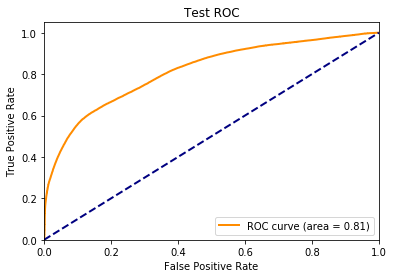

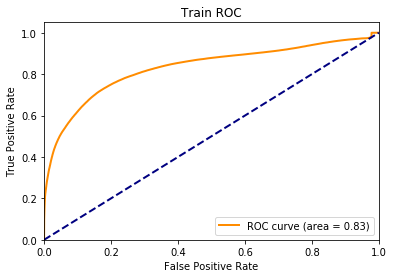

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred[:,1])
#fpr, tpr, _ = roc_curve(y_test, y_test_pred)

test_roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()


fpr, tpr, _ = roc_curve(y_train, y_train_pred[:,1])
#fpr, tpr, _ = roc_curve(y_train, y_train_pred)

train_roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")
plt.show()

False Positive
False Negative
False Negative
True Positive
True Positive
False Negative
False Negative
True Positive
True Positive
False Positive
False Positive
False Positive
False Positive
False Negative
False Positive
True Positive
False Negative
True Positive
True Positive
True Positive
False Positive
True Positive
True Positive
True Positive
False Negative
False Positive
False Negative


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


True Positive
True Positive
True Positive
True Positive
False Negative
False Positive
False Positive
False Negative
True Positive
False Negative
True Positive
False Positive
True Positive
False Negative
True Positive
True Positive
False Positive
False Positive
False Positive
False Positive
True Positive
False Negative
True Positive
False Positive
False Positive
True Positive
False Positive
True Positive
True Positive
False Positive
False Positive
False Positive
True Positive
False Negative
False Positive
False Negative
False Positive
False Positive
False Positive
True Positive
True Positive
False Negative
True Positive
False Positive
True Positive
True Positive
False Positive
True Positive
True Positive
True Positive
False Negative
False Positive
True Positive
True Positive
False Positive
True Positive
True Positive
False Negative
True Positive
False Negative
False Positive
True Positive
True Positive
True Positive
False Negative
False Positive
False Positive
True Positive
True Positiv

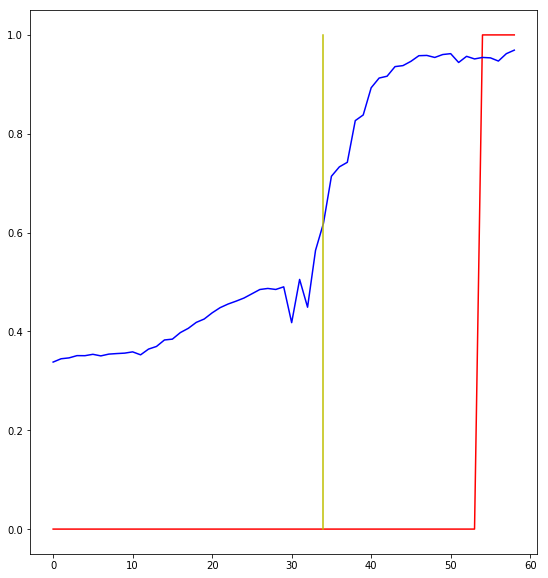

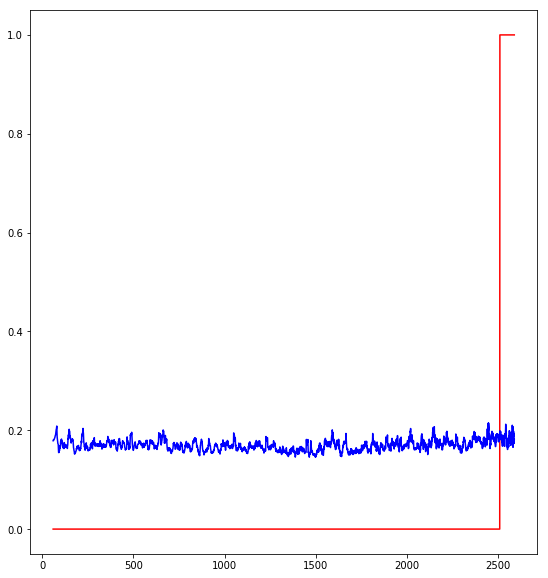

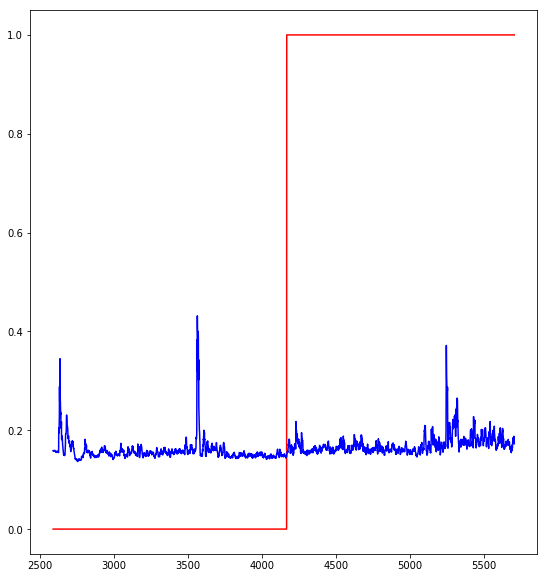

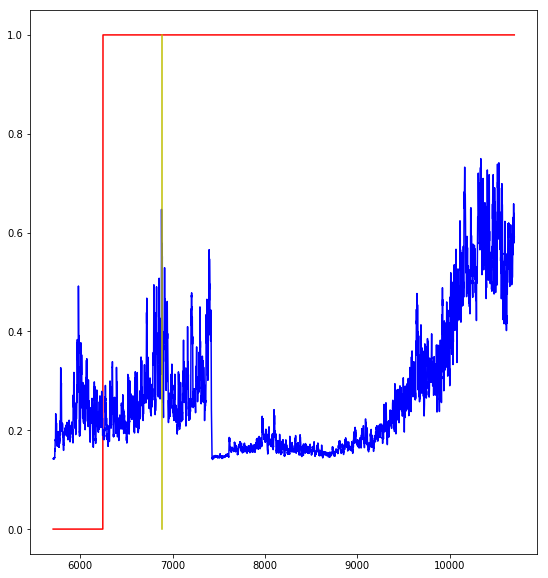

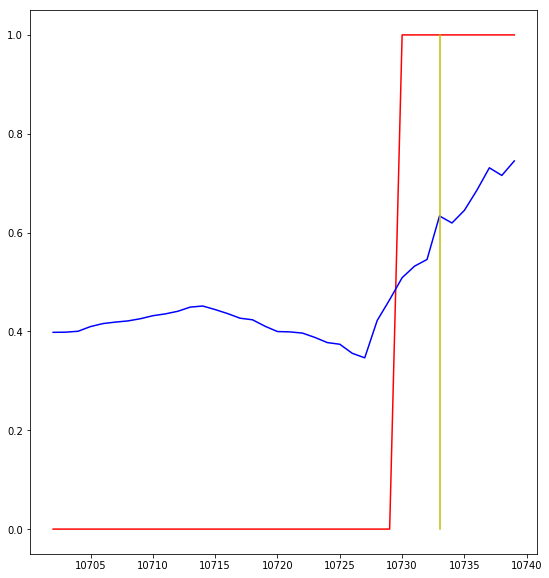

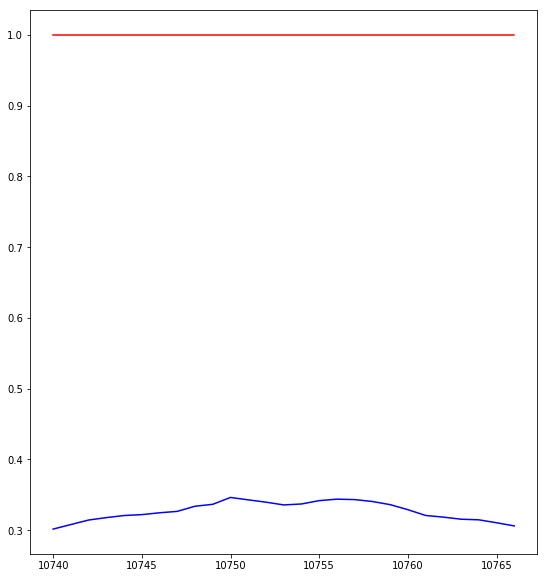

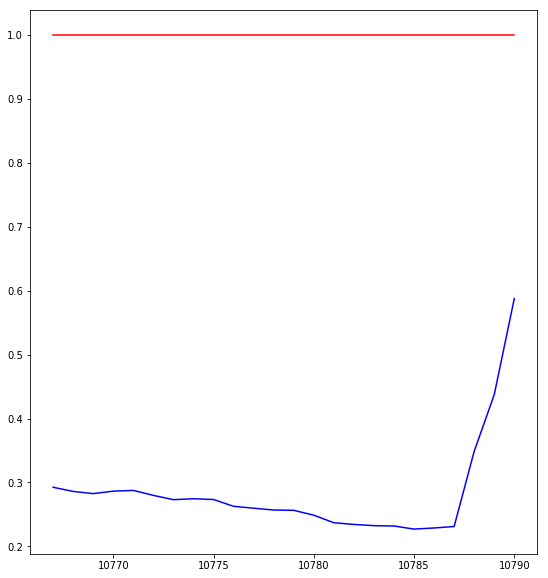

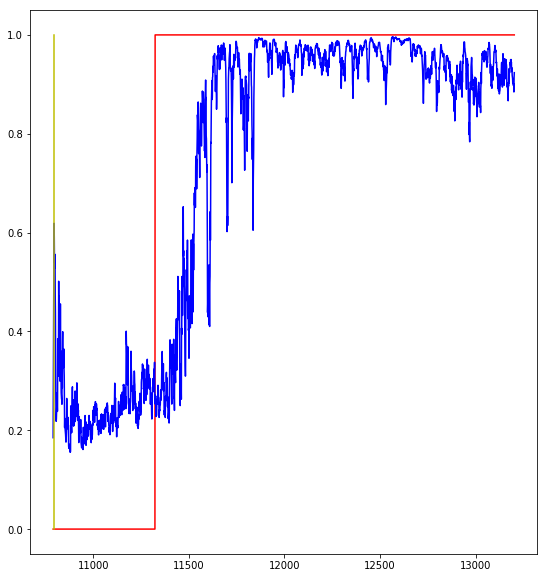

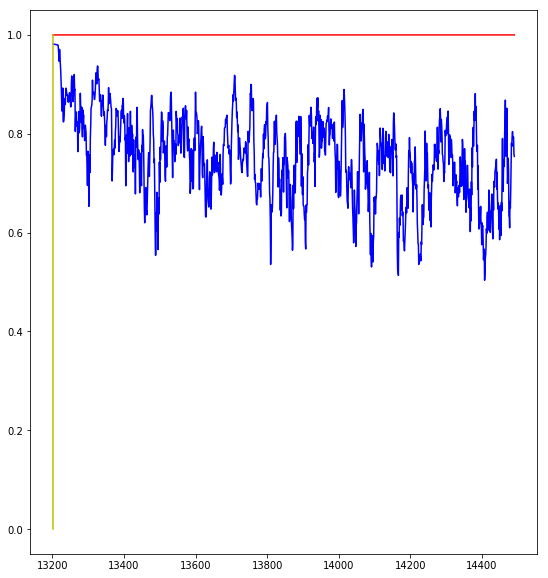

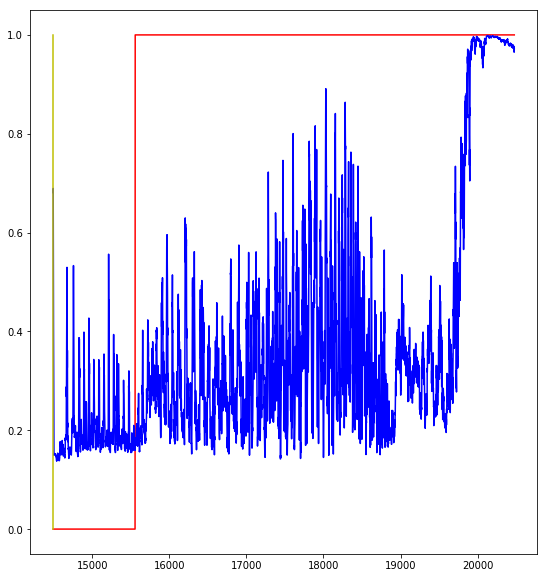

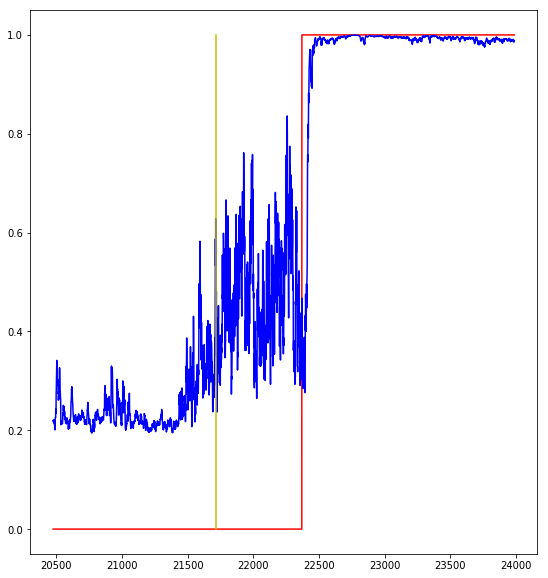

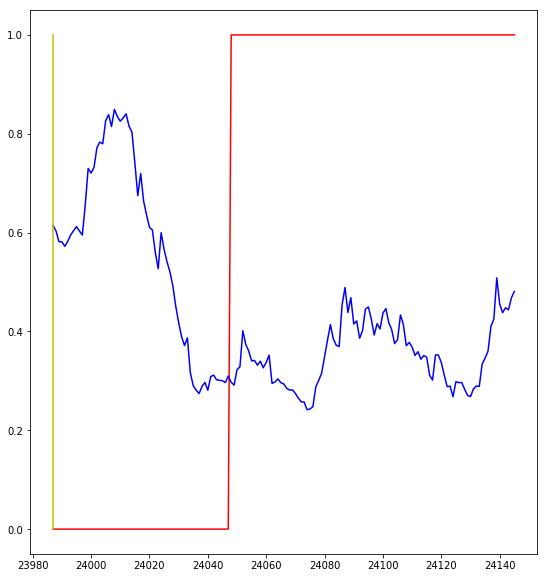

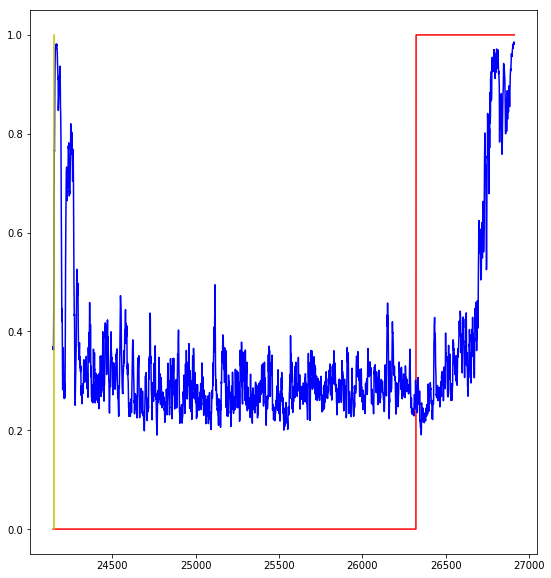

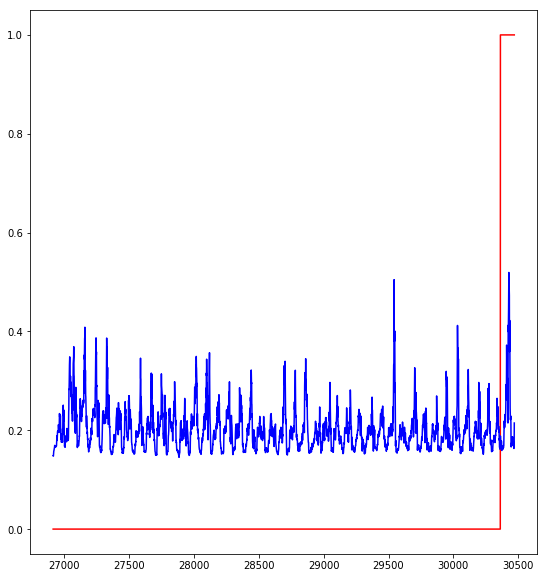

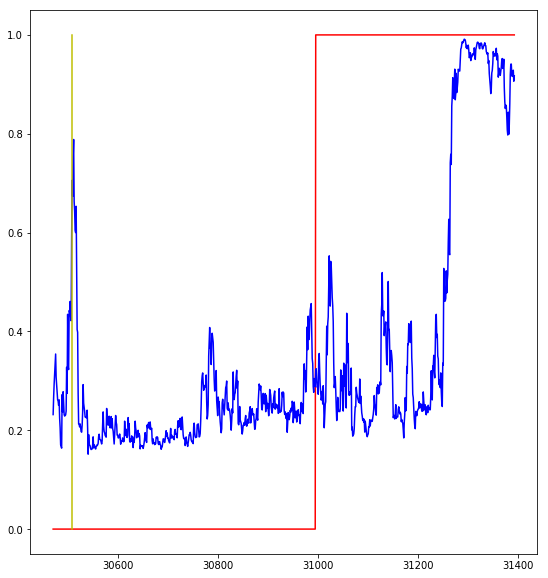

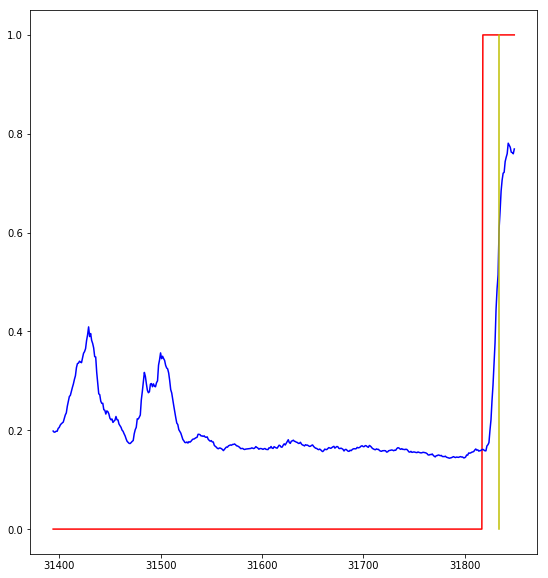

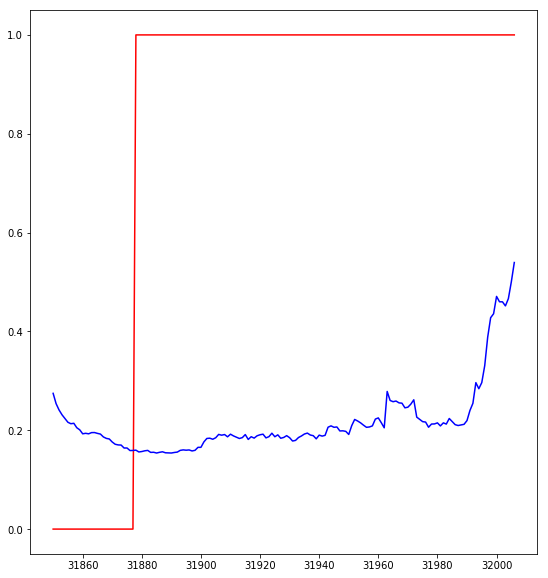

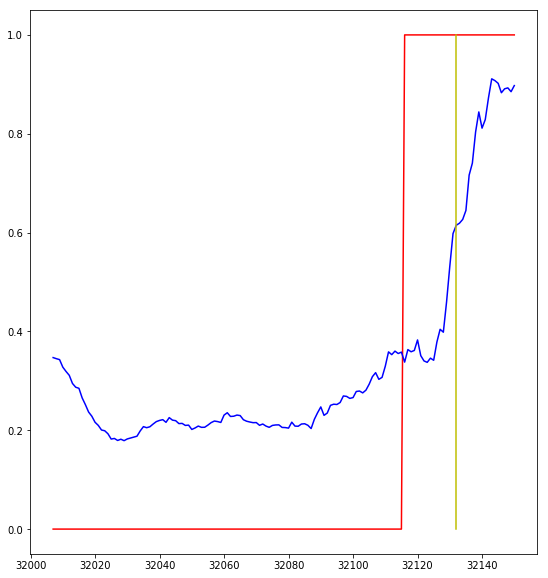

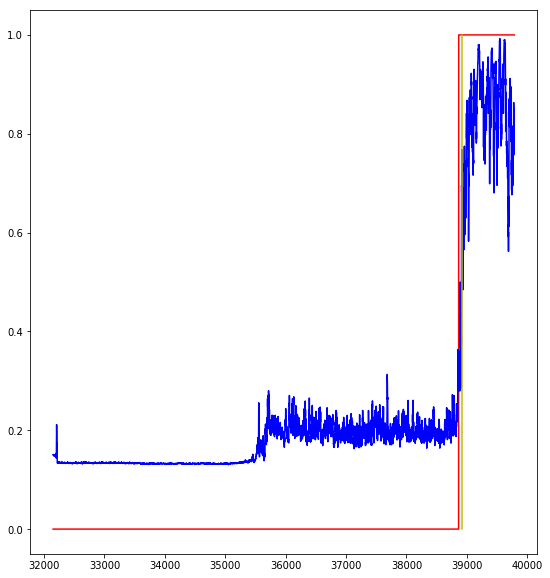

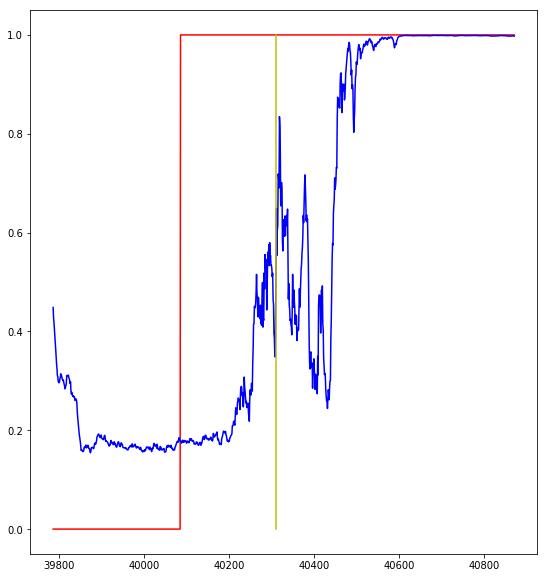

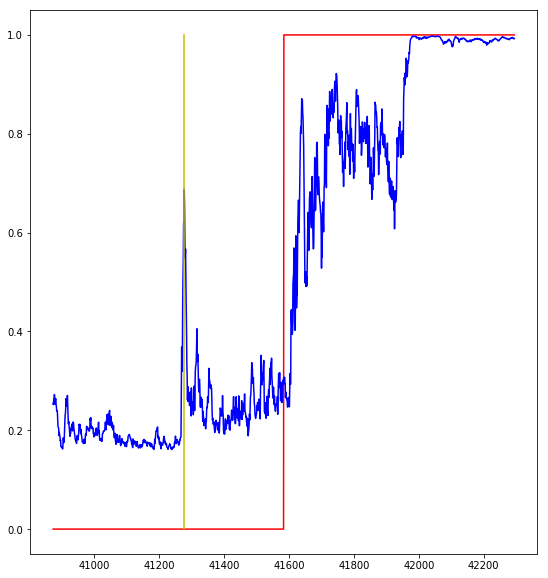

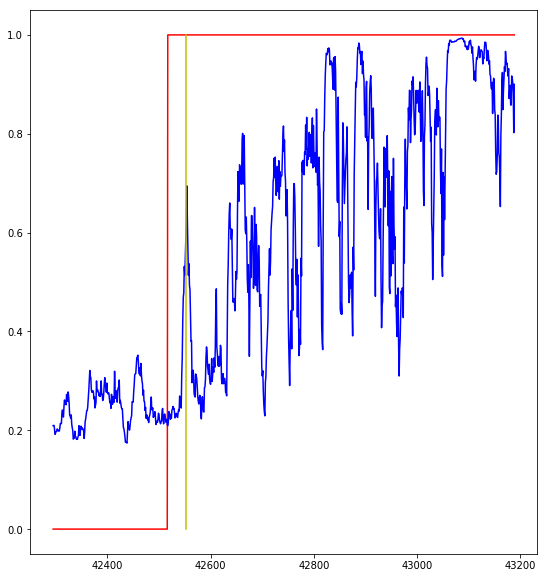

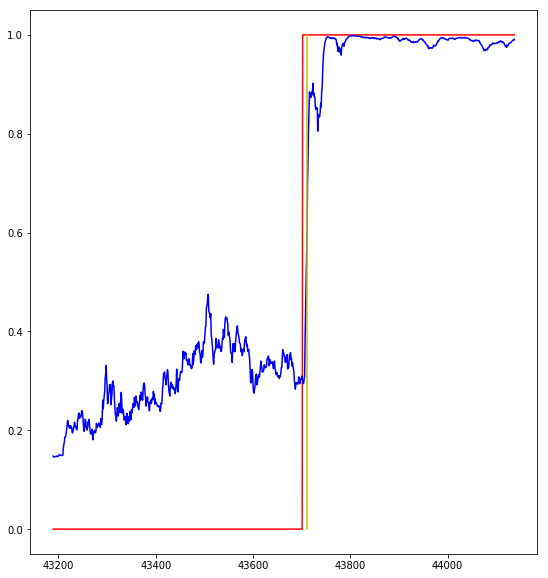

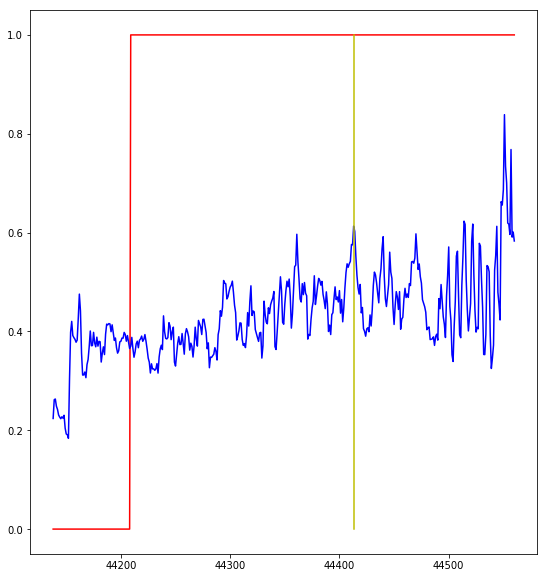

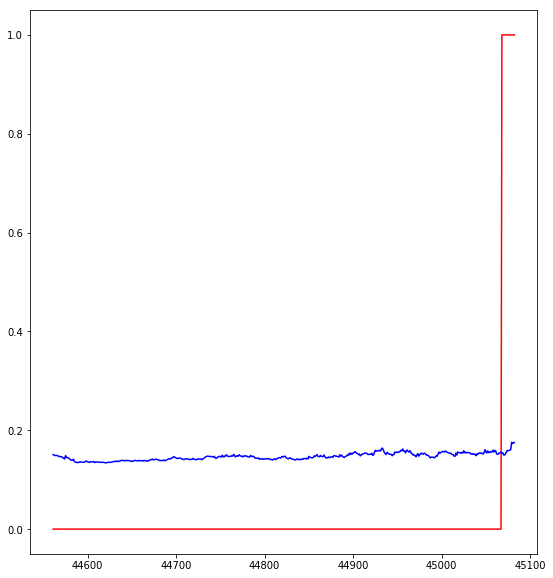

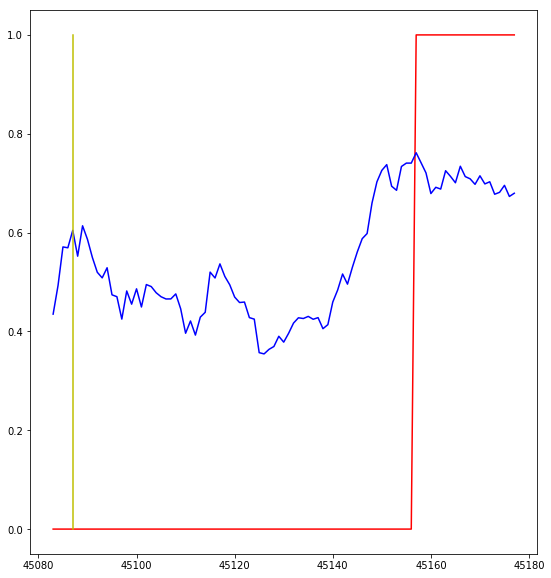

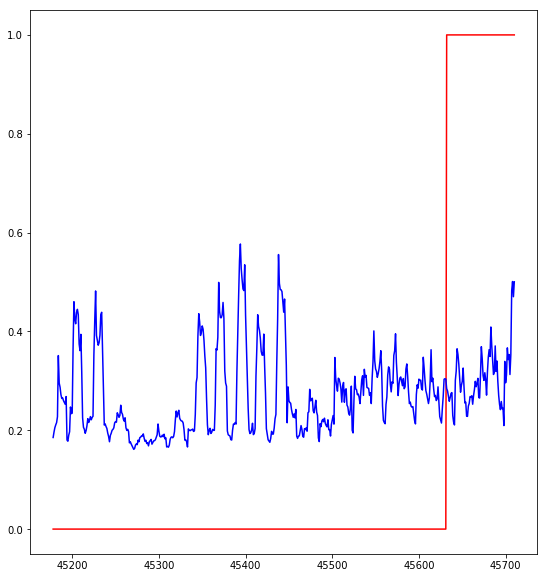

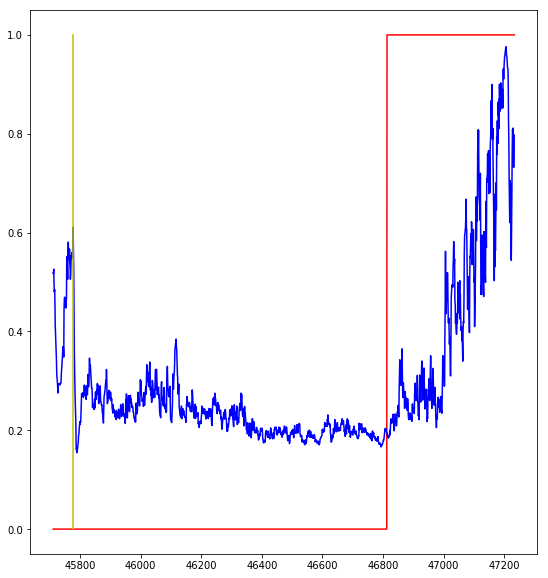

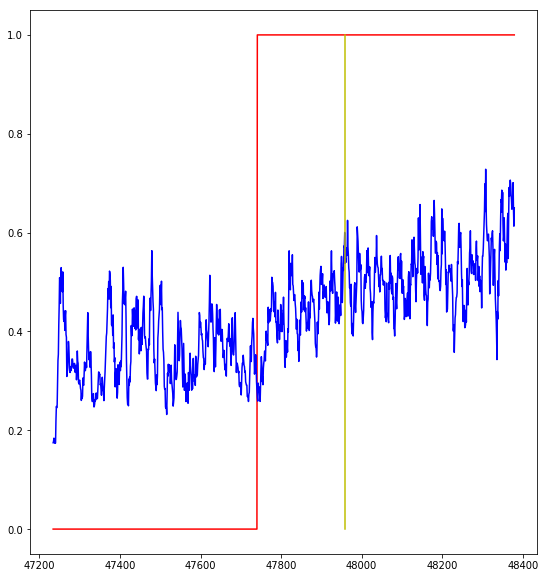

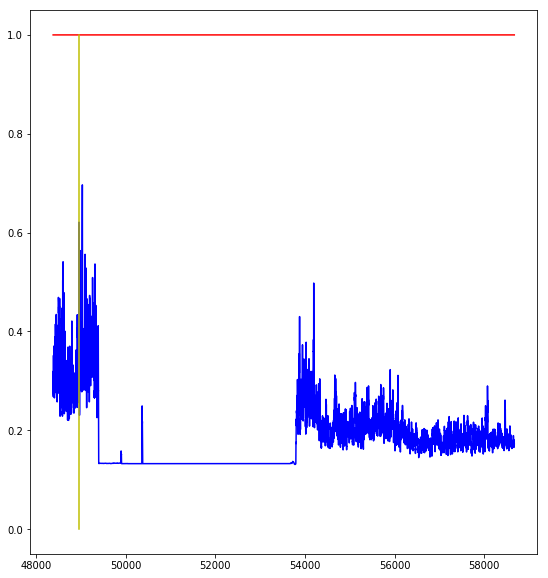

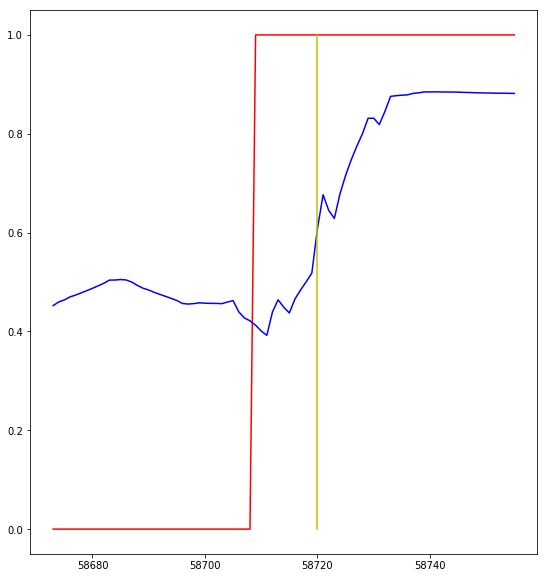

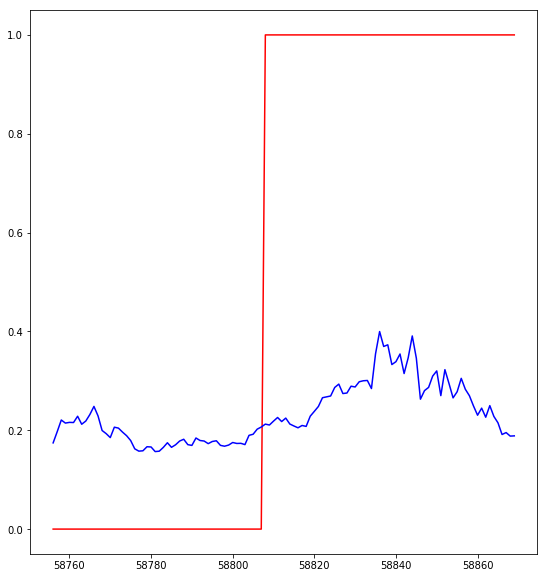

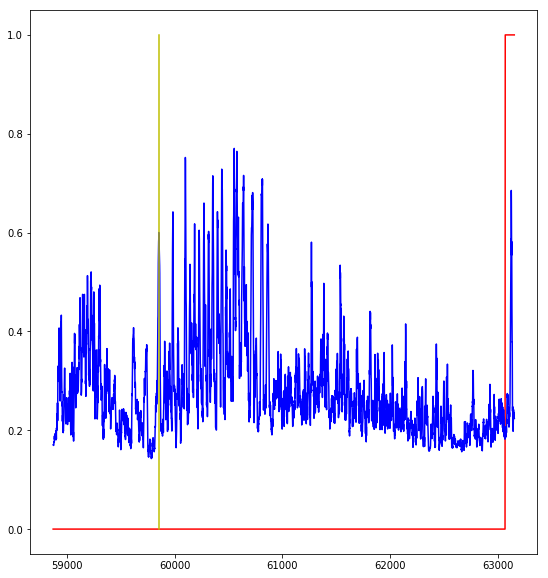

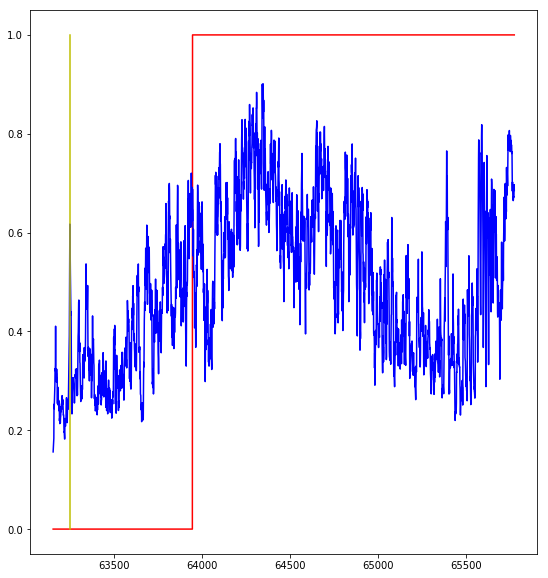

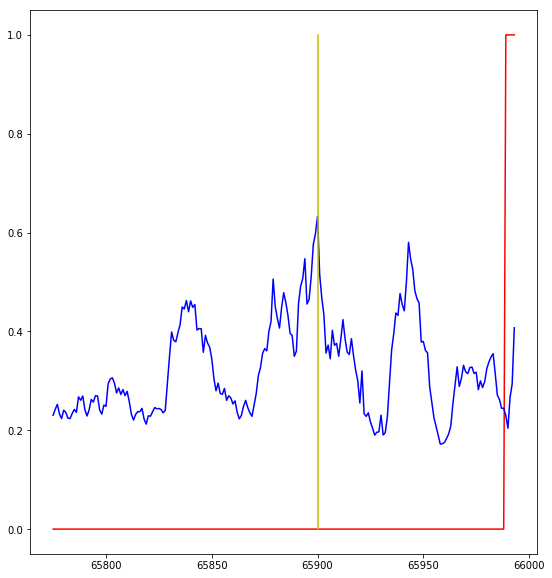

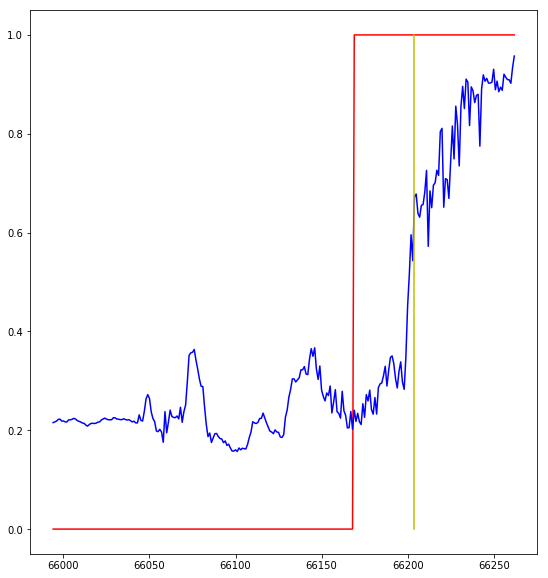

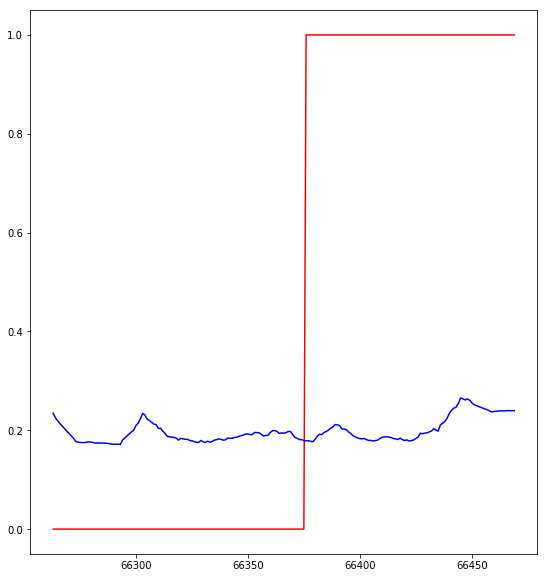

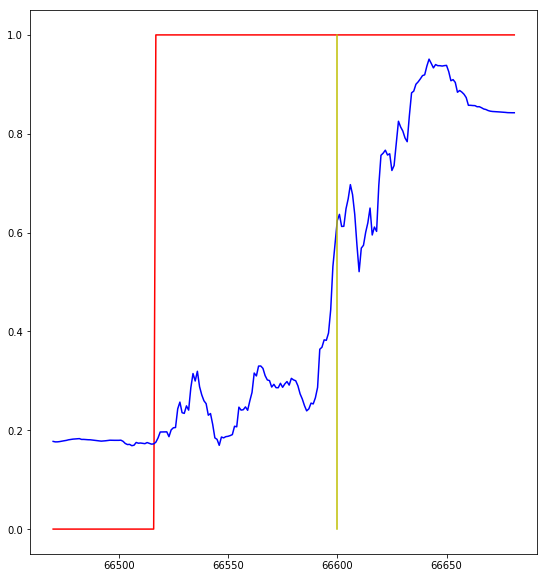

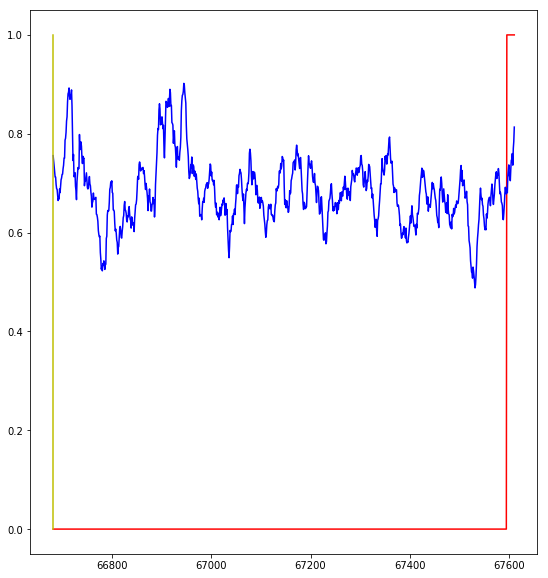

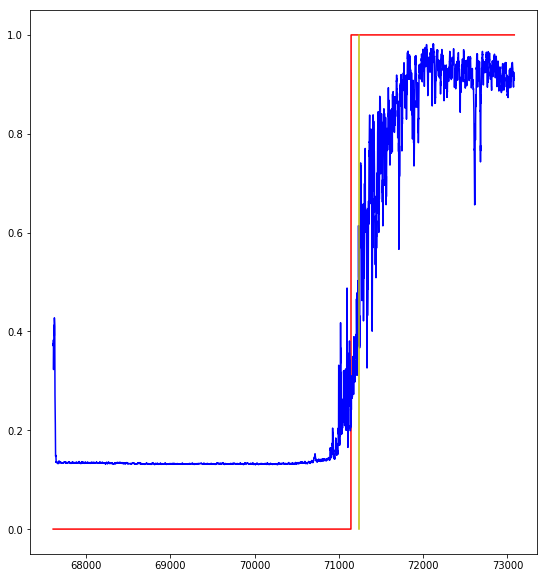

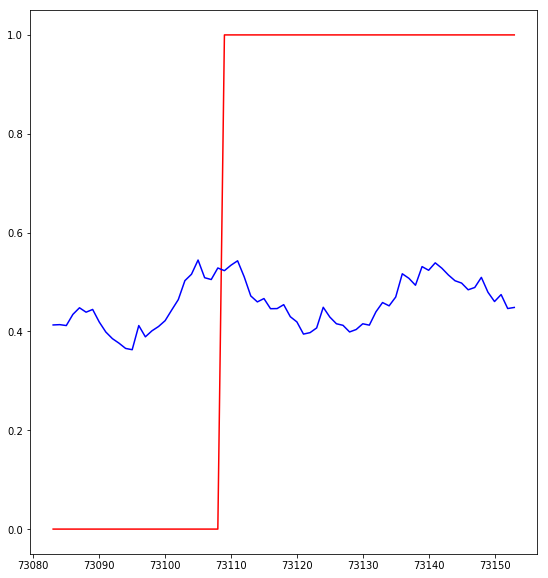

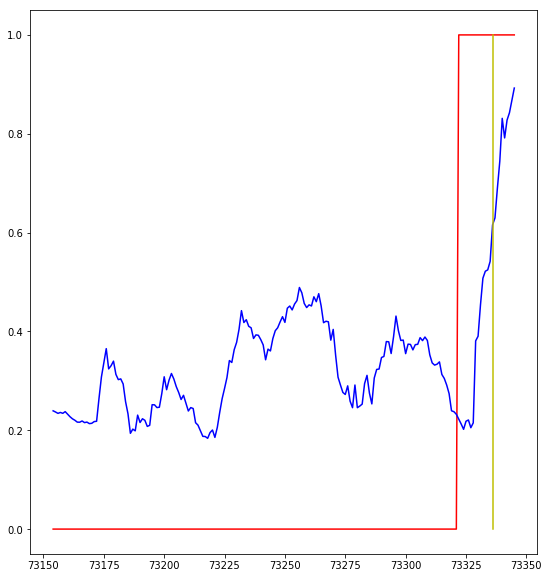

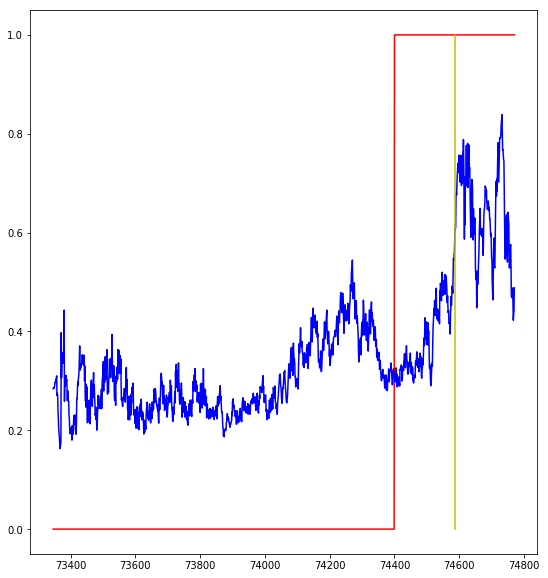

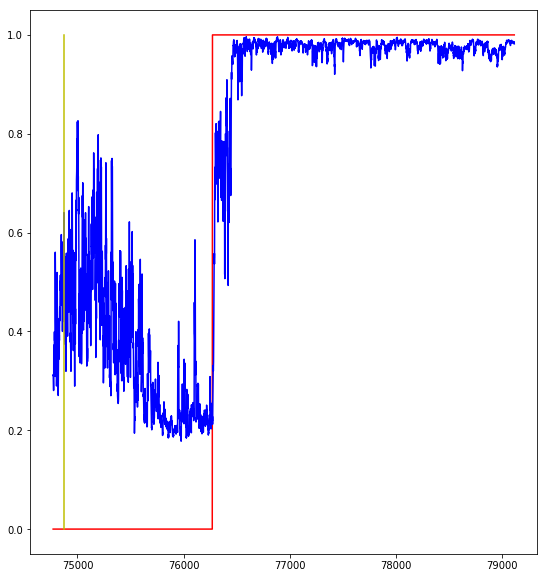

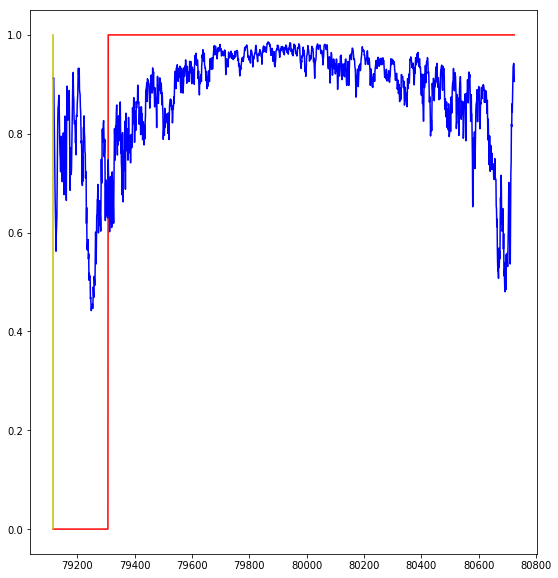

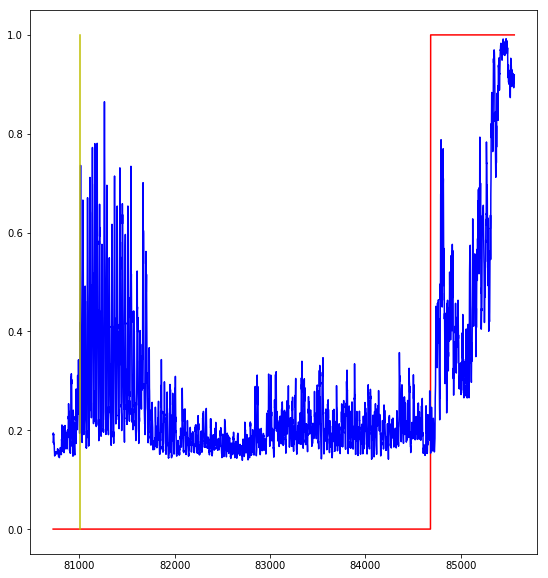

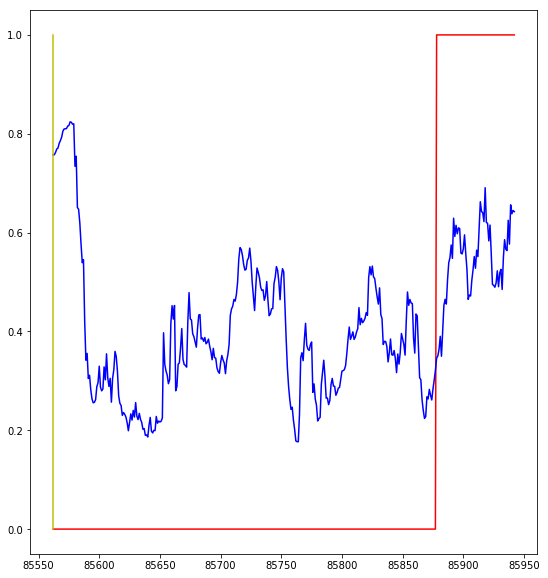

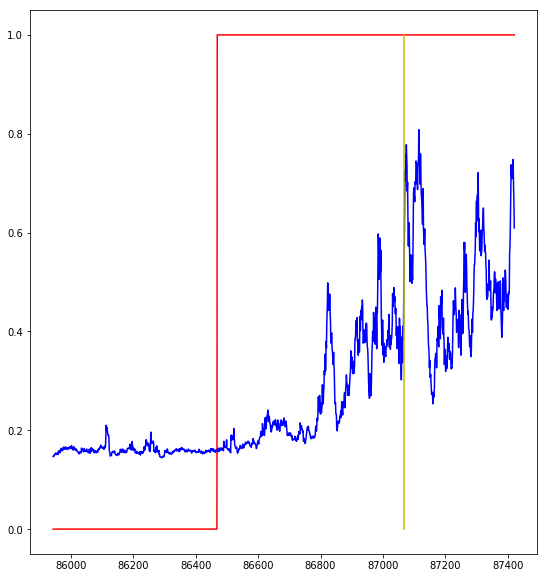

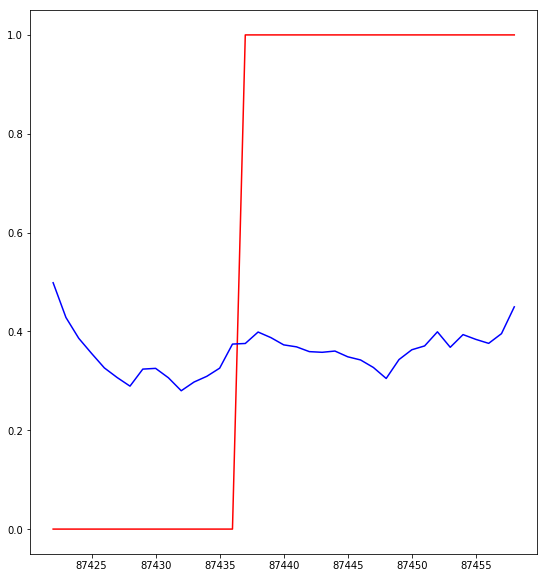

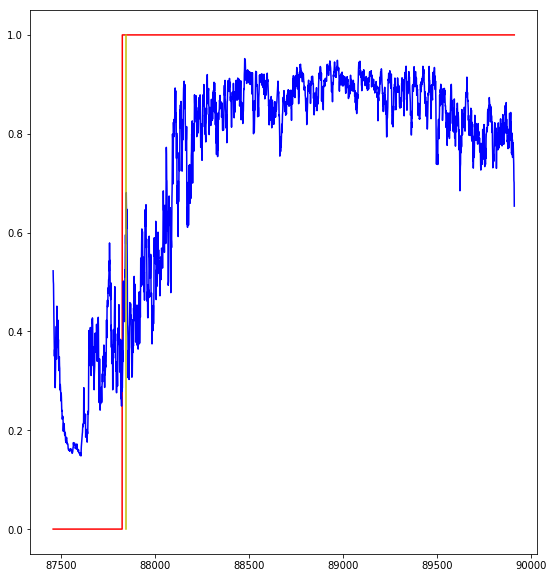

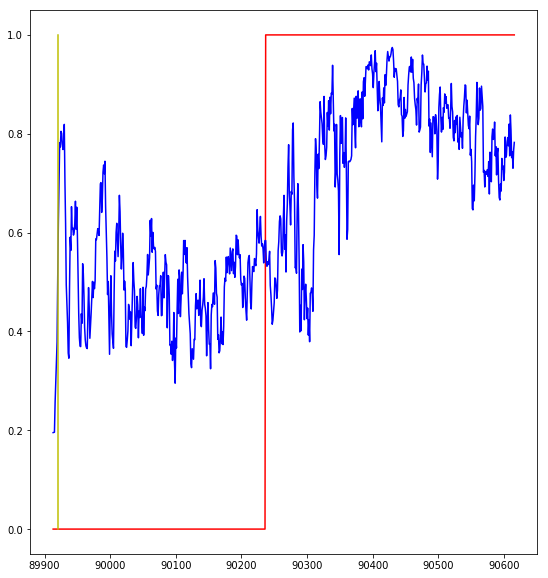

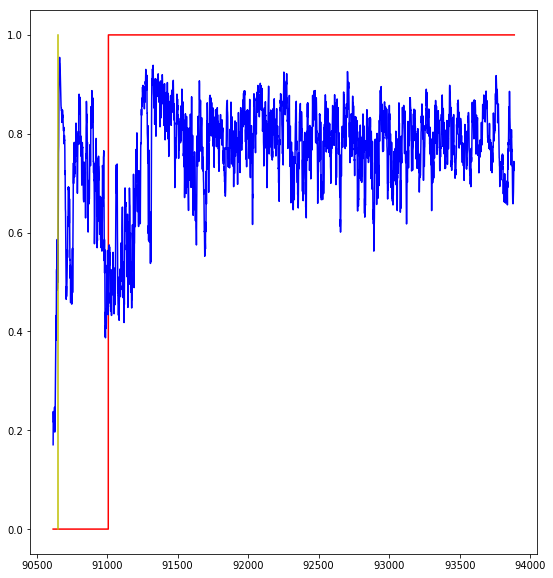

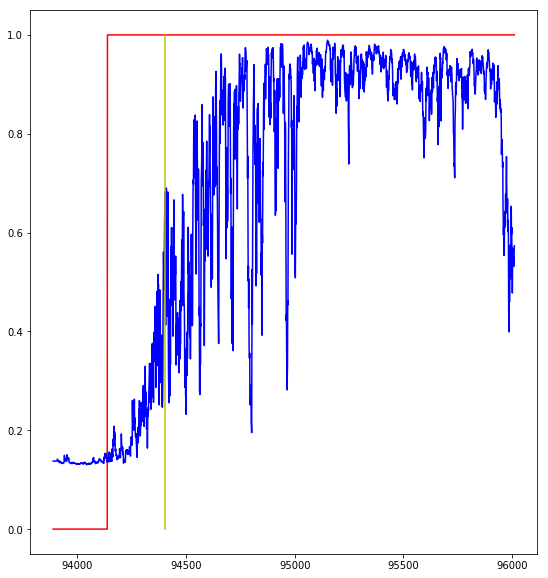

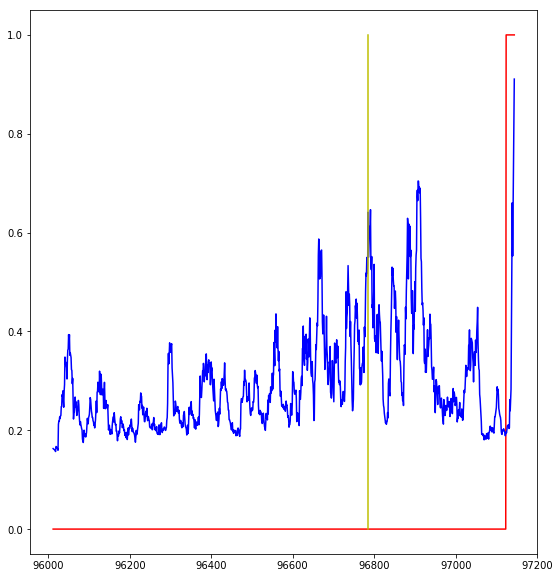

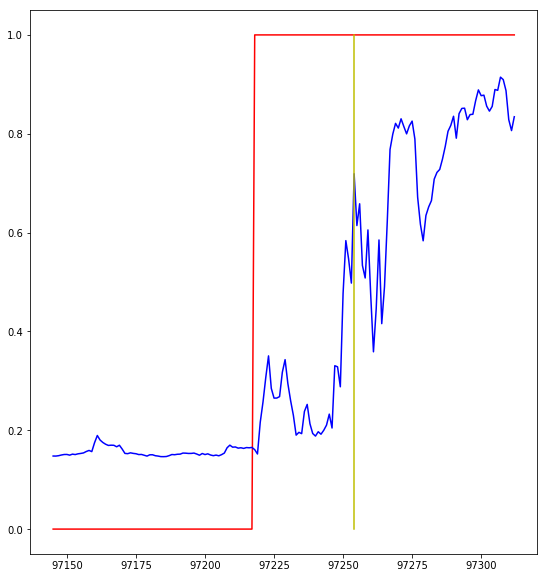

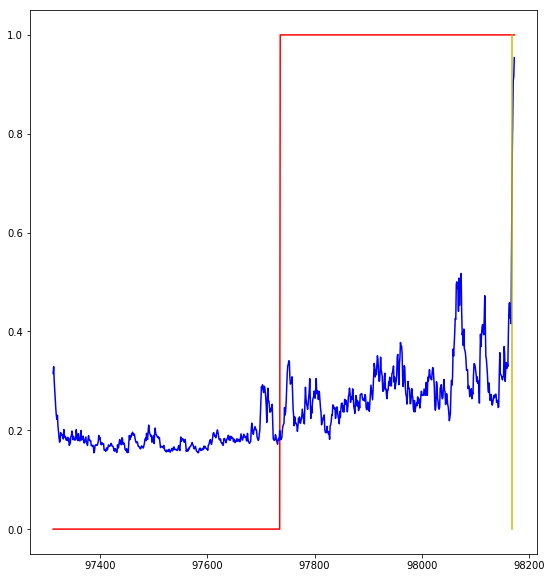

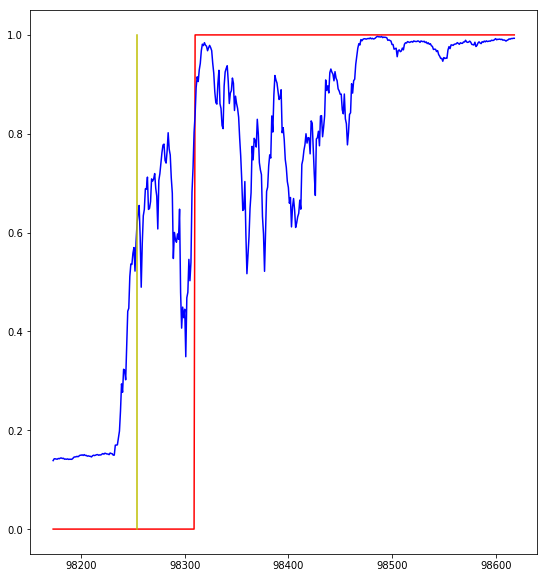

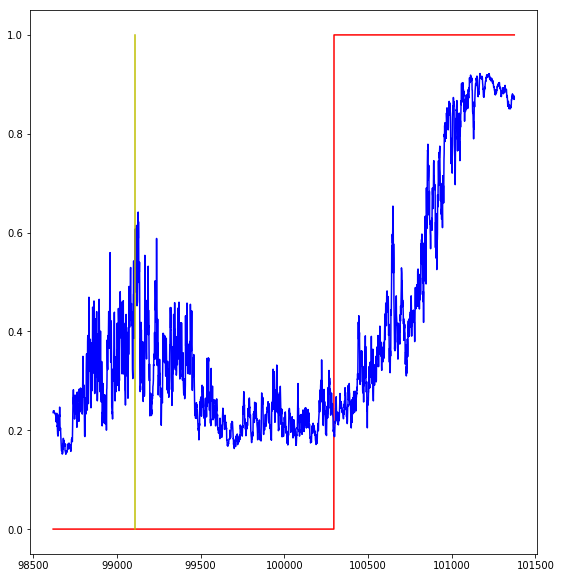

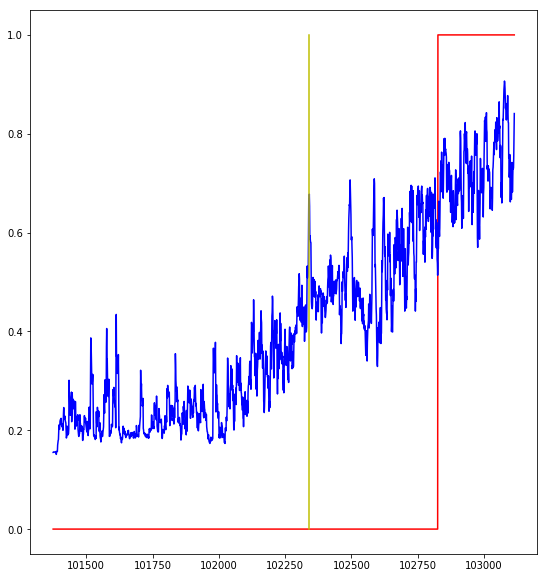

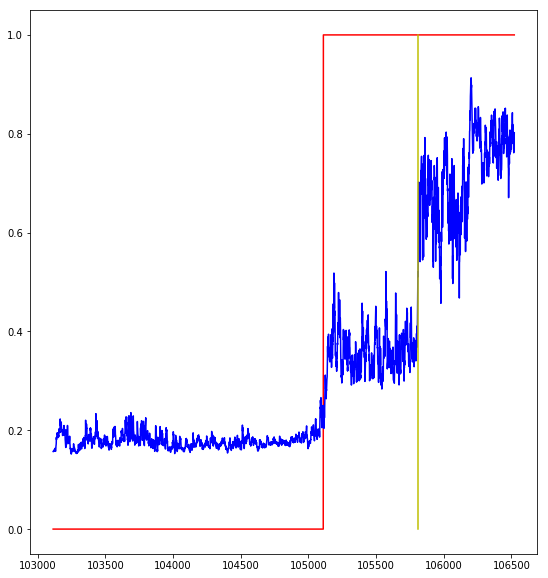

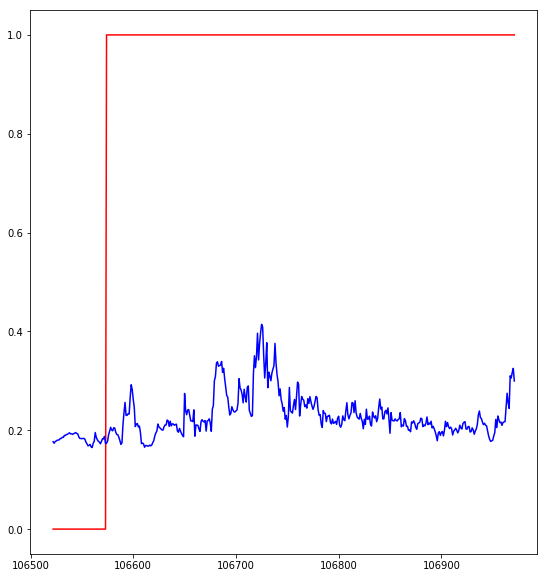

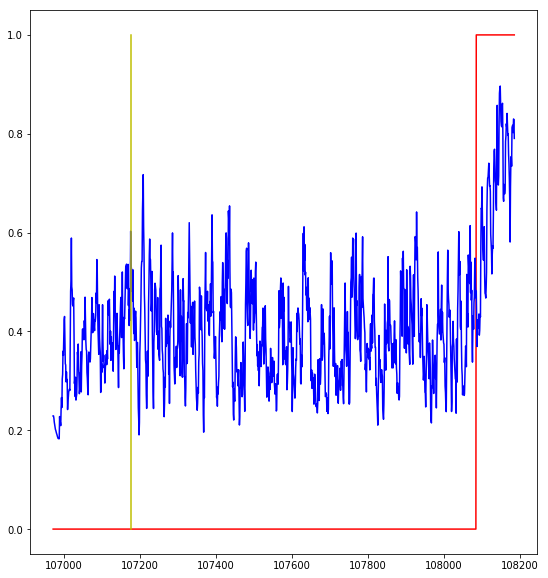

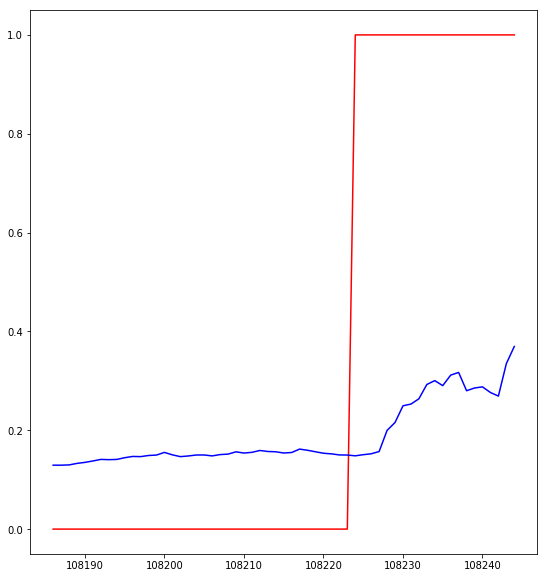

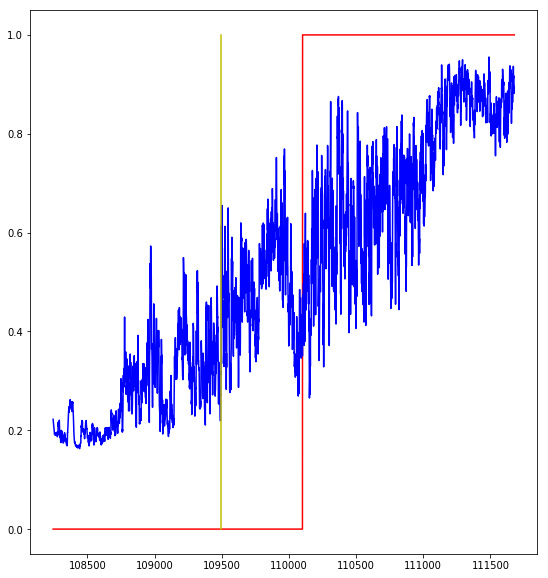

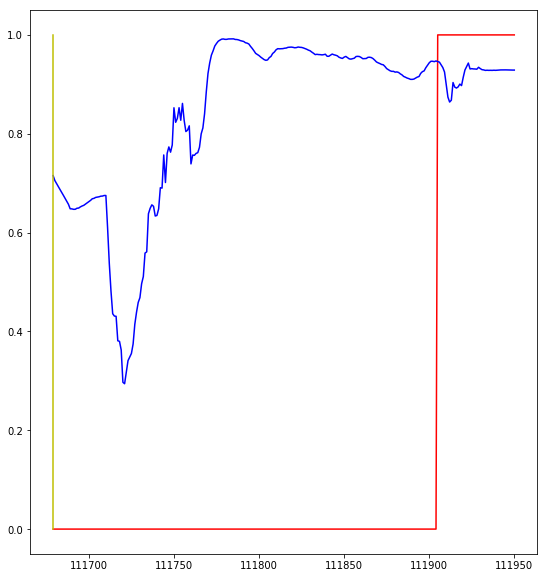

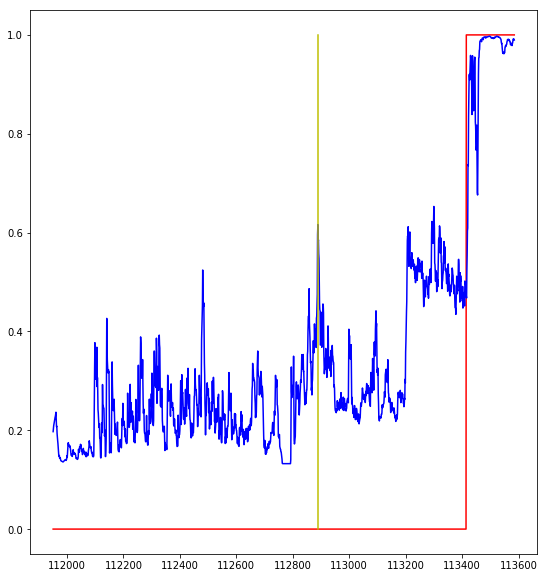

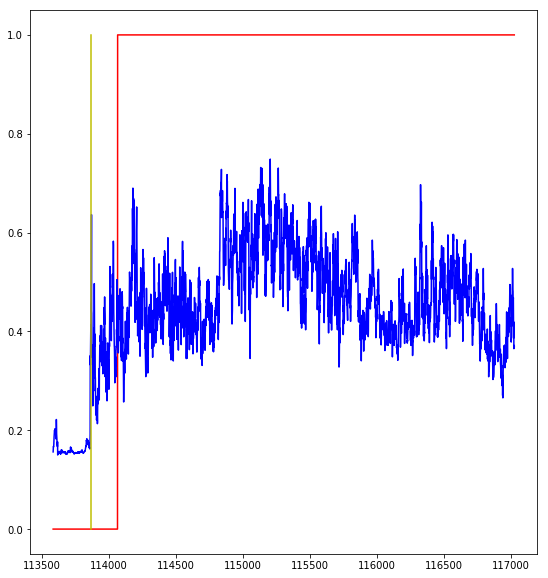

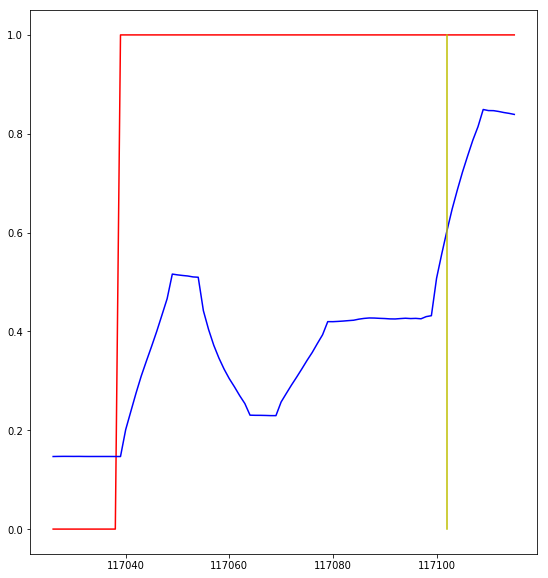

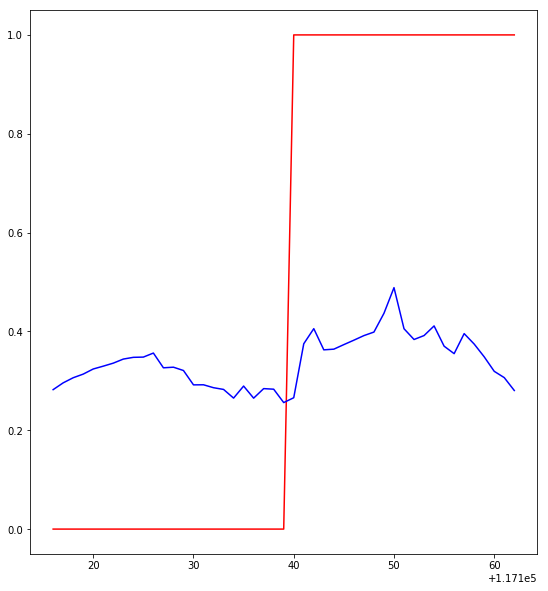

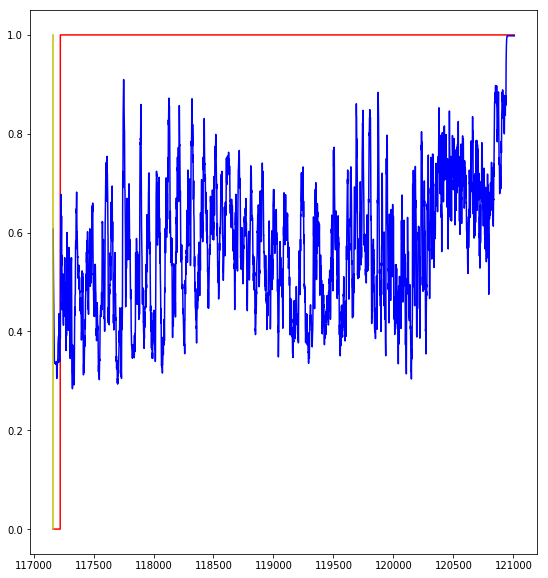

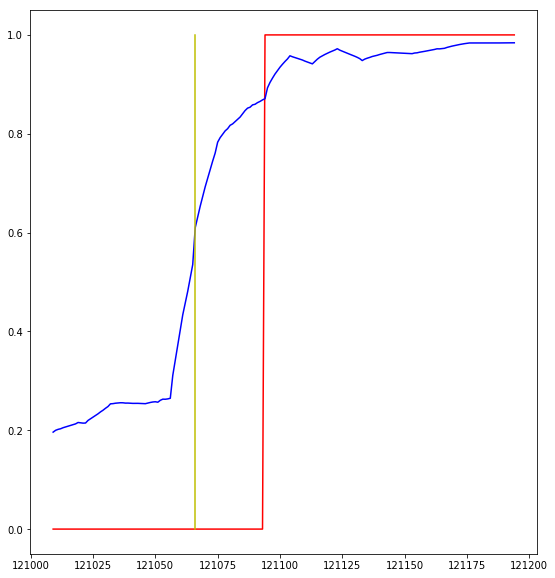

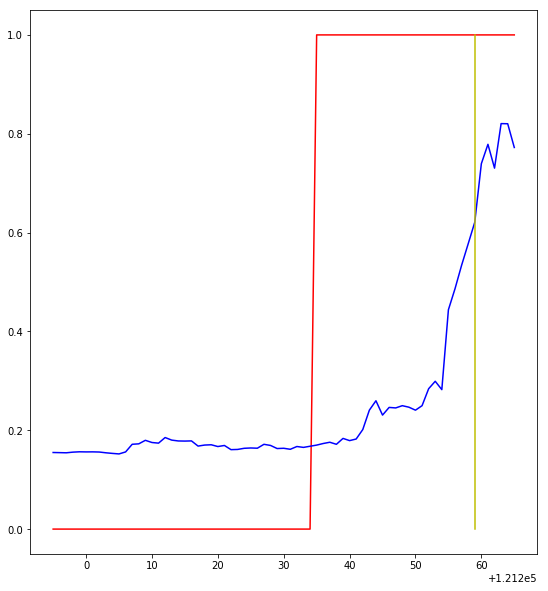

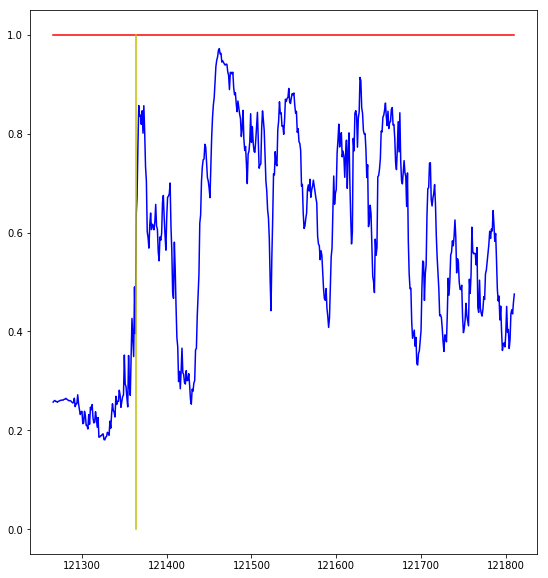

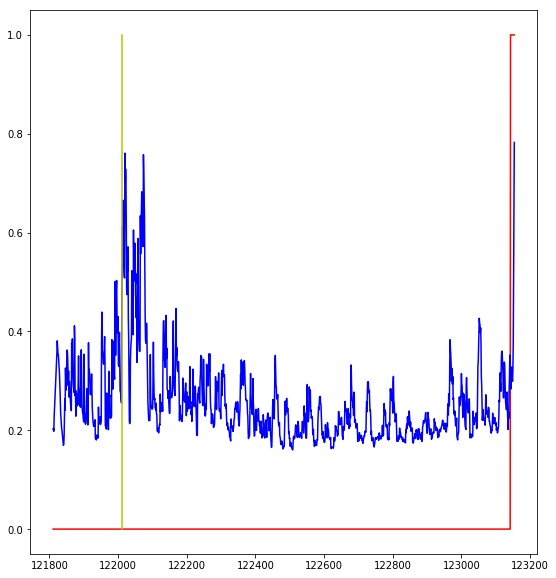

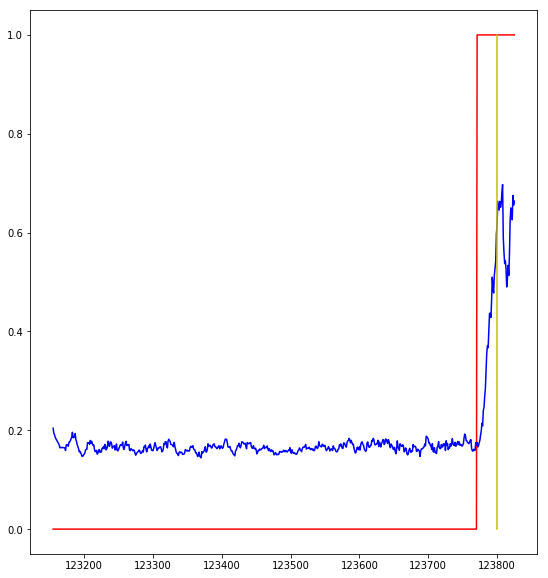

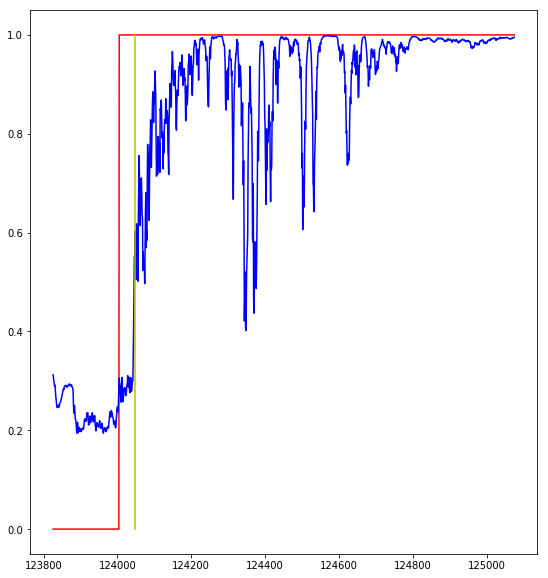

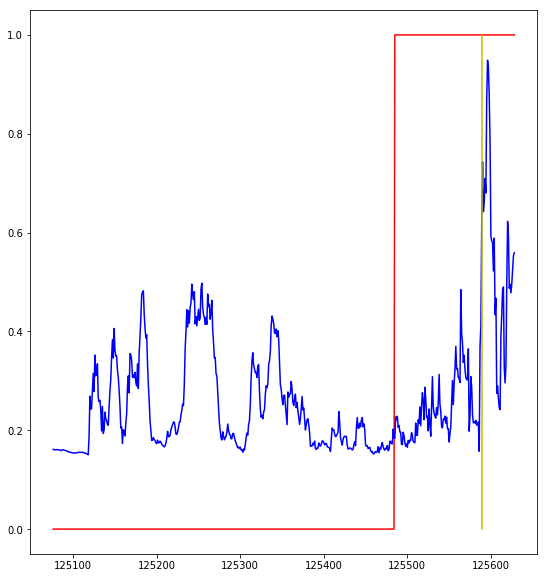

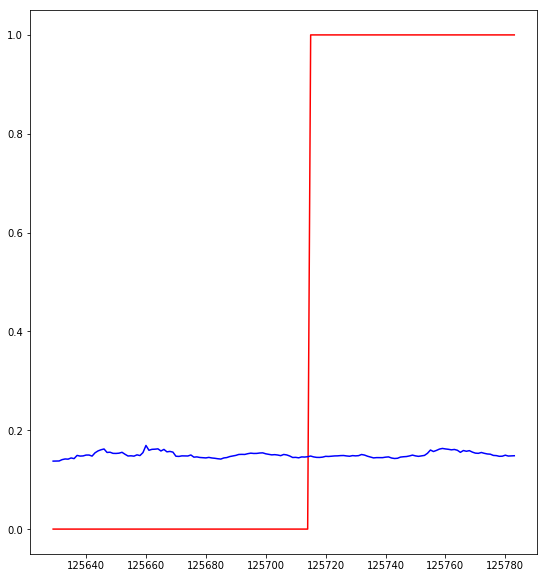

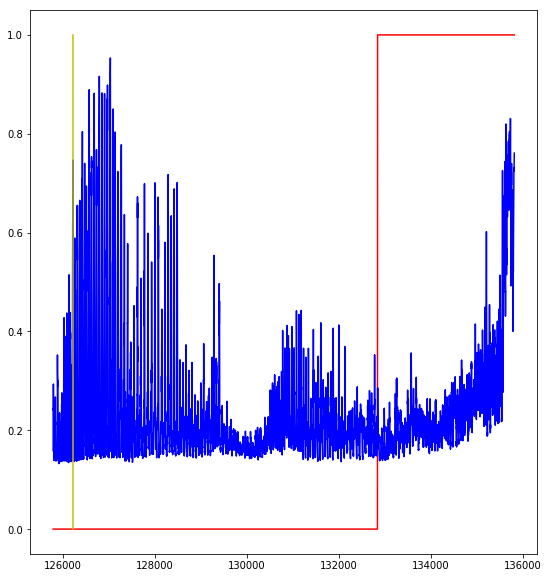

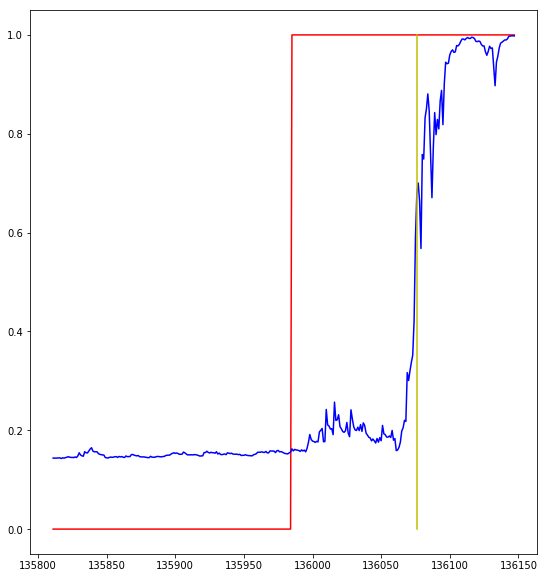

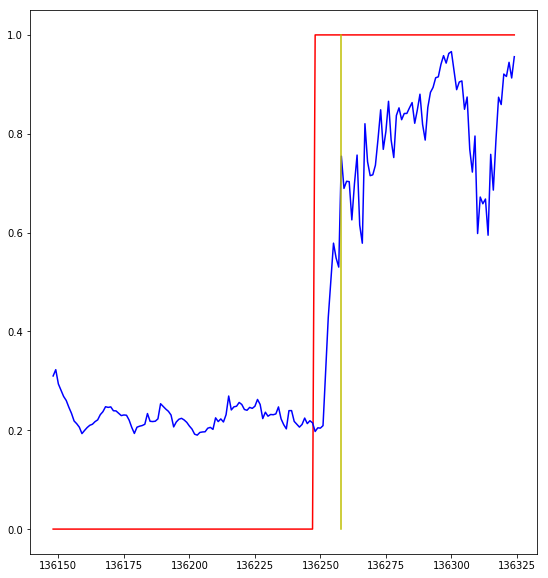

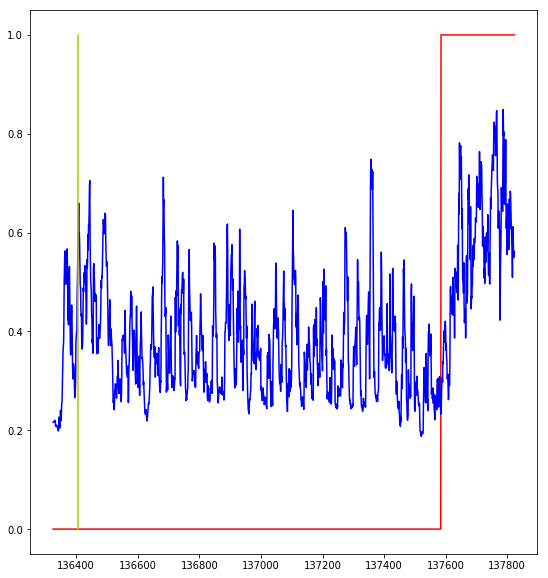

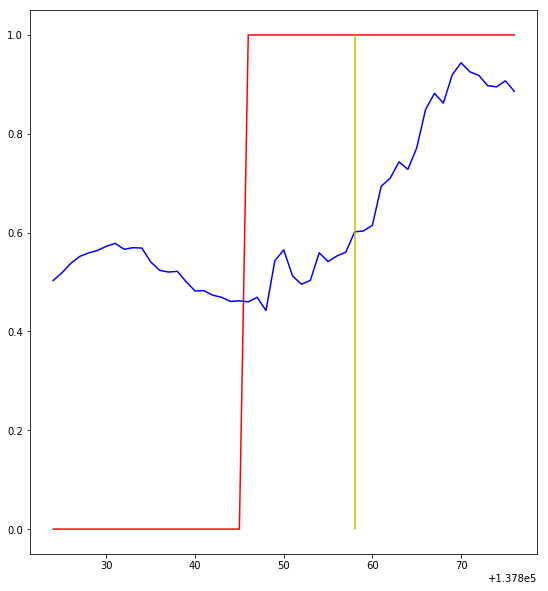

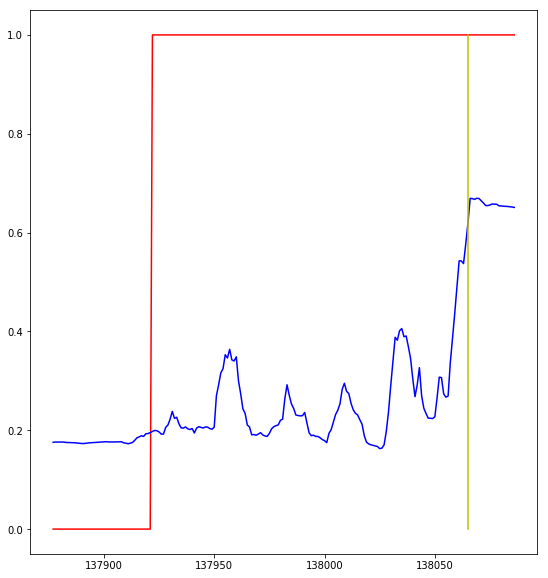

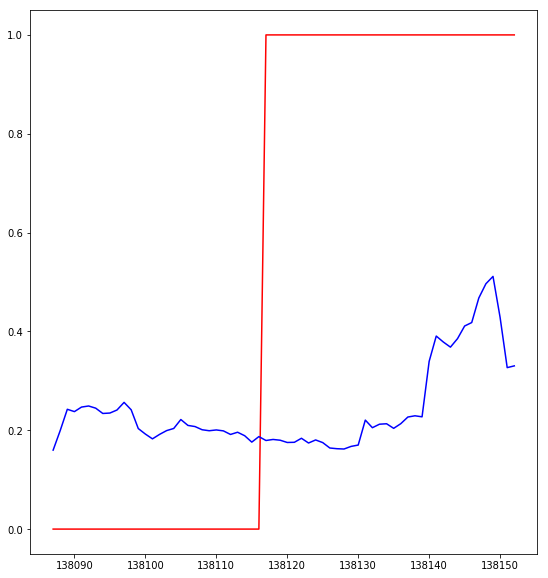

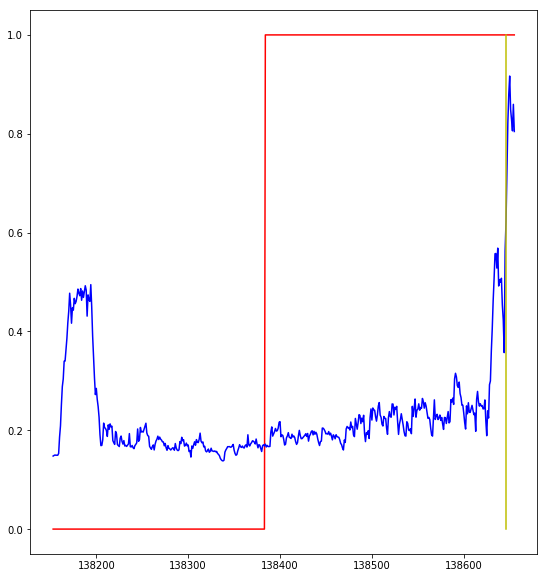

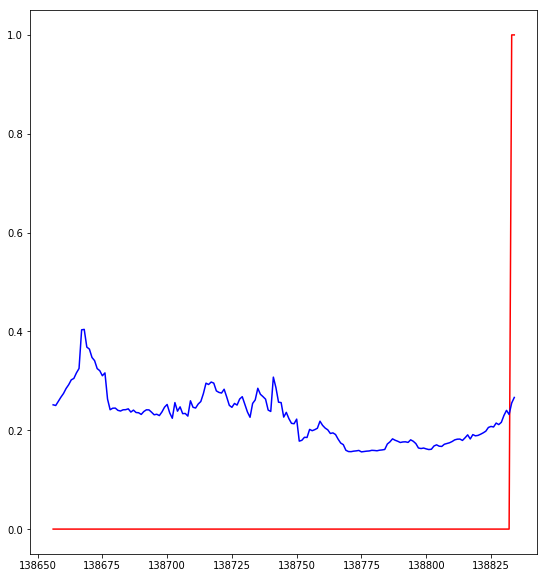

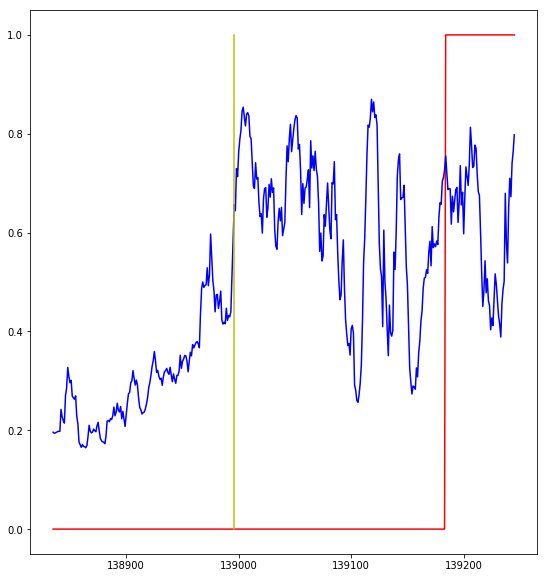

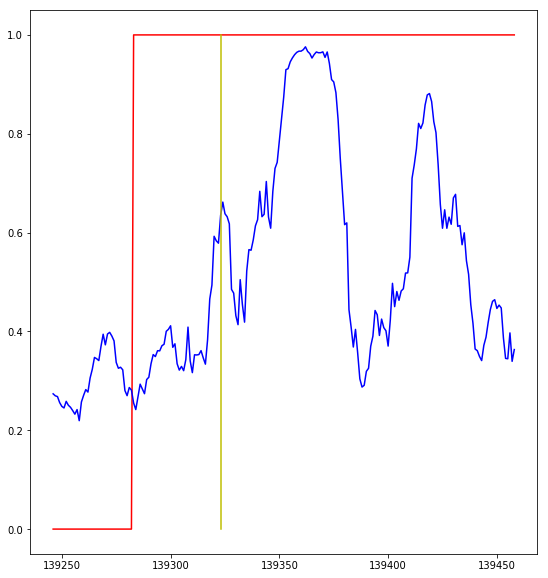

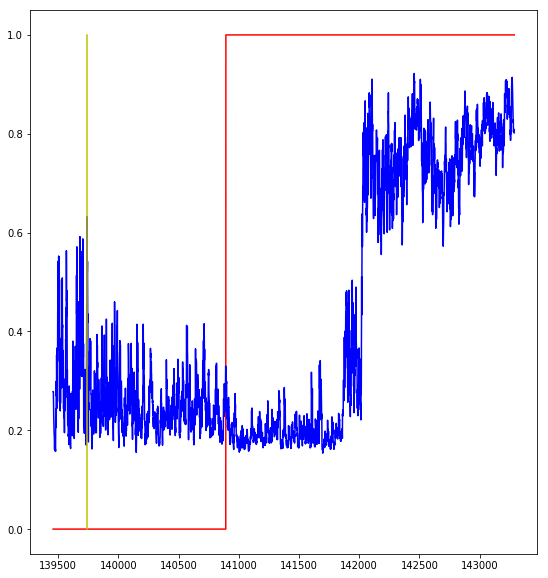

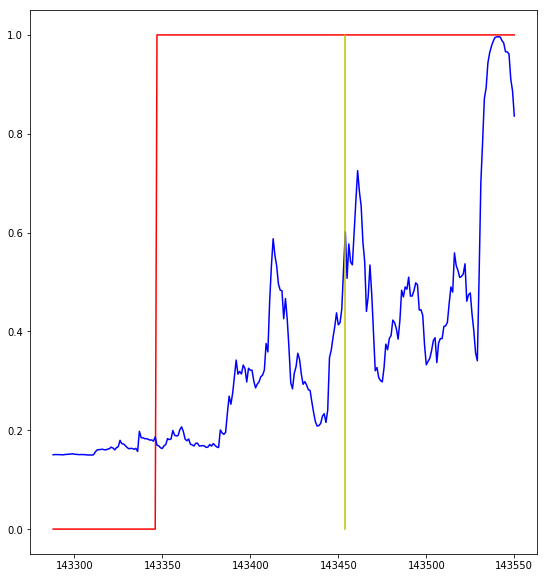

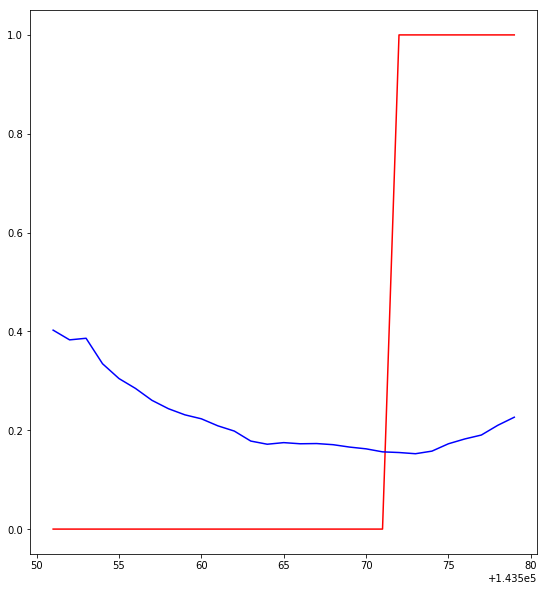

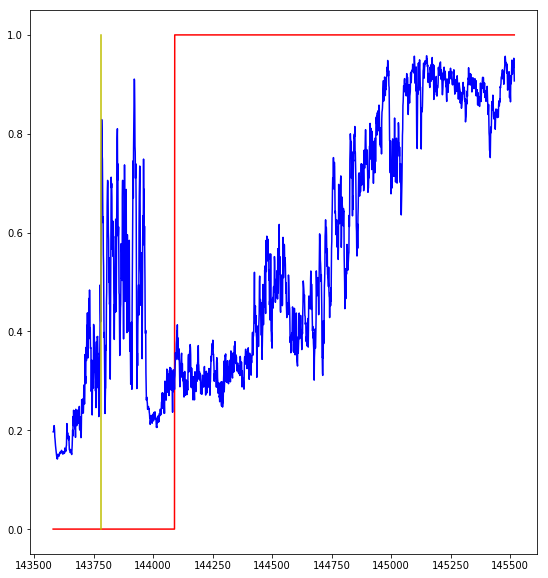

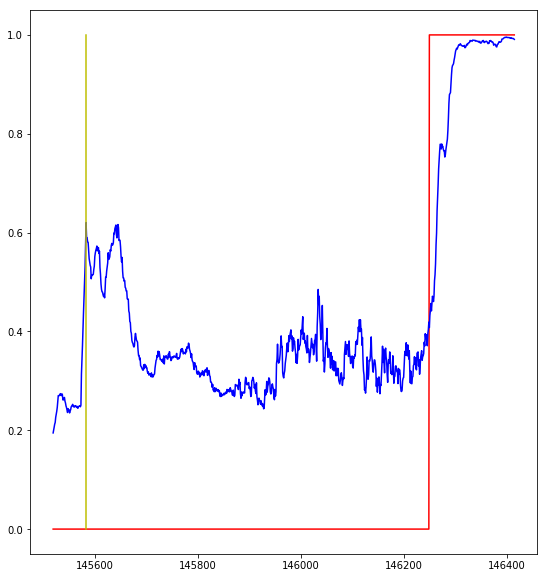

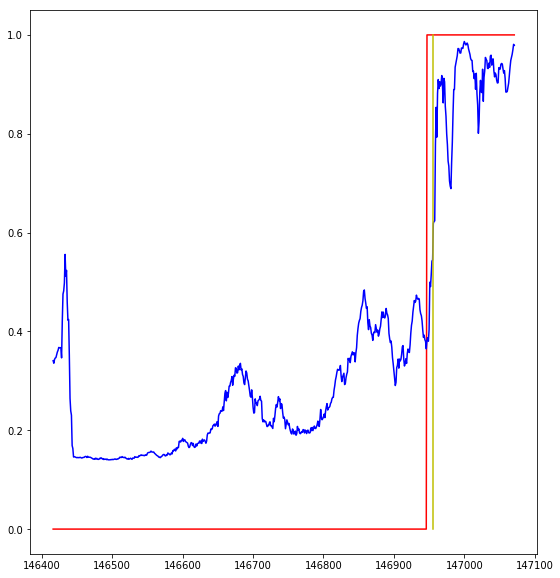

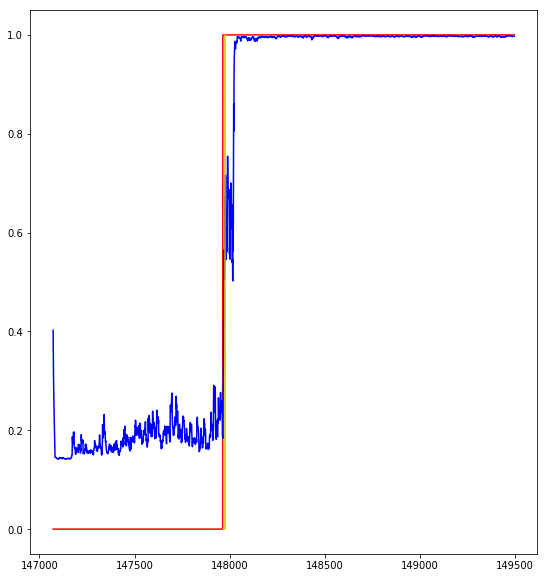

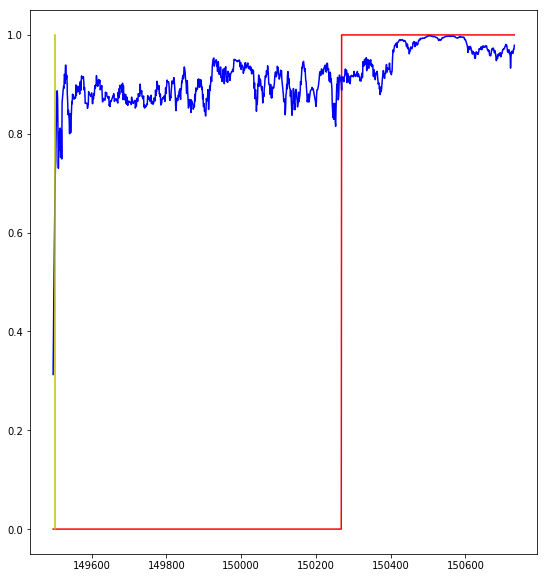

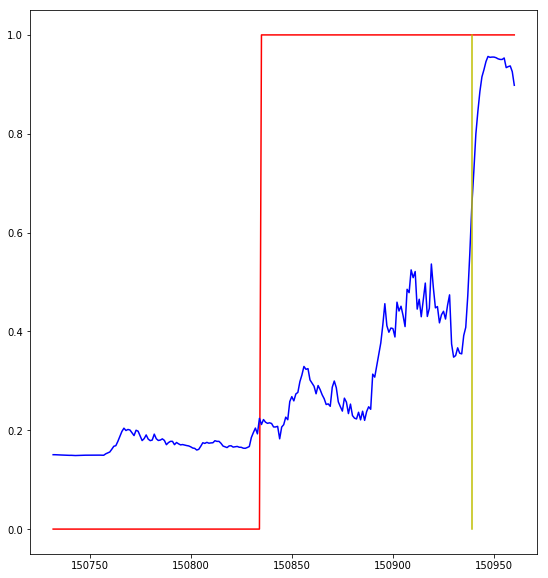

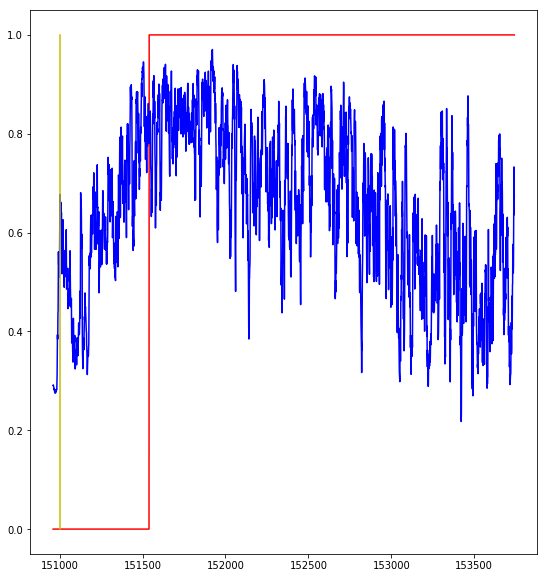

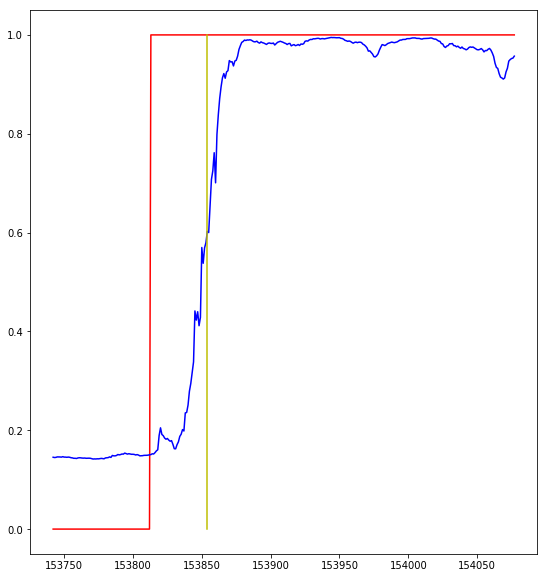

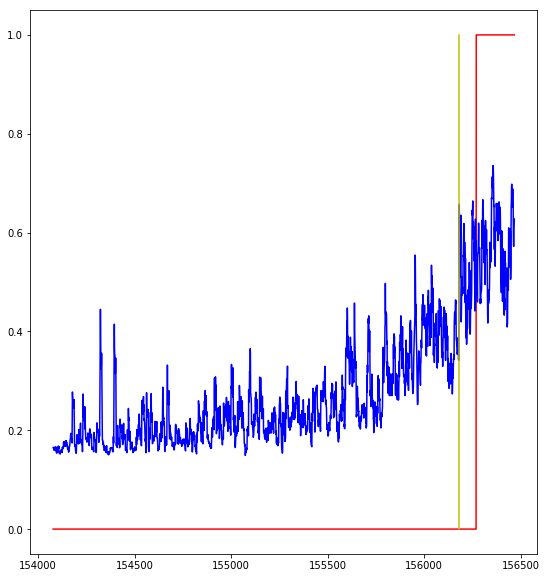

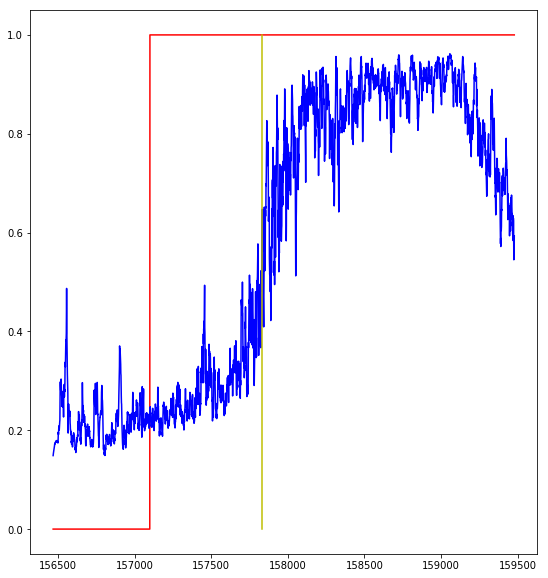

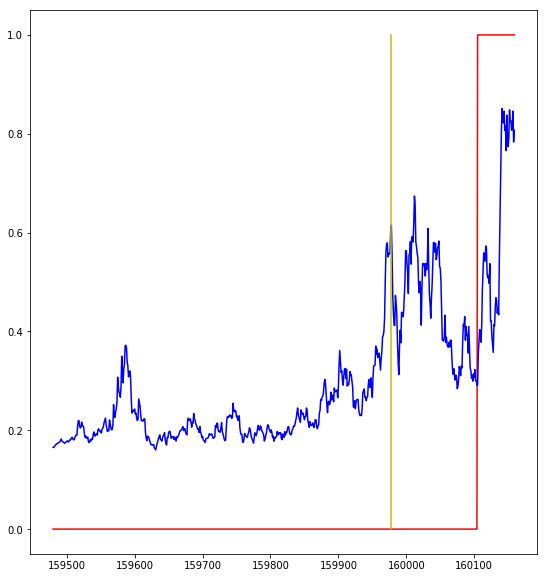

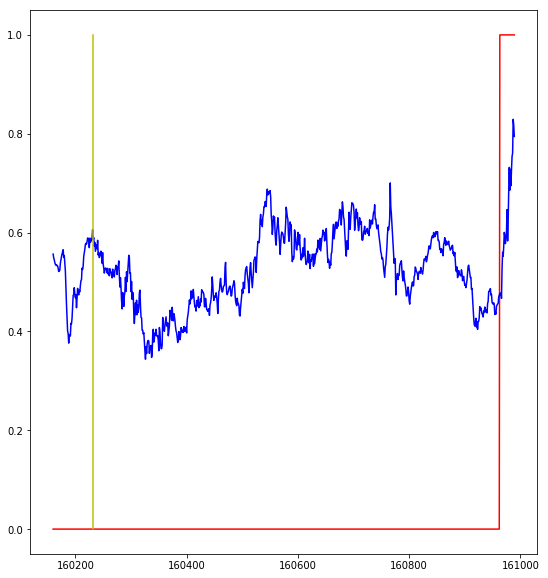

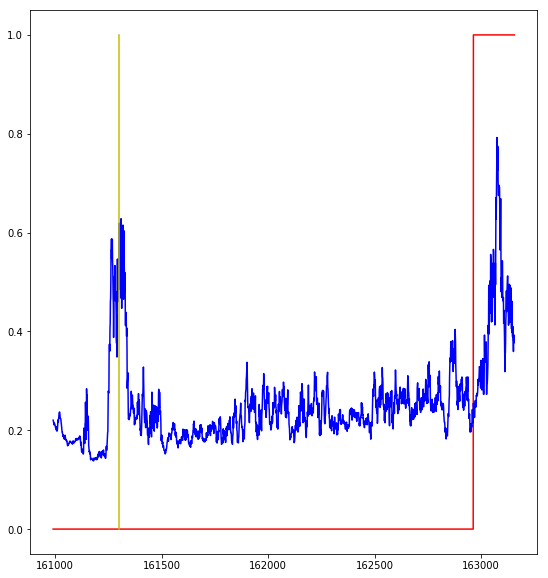

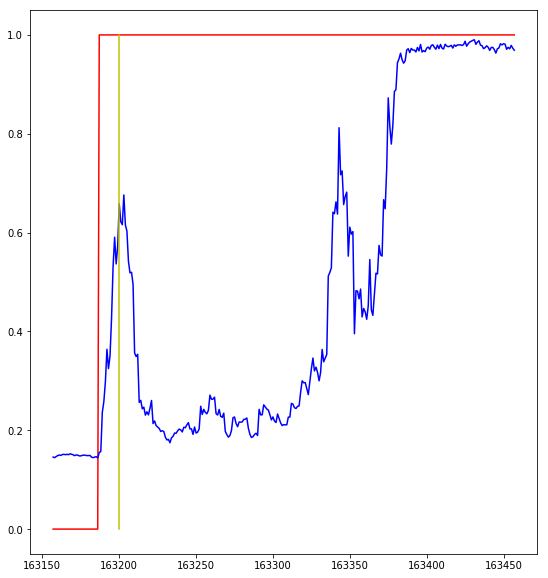

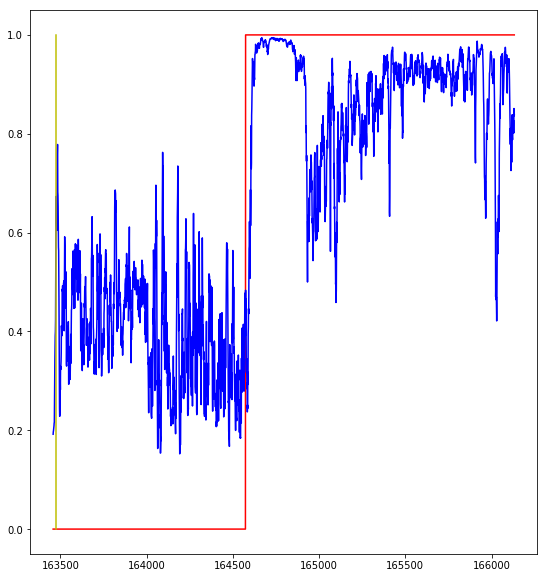

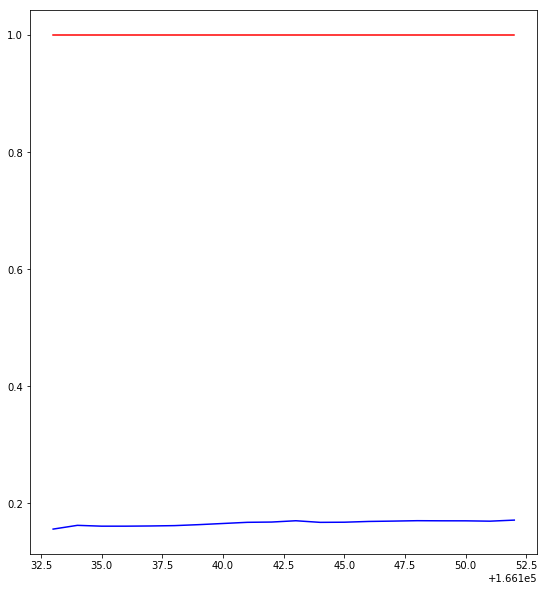

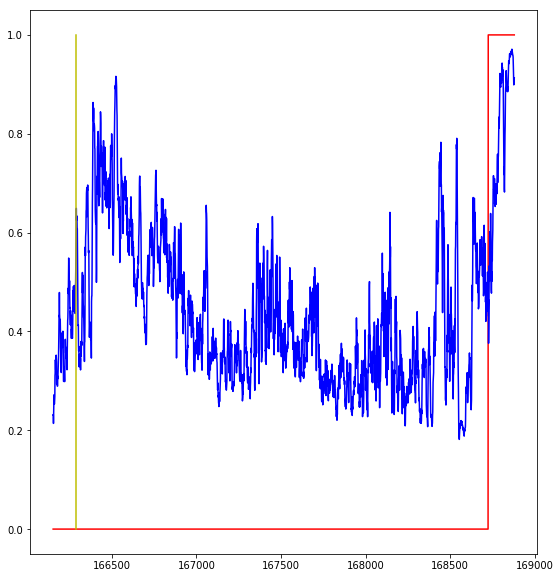

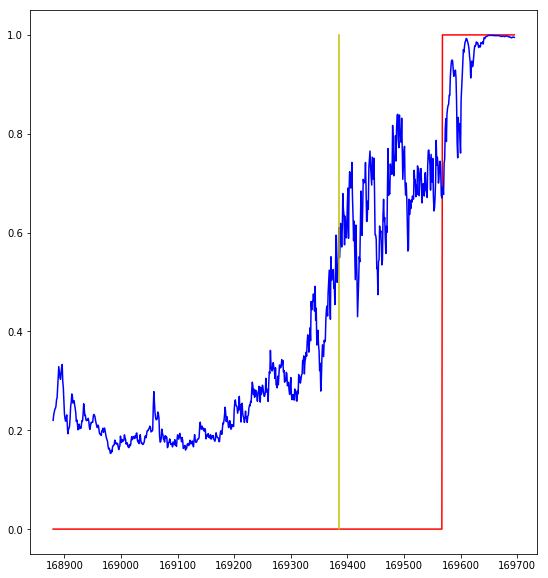

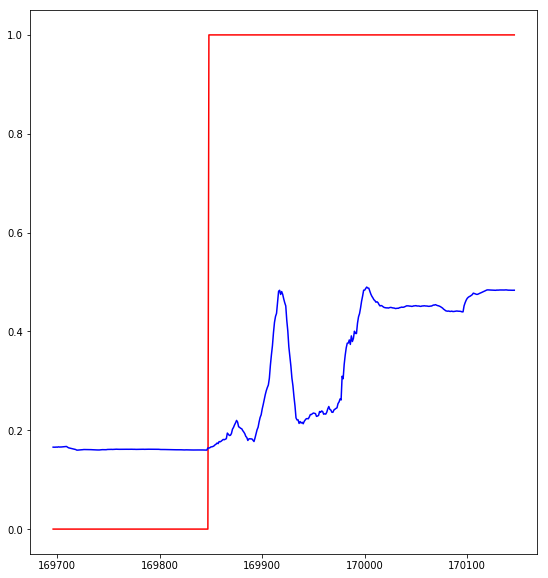

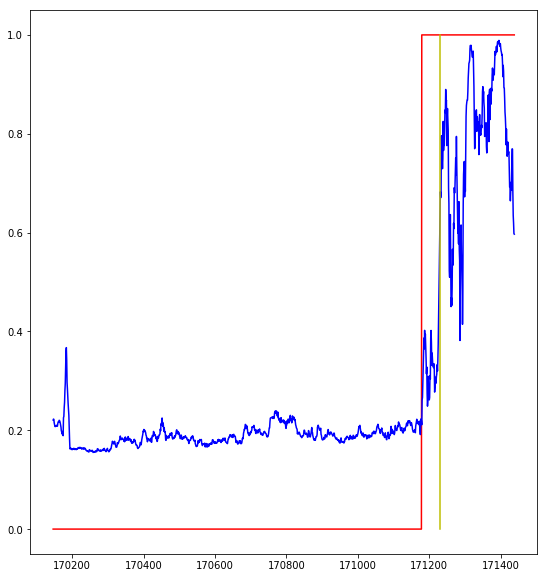

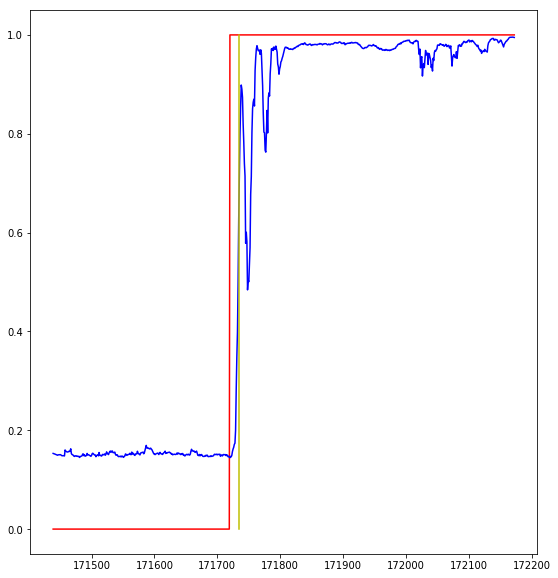

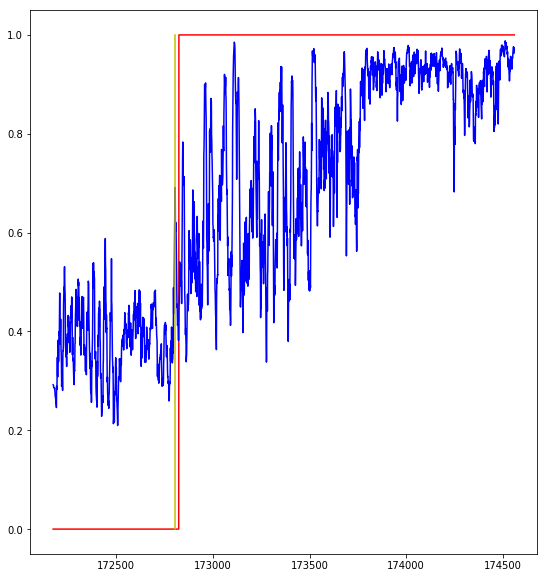

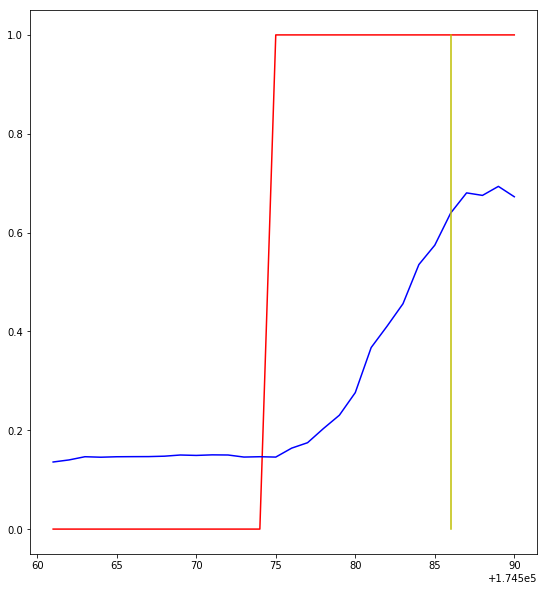

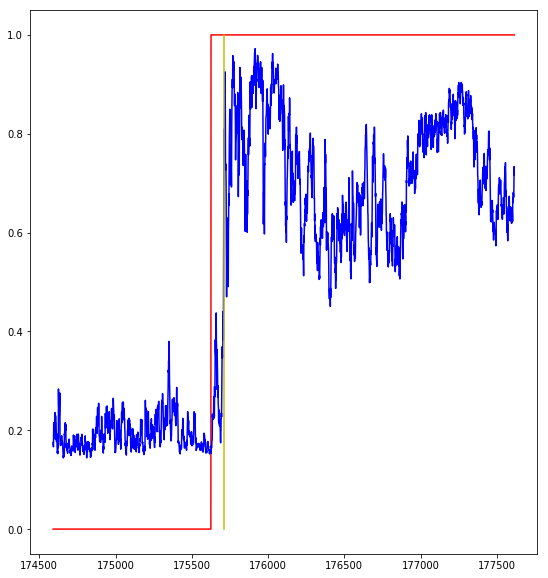

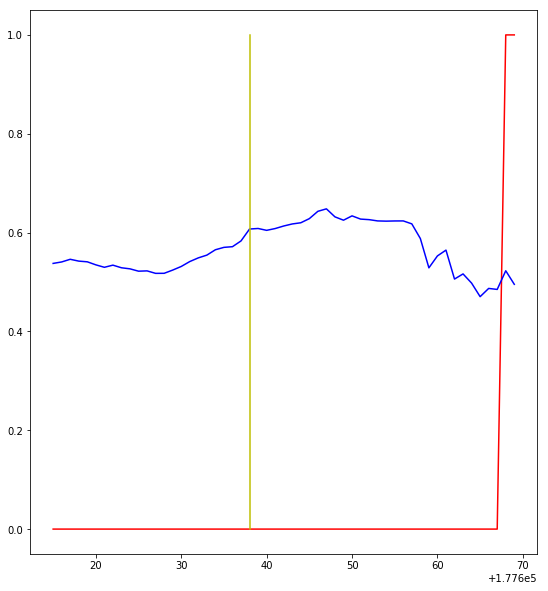

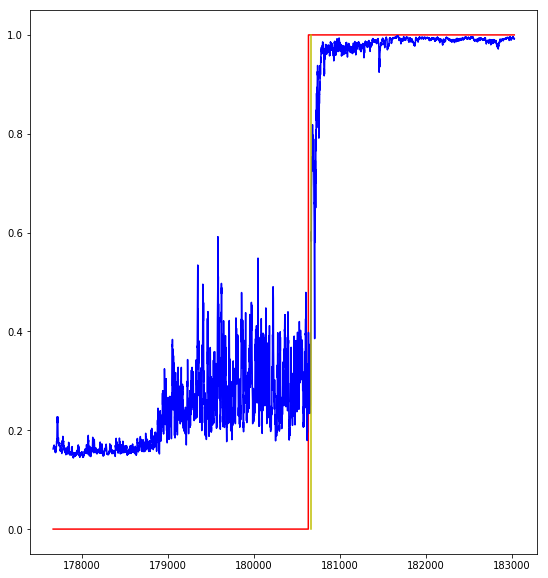

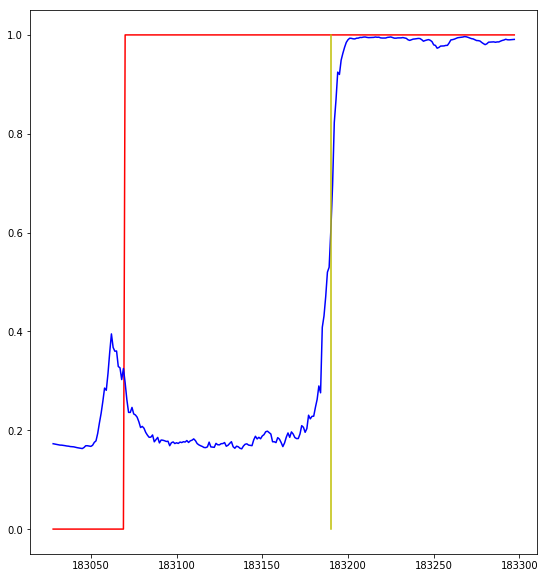

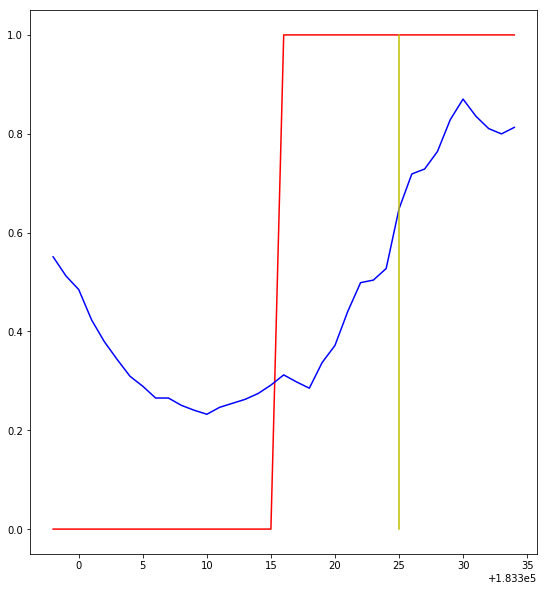

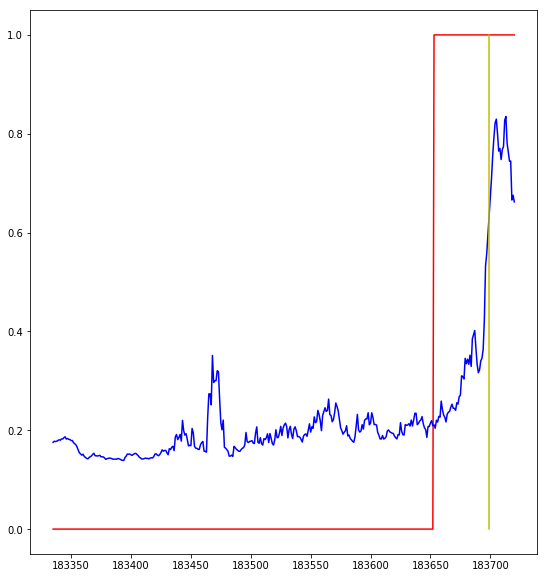

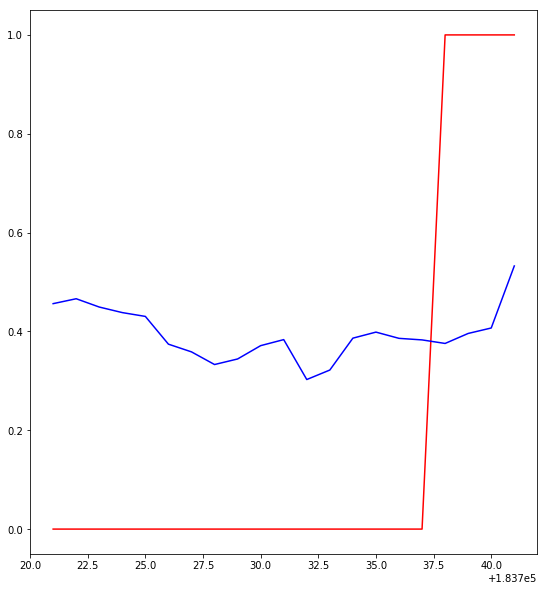

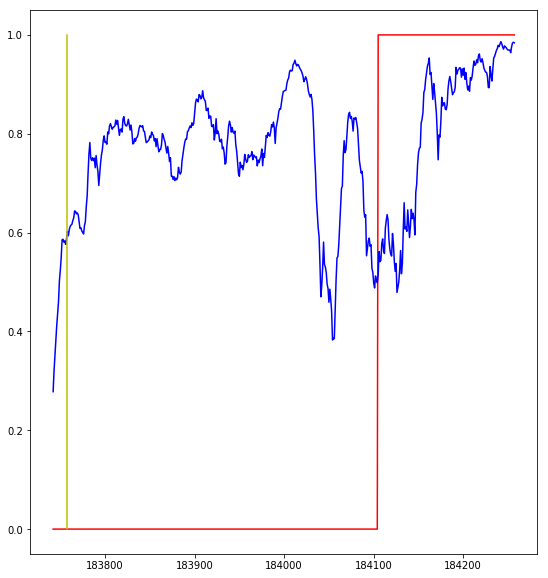

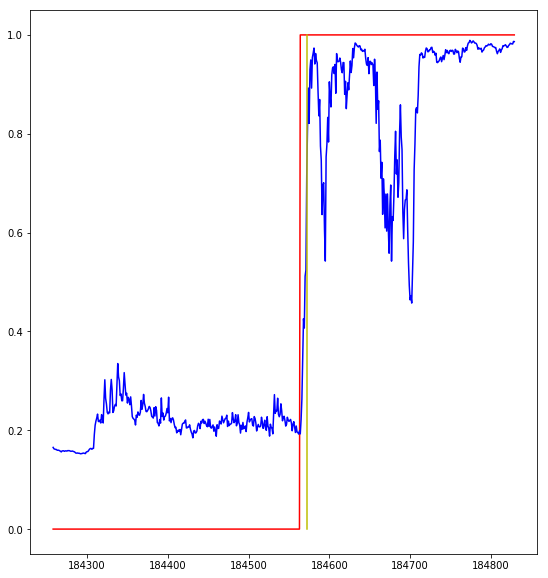

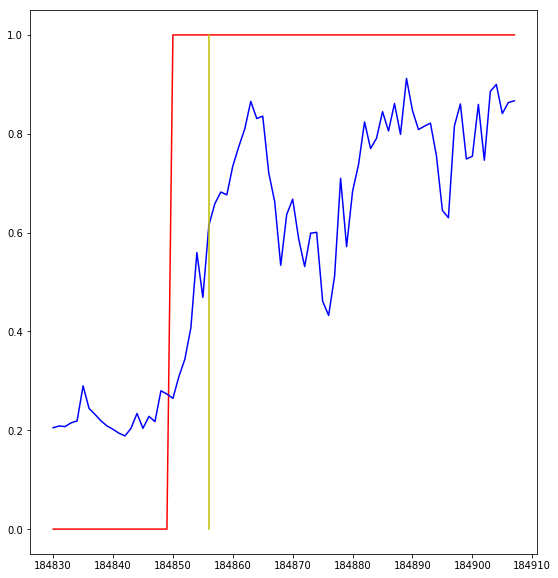

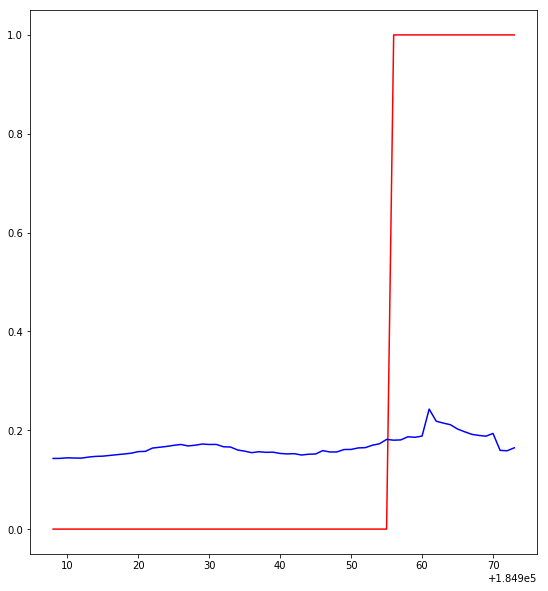

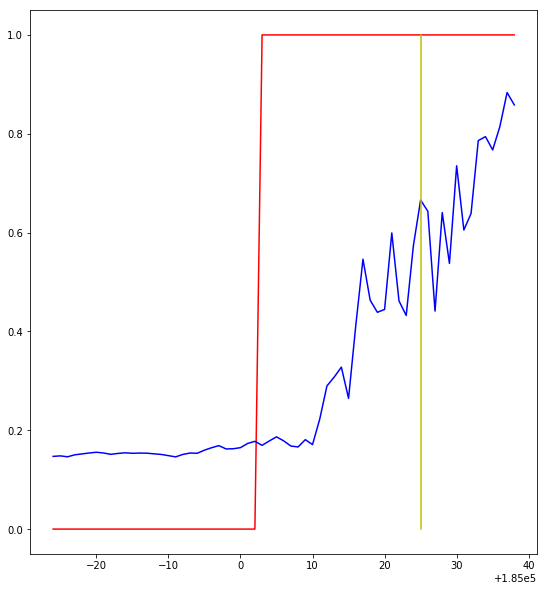

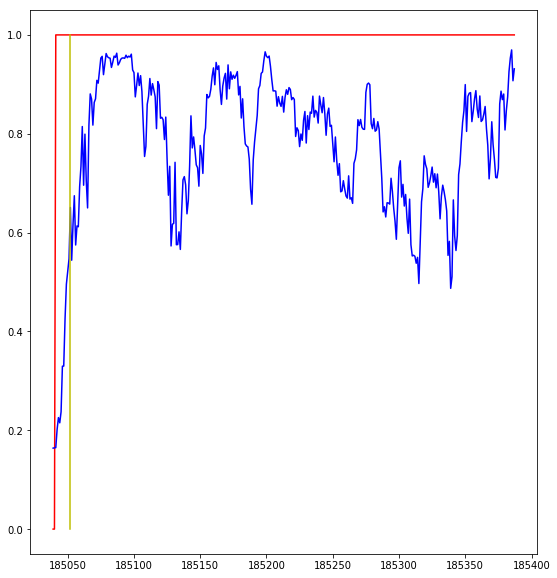

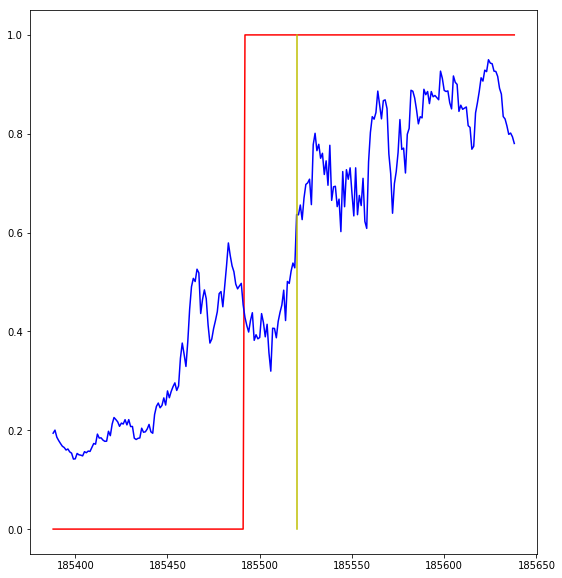

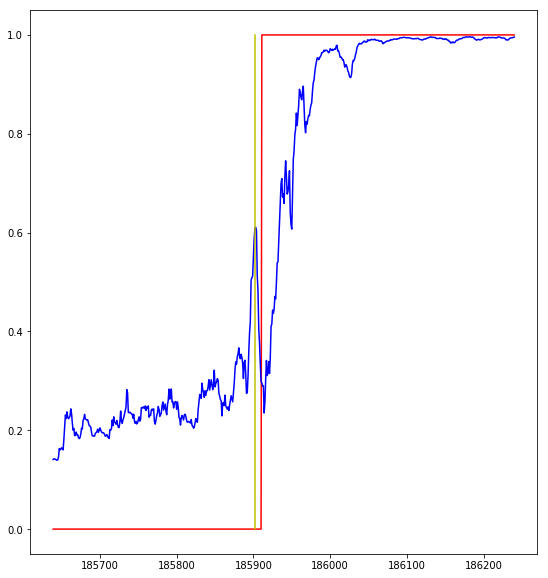

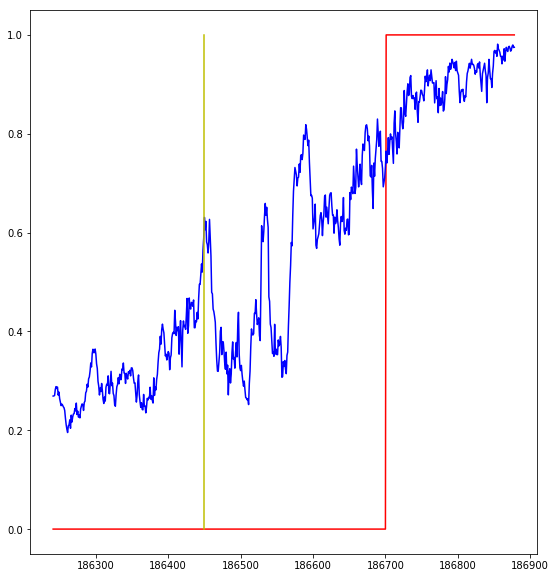

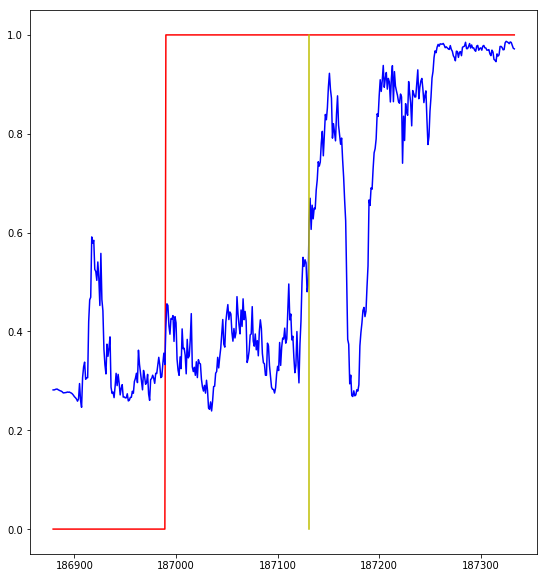

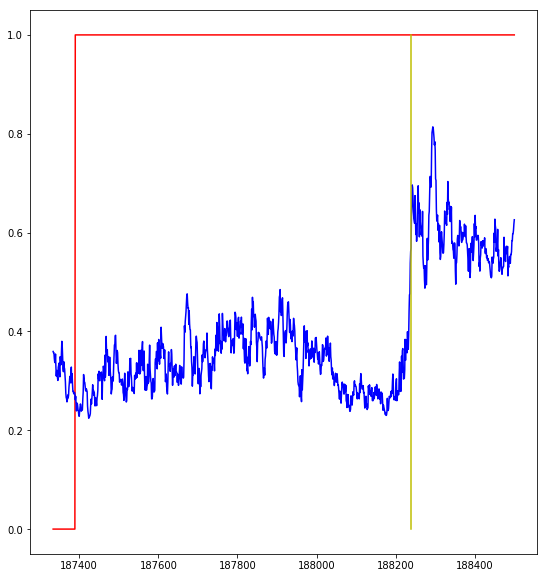

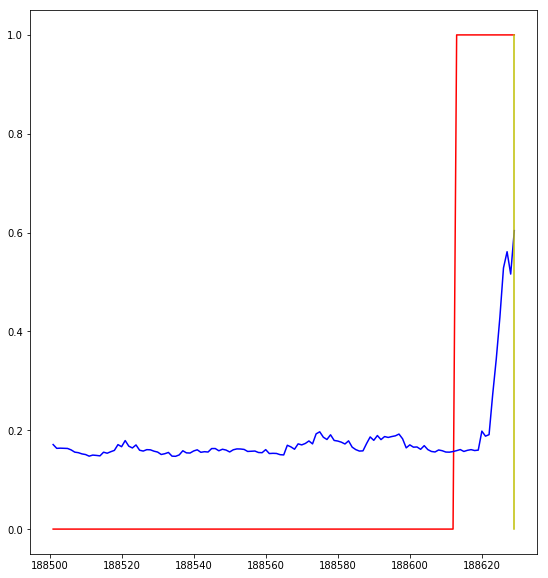

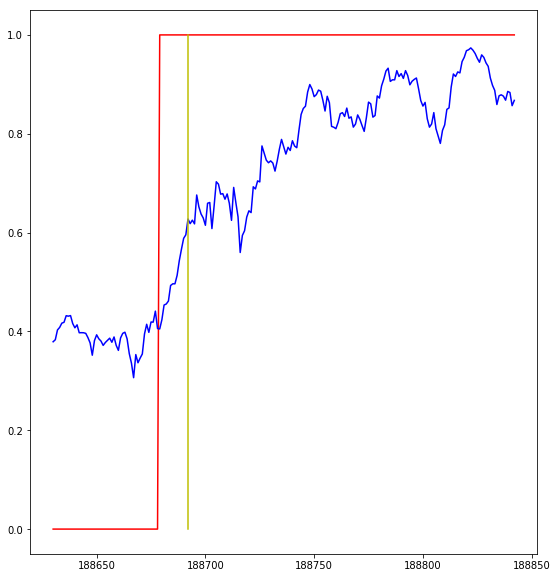

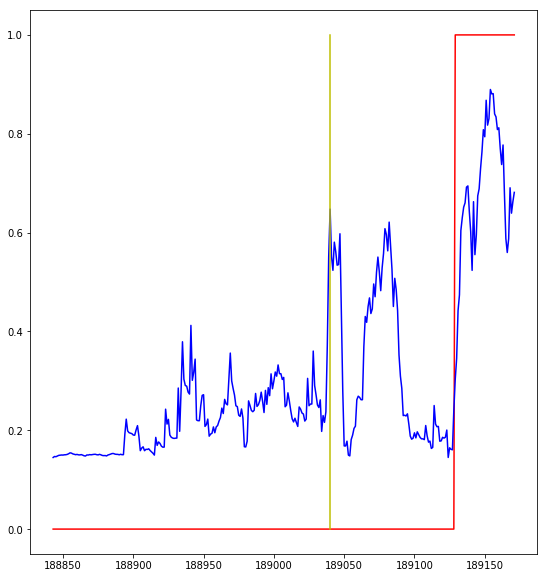

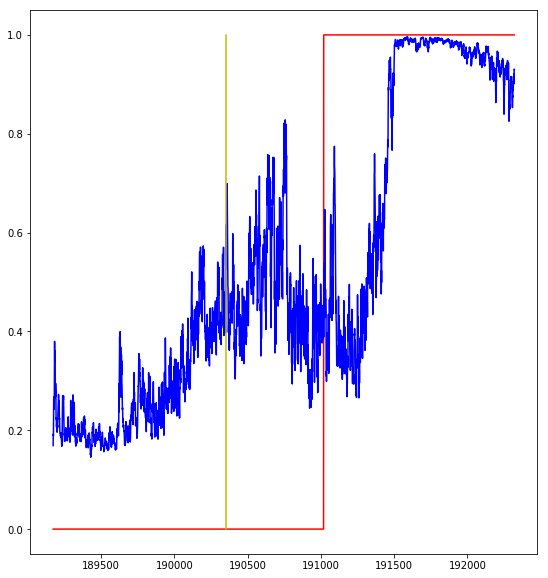

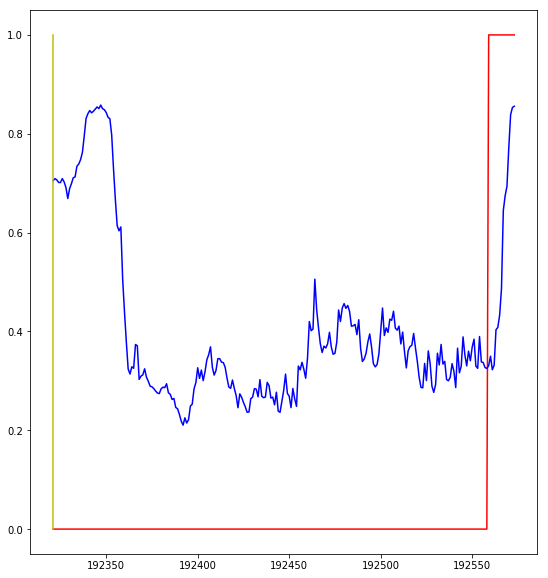

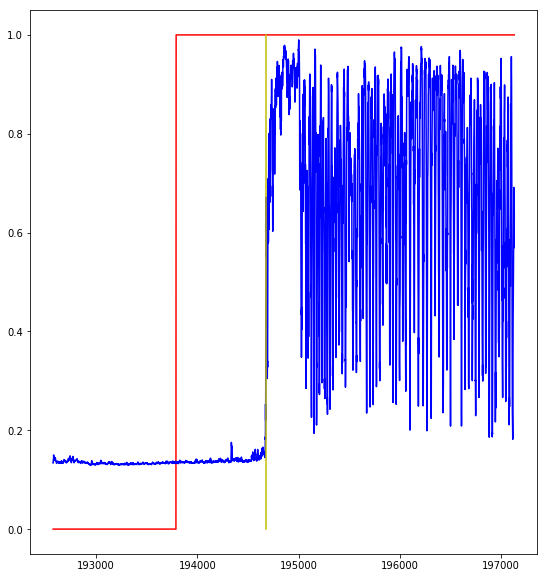

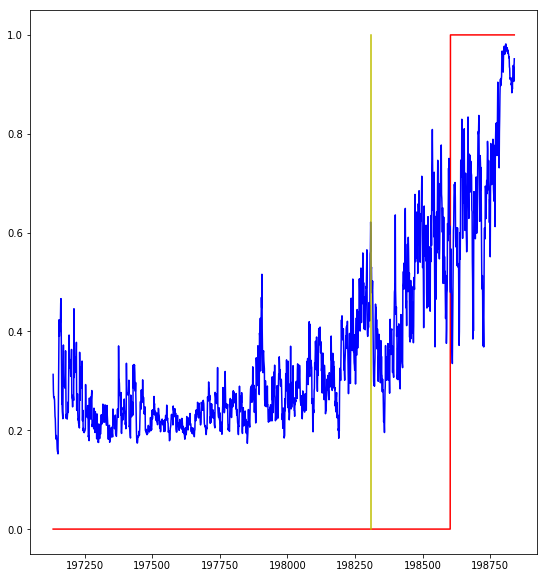

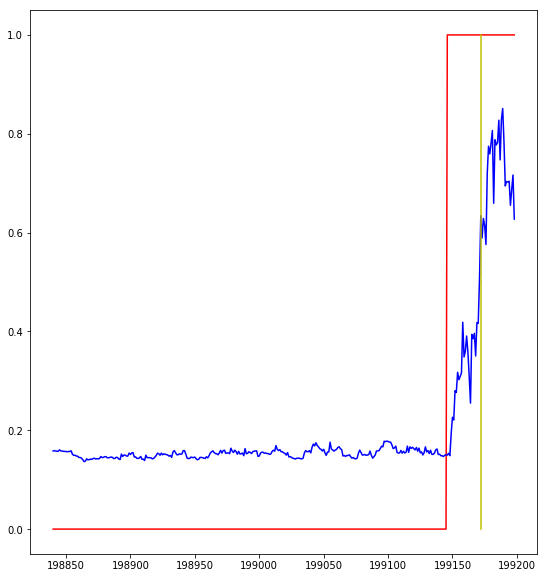

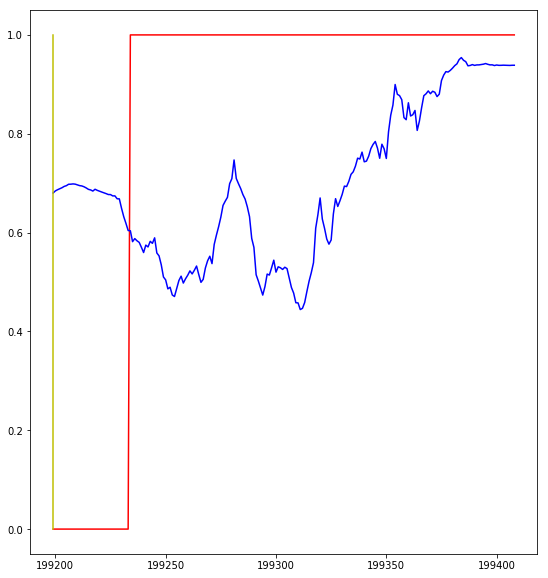

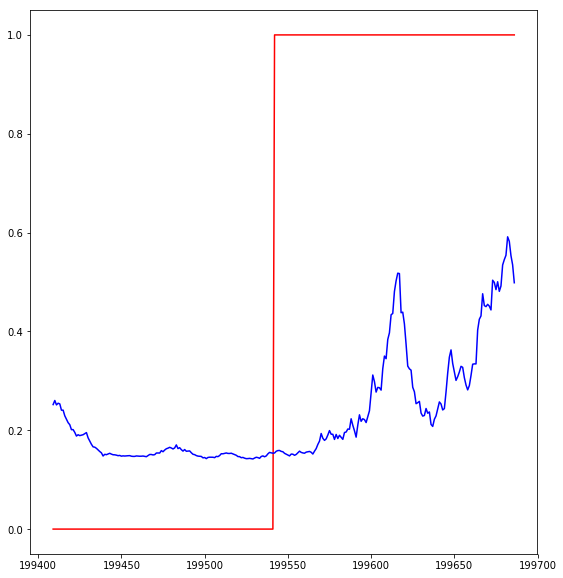

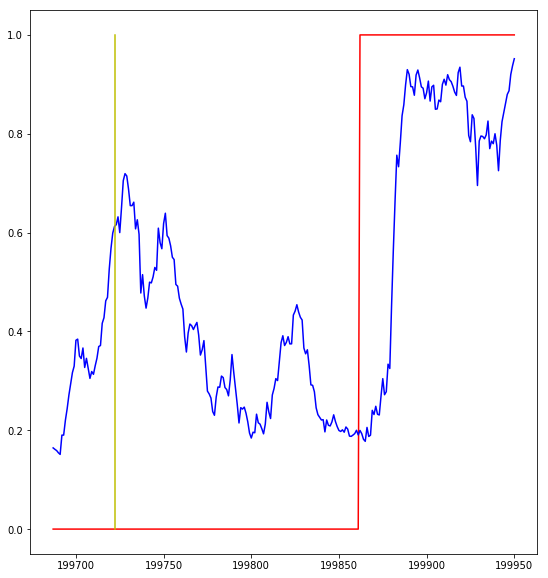

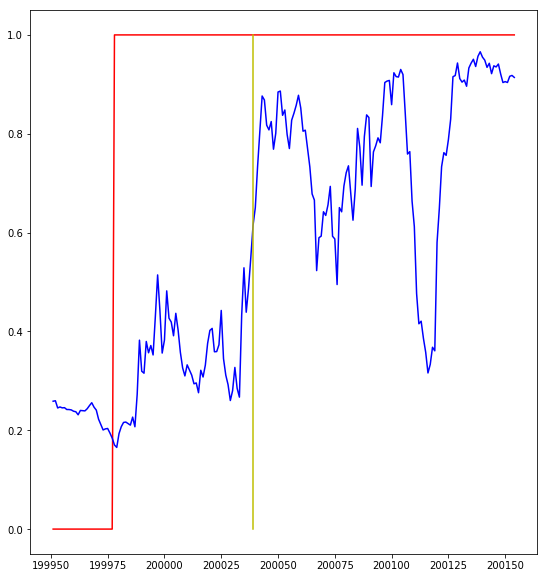

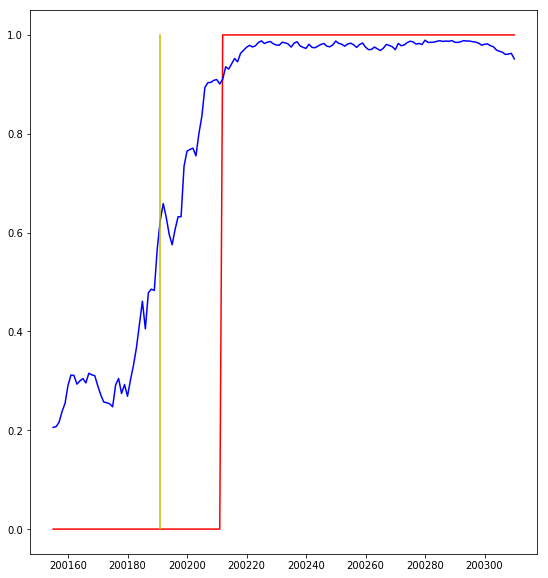

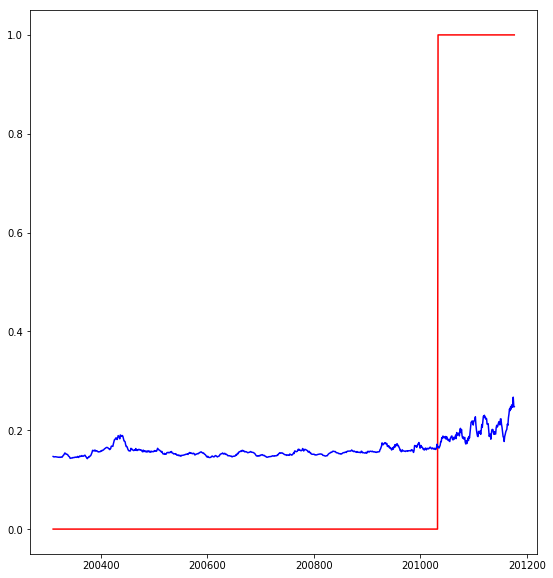

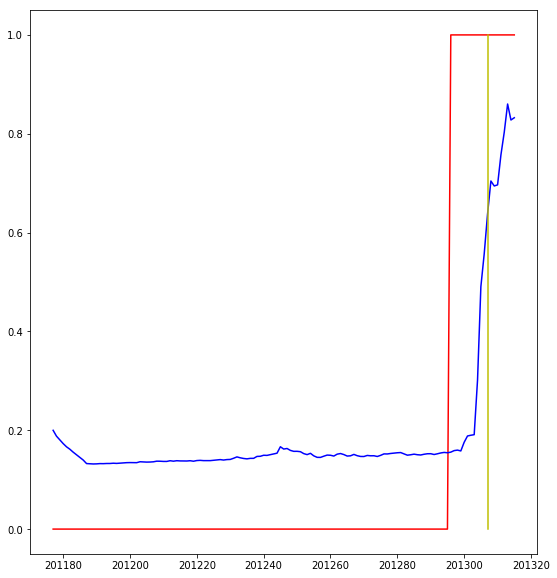

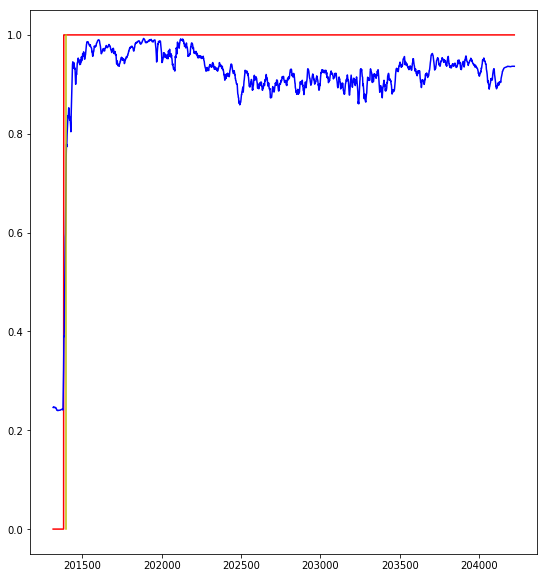

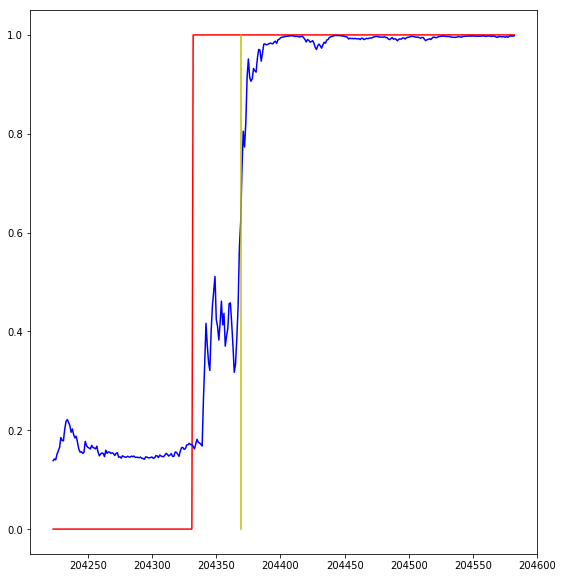

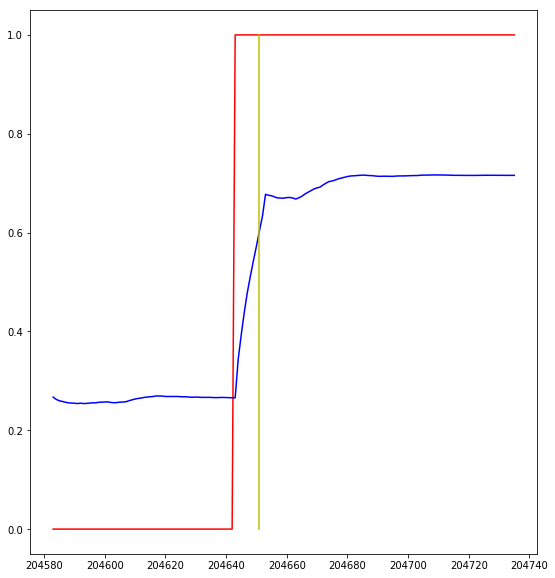

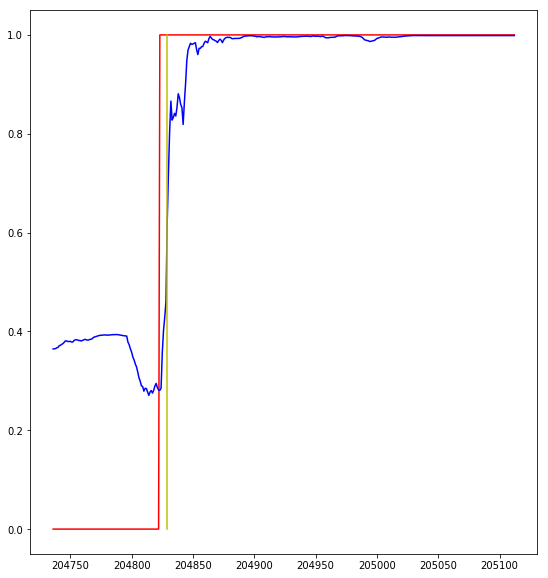

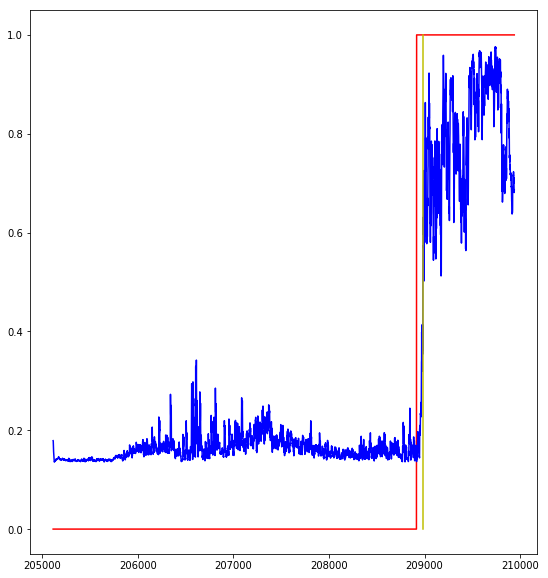

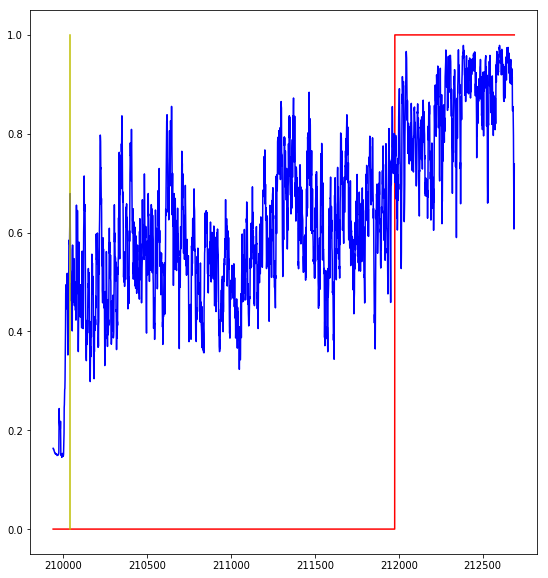

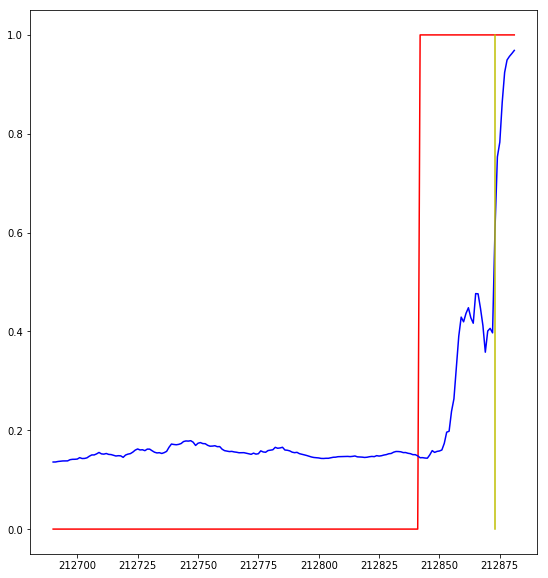

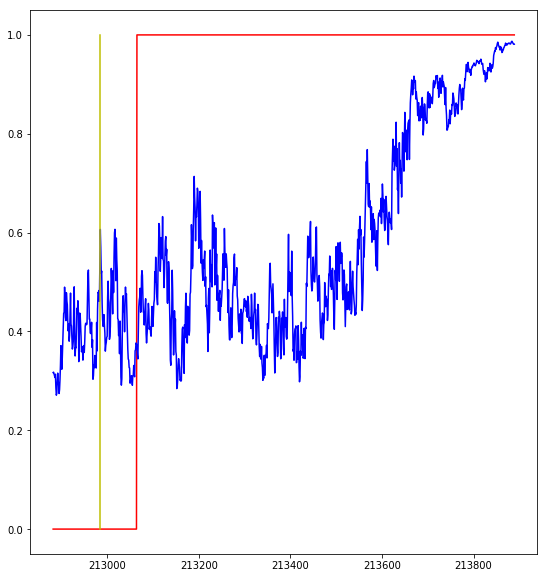

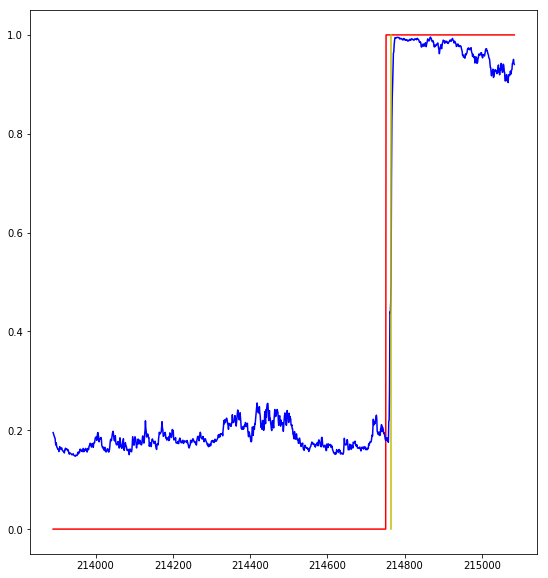

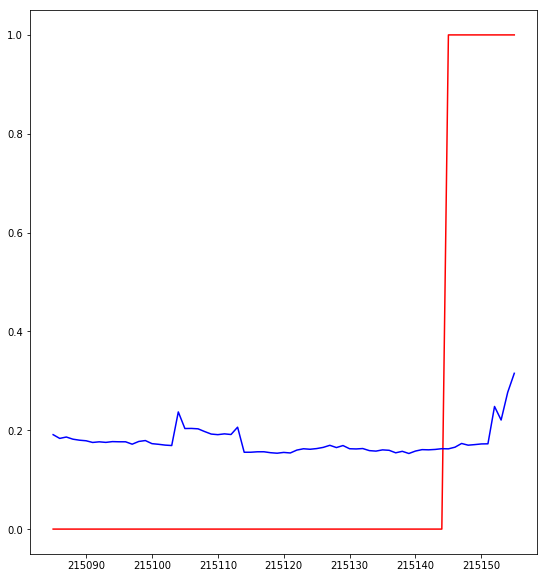

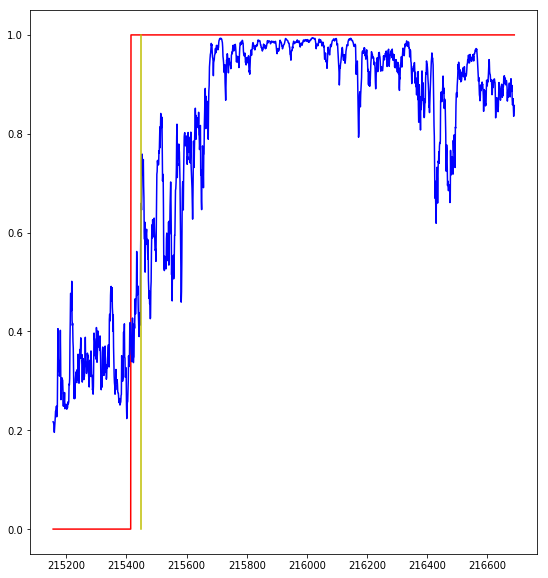

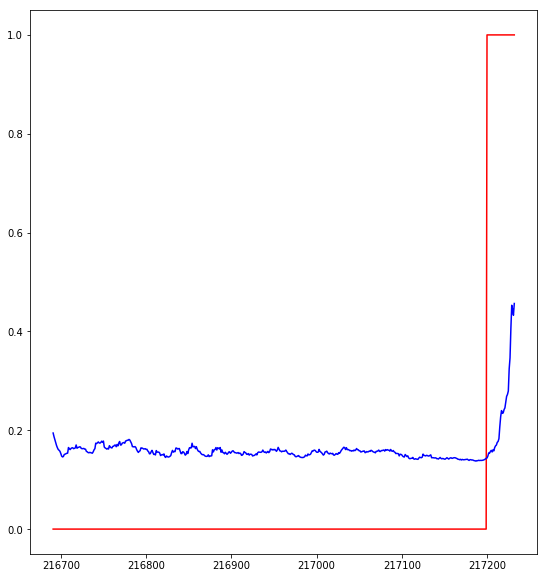

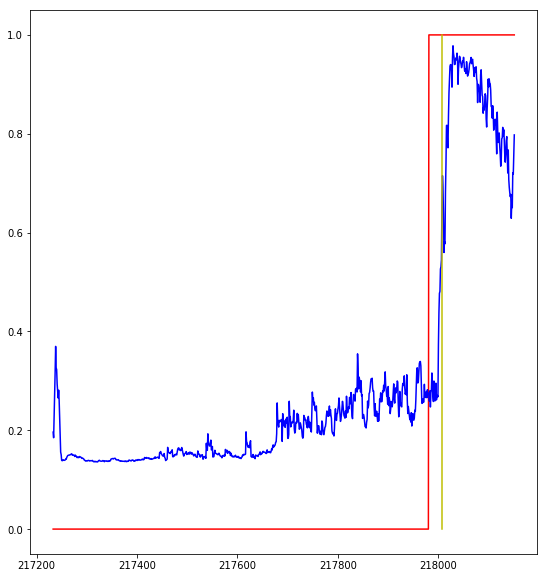

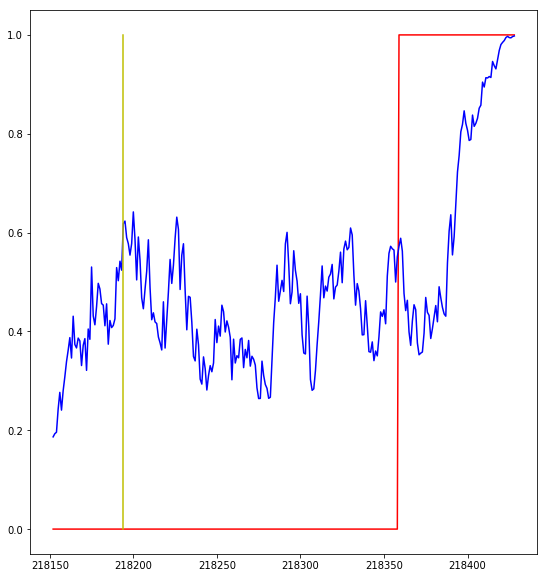

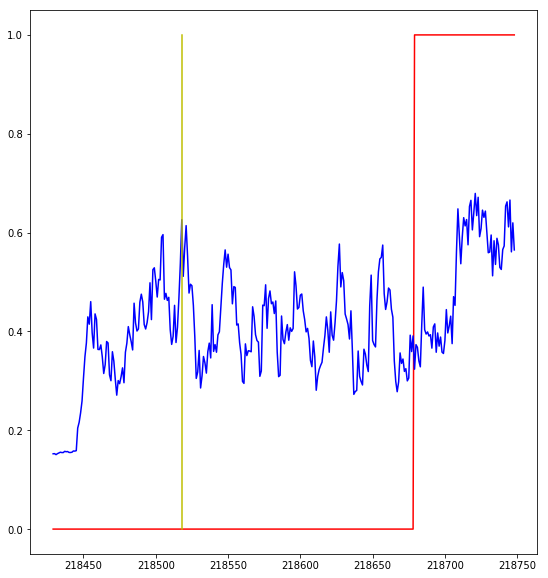

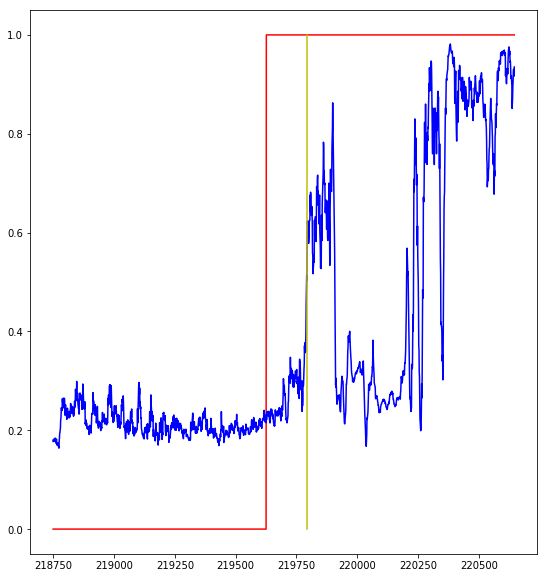

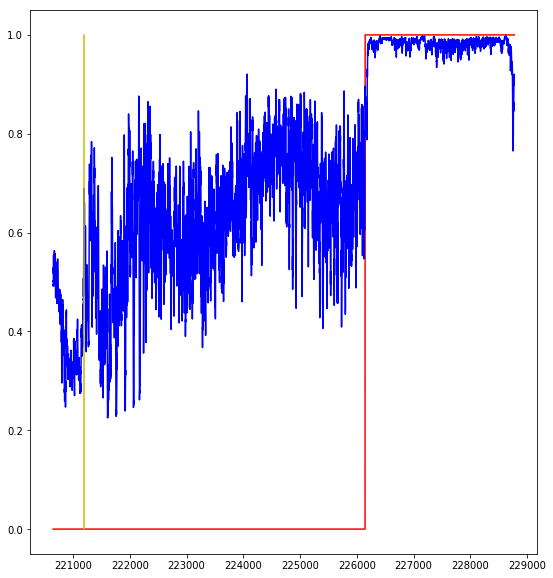

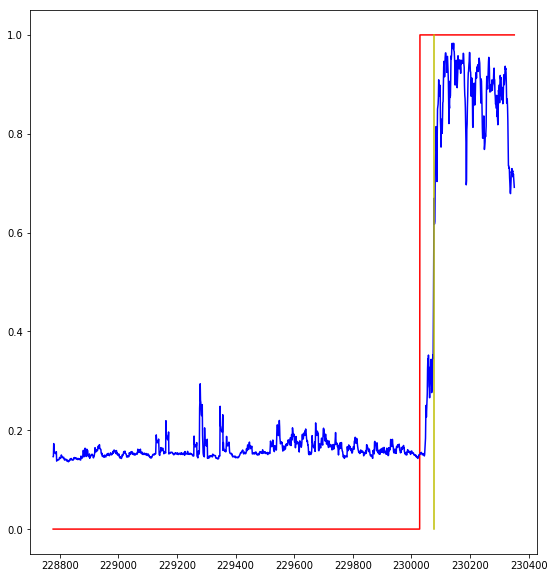

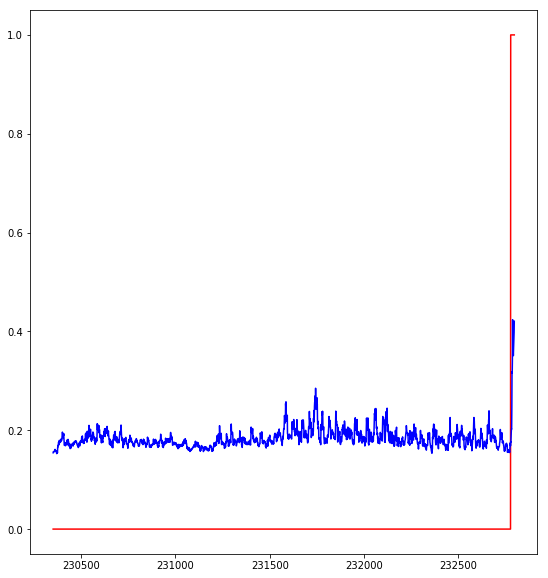

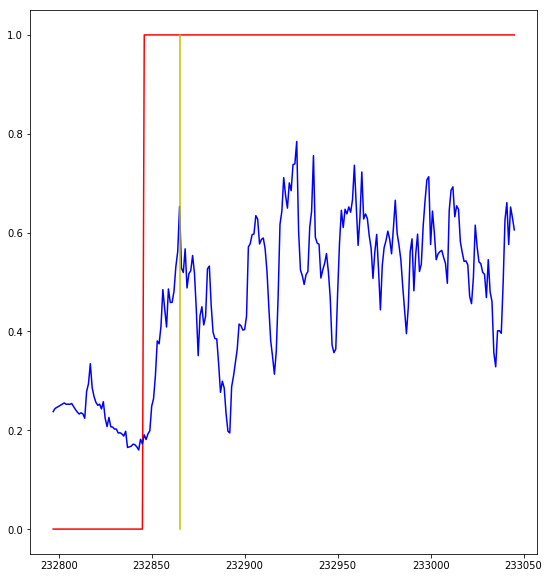

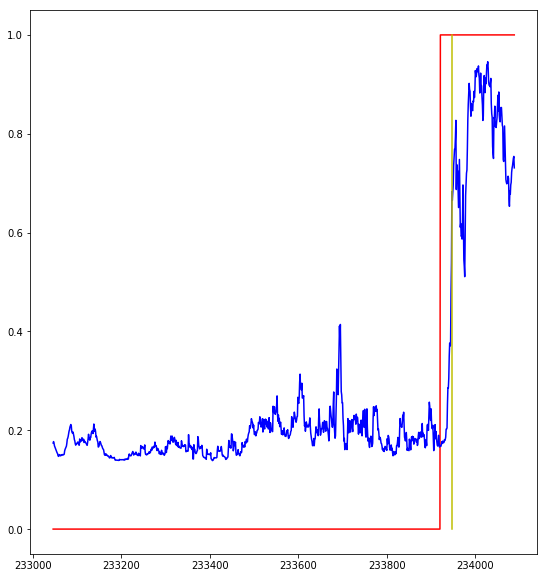

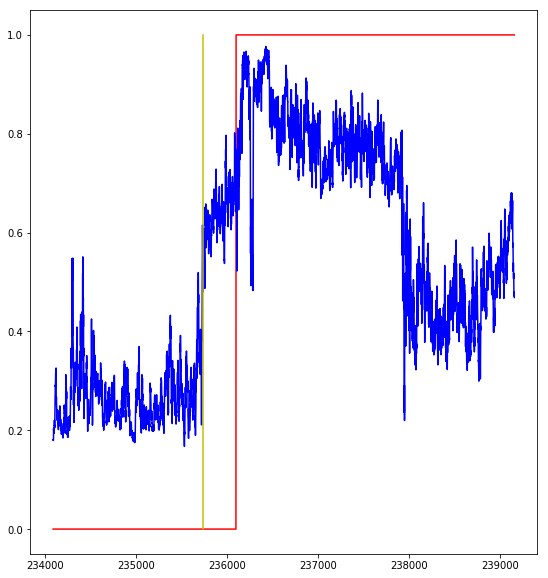

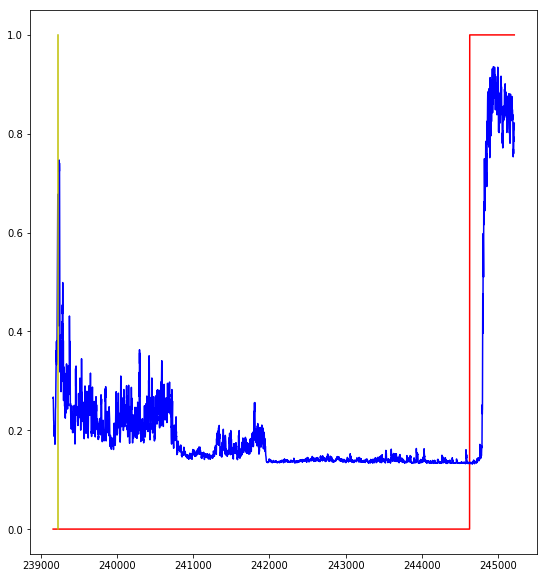

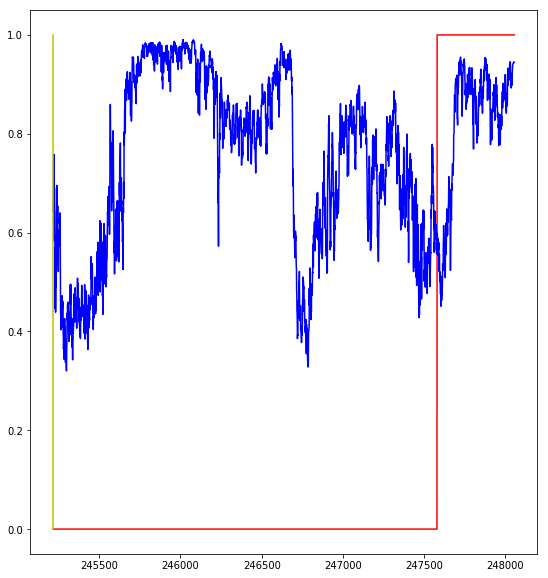

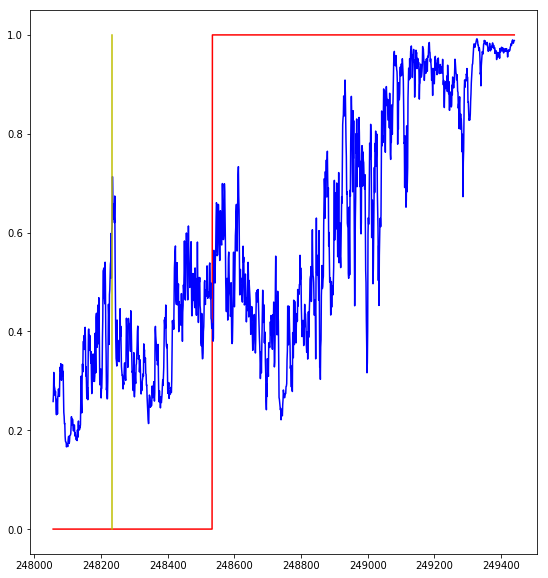

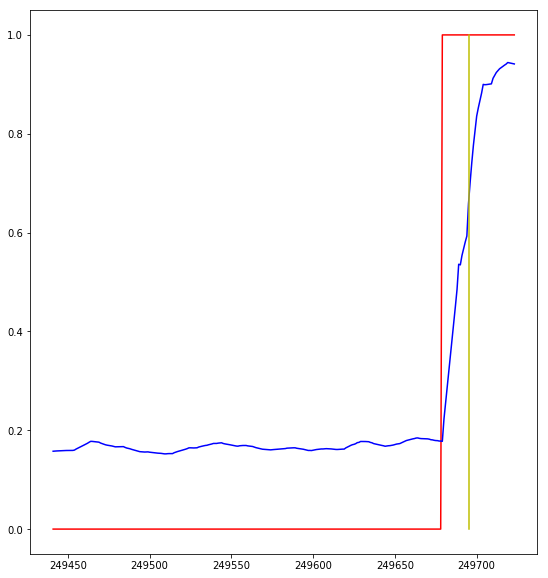

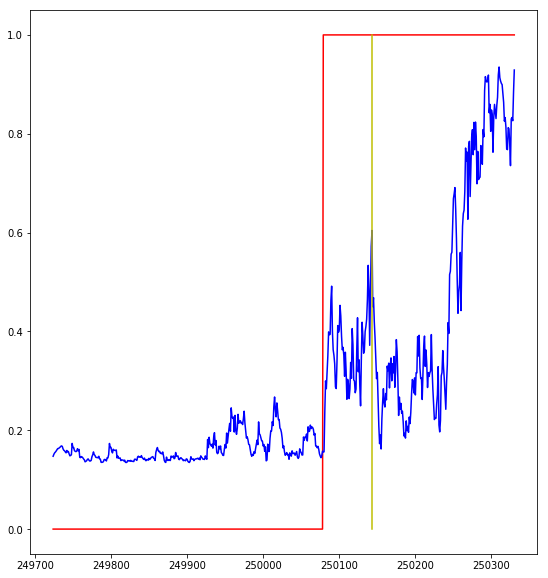

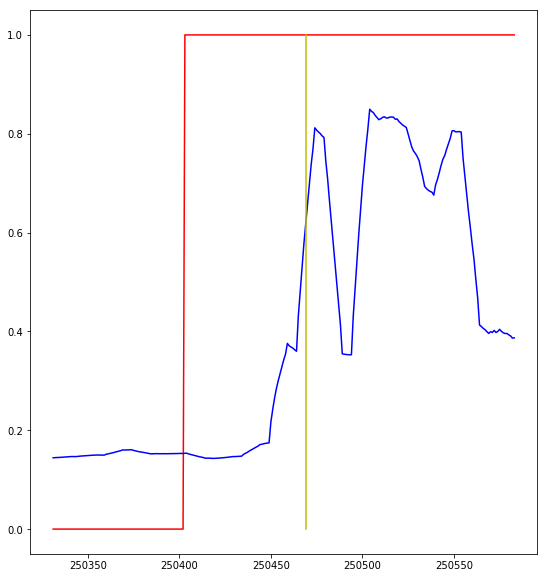

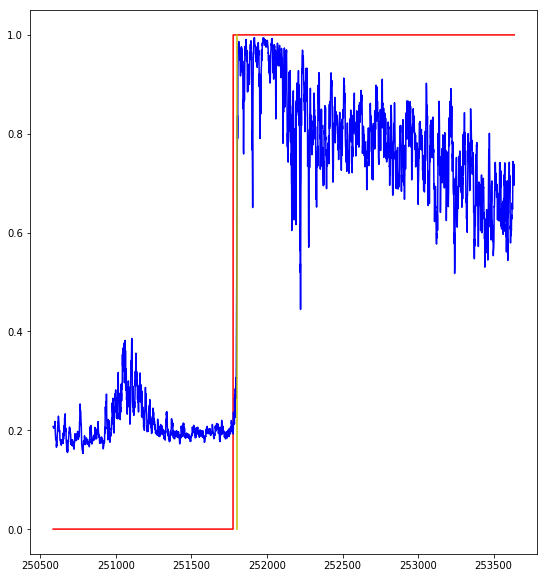

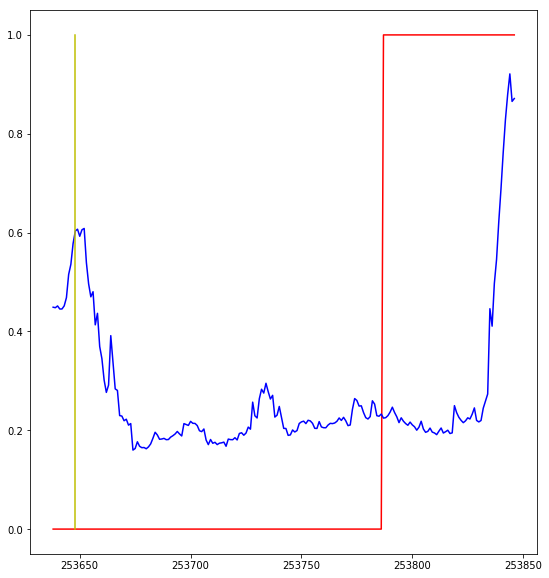

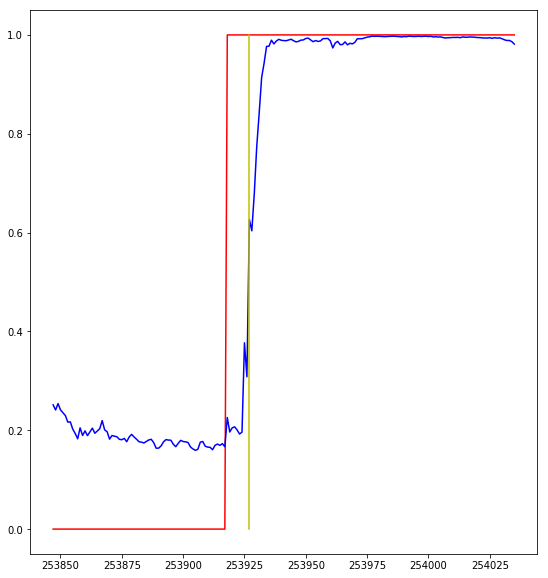

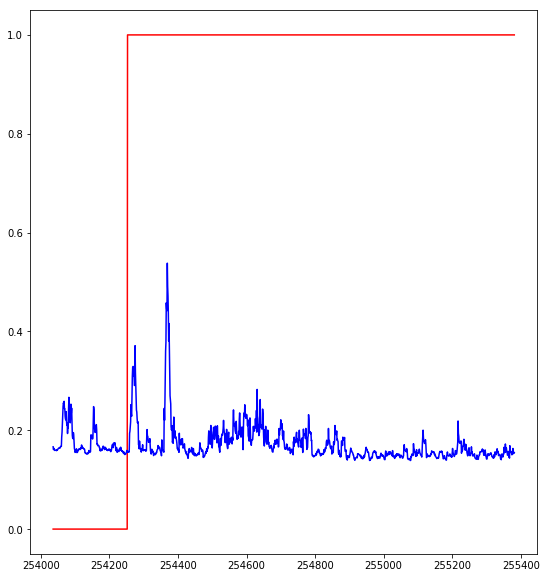

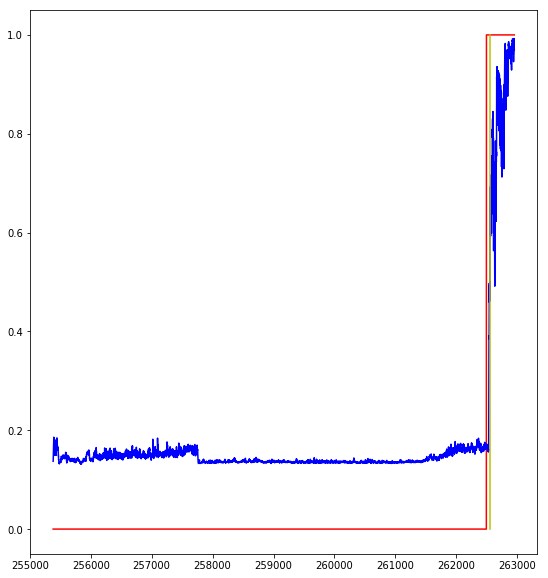

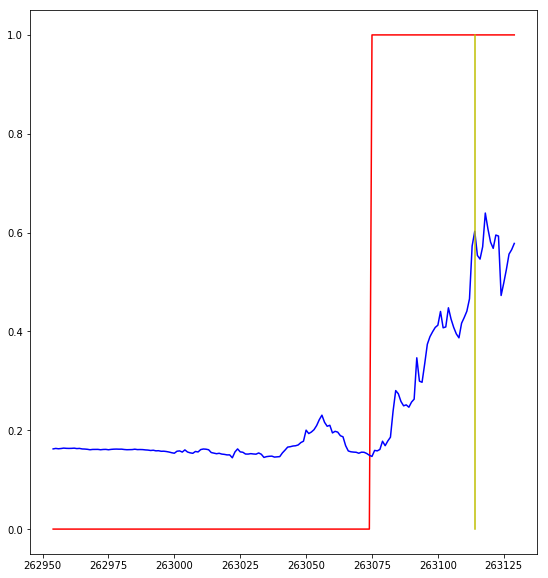

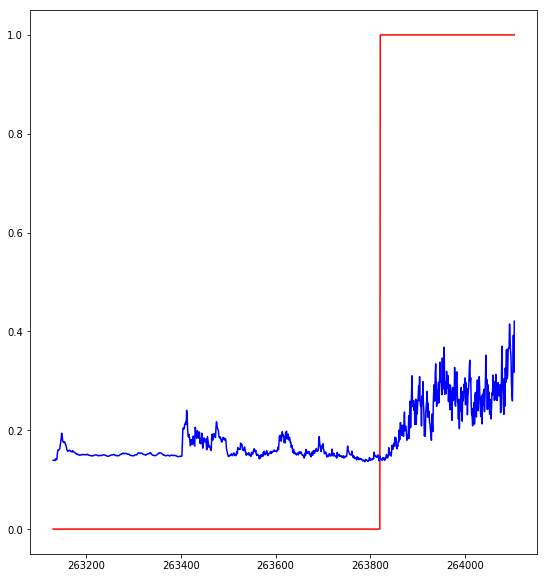

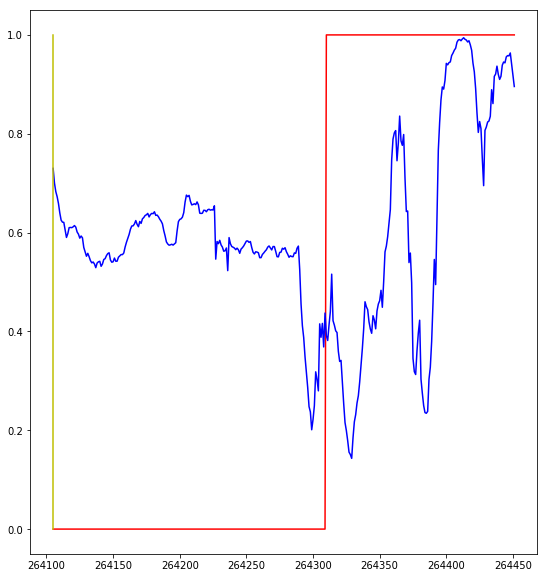

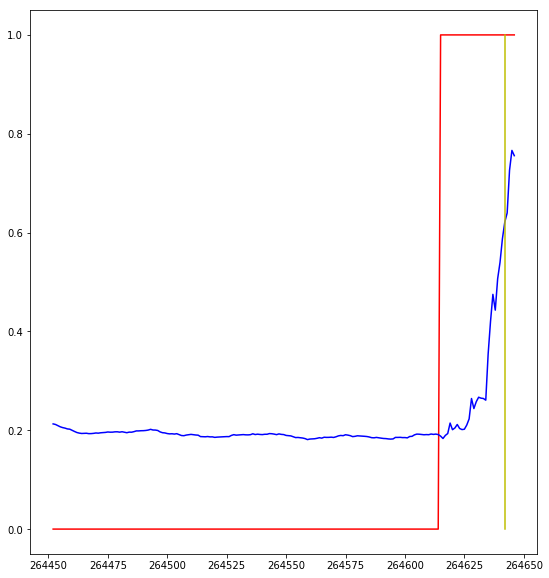

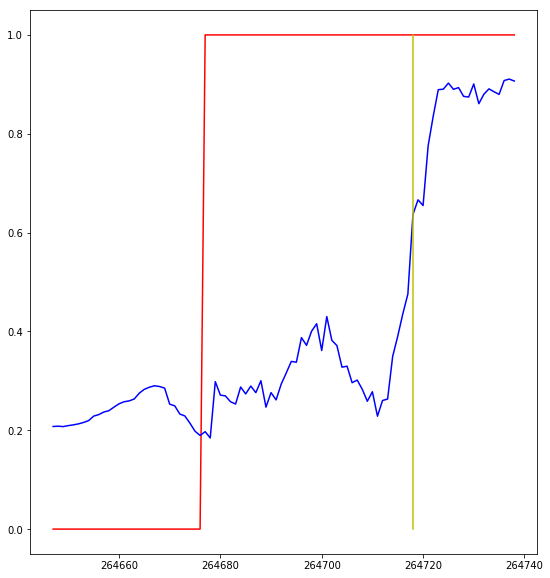

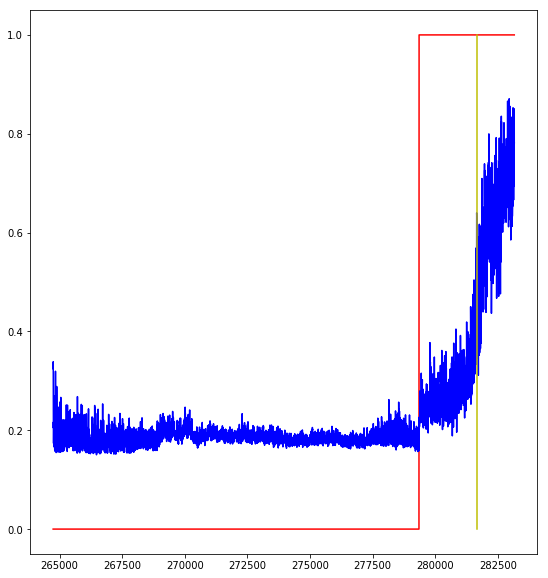

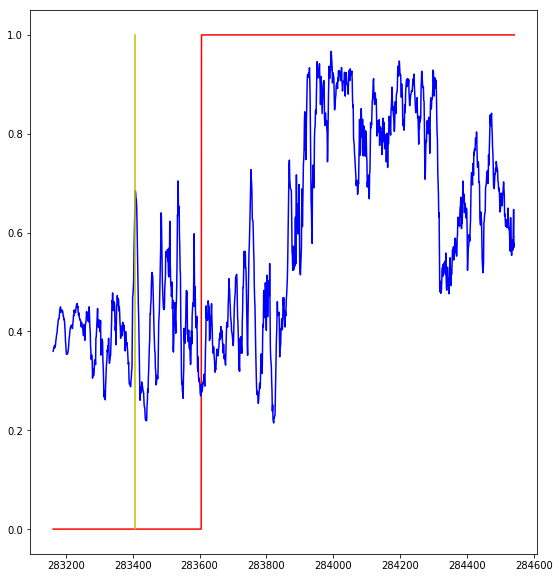

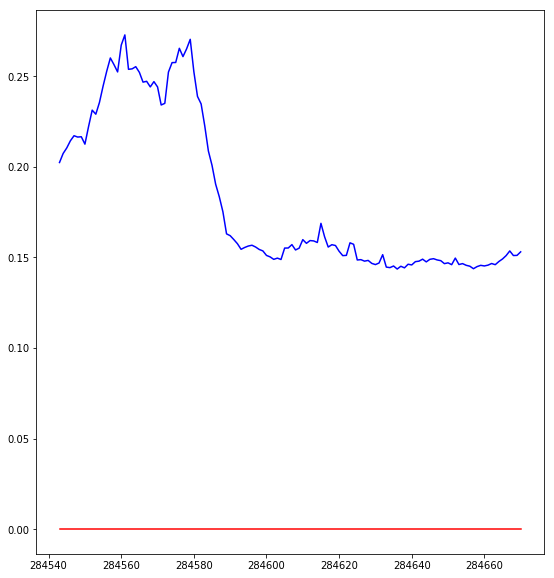

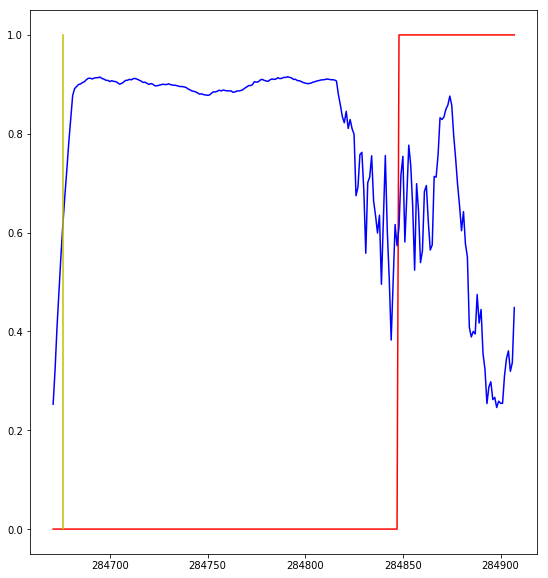

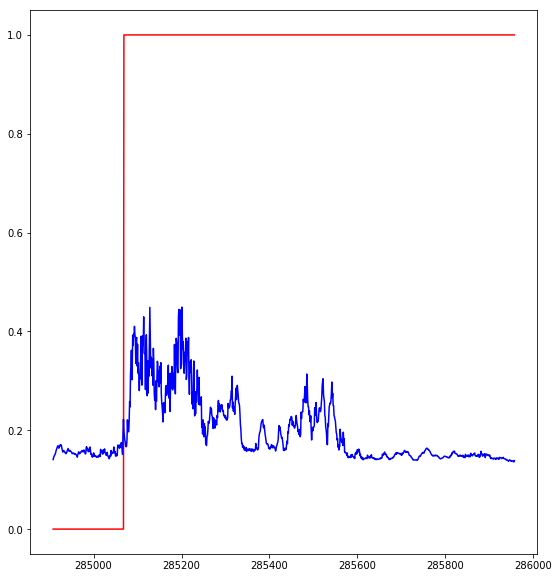

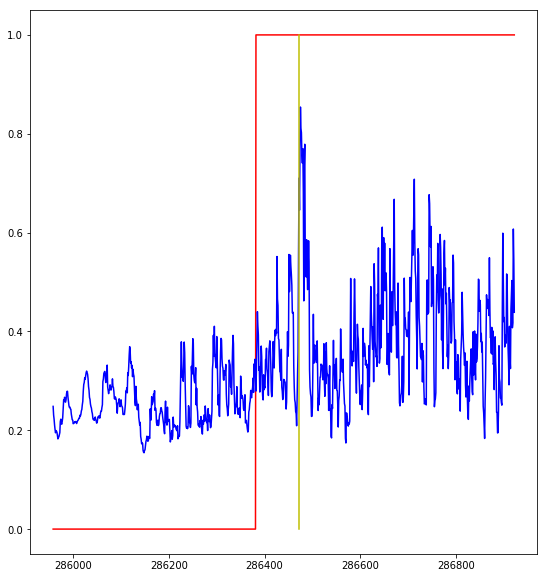

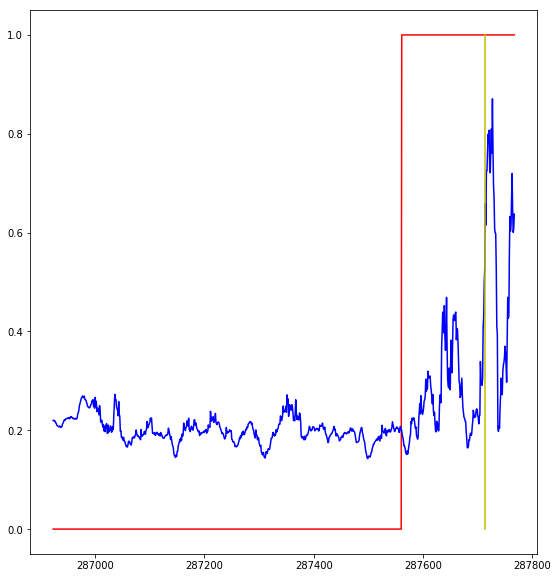

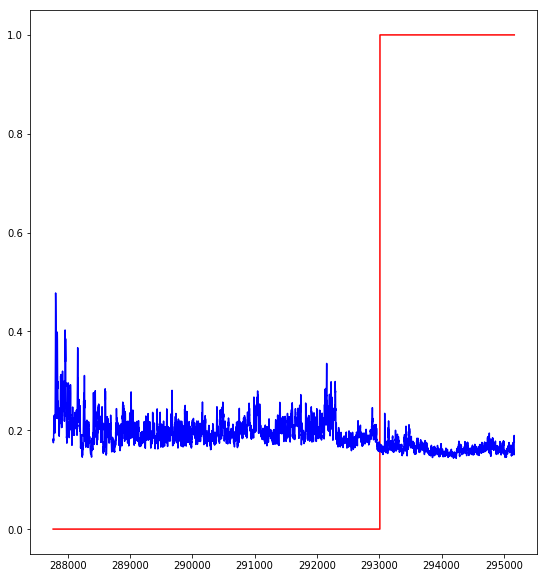

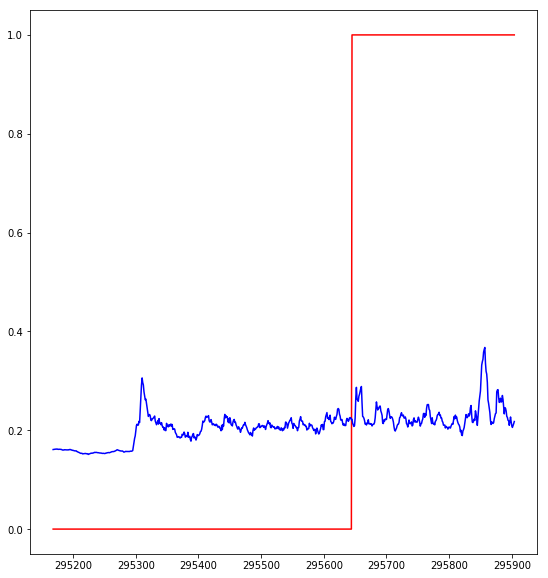

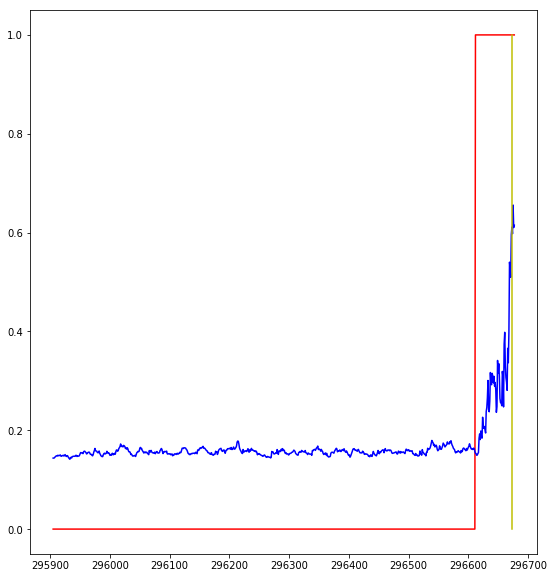

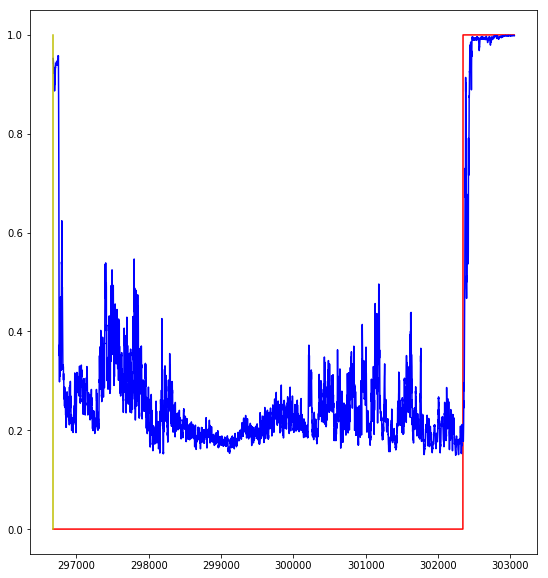

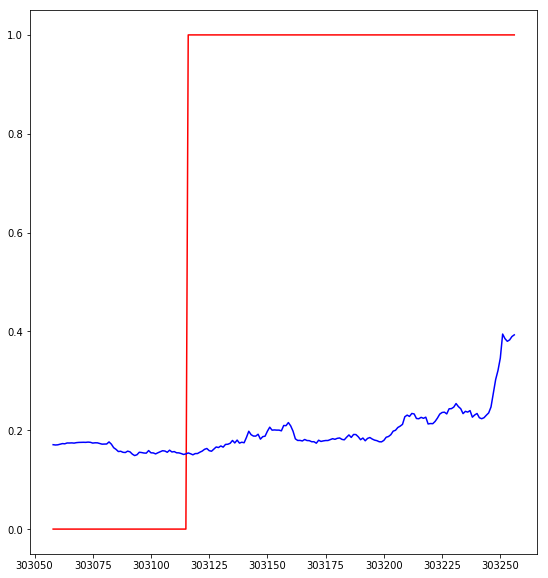

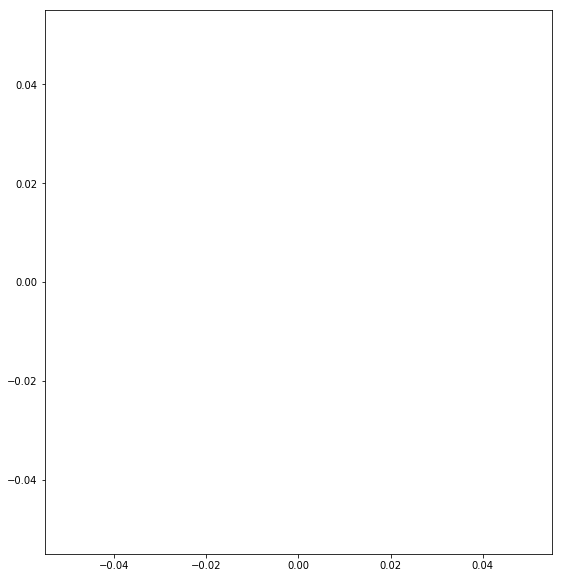

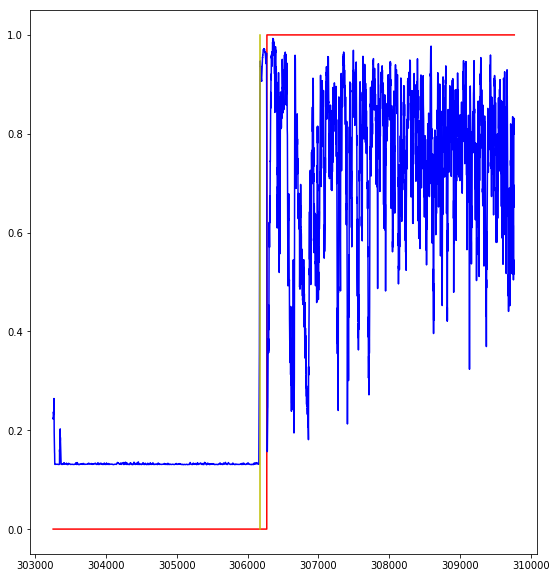

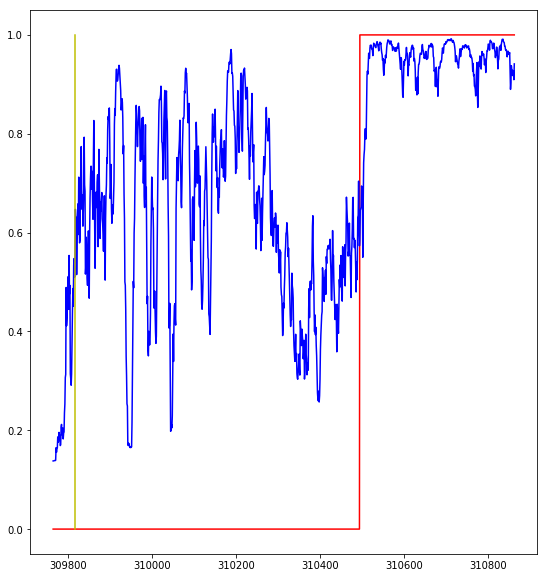

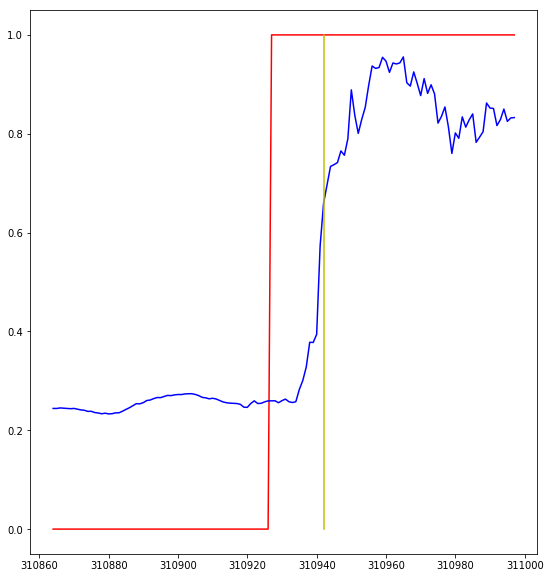

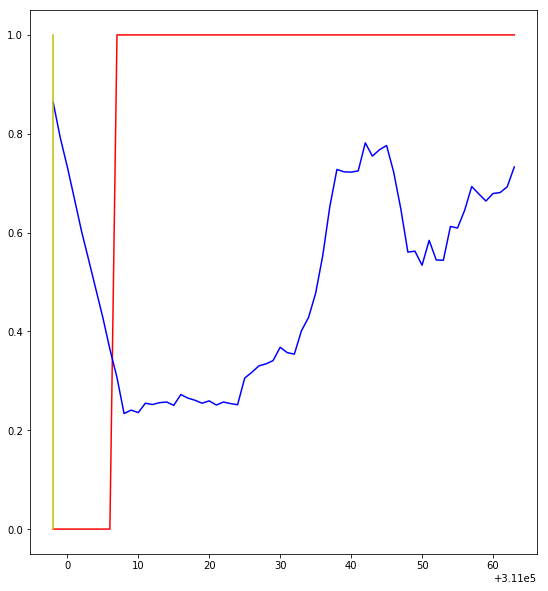

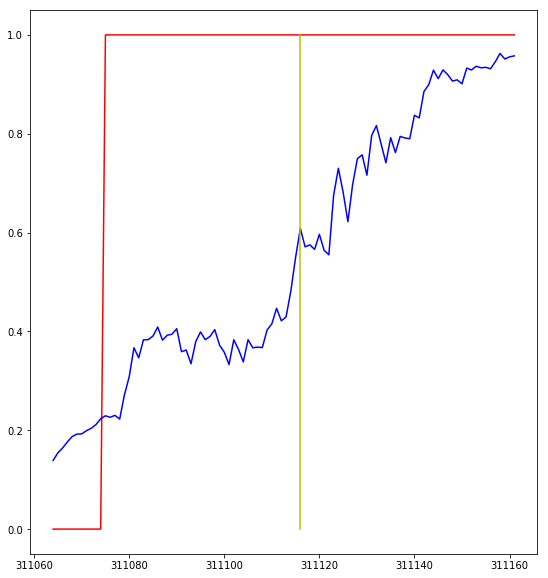

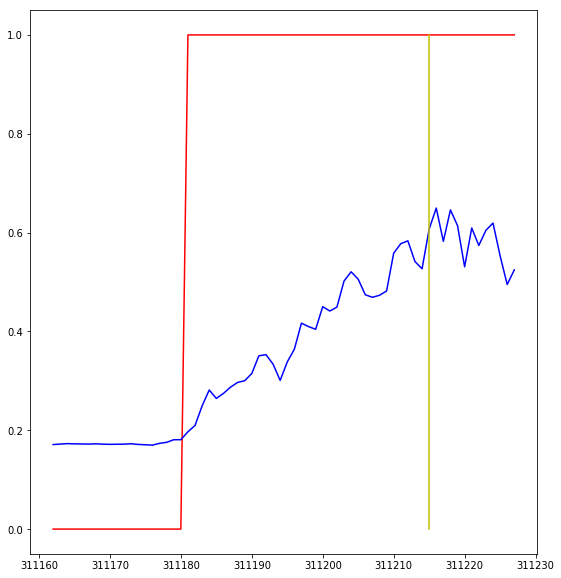

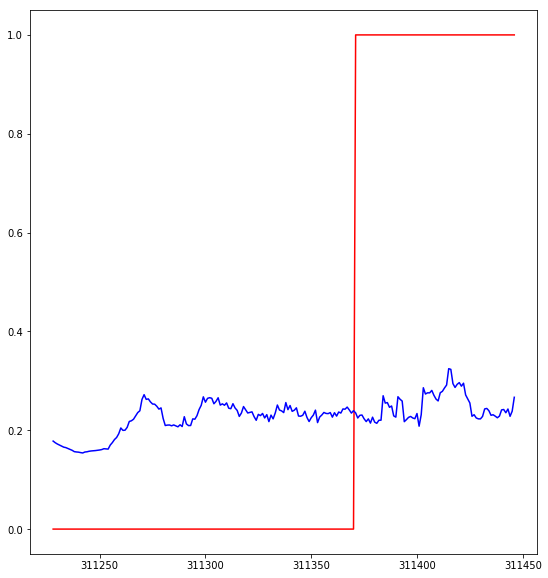

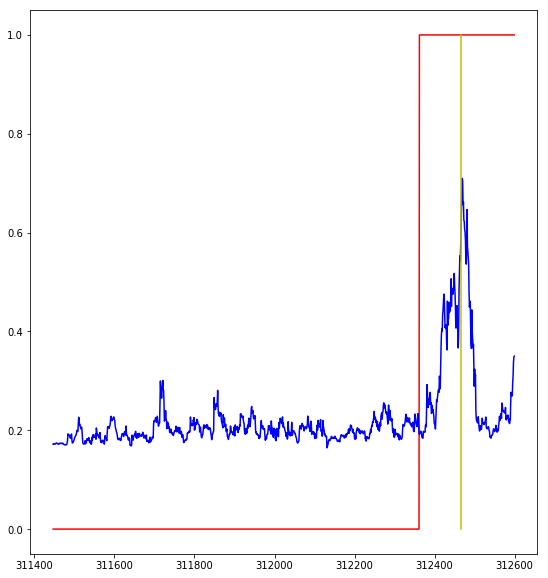

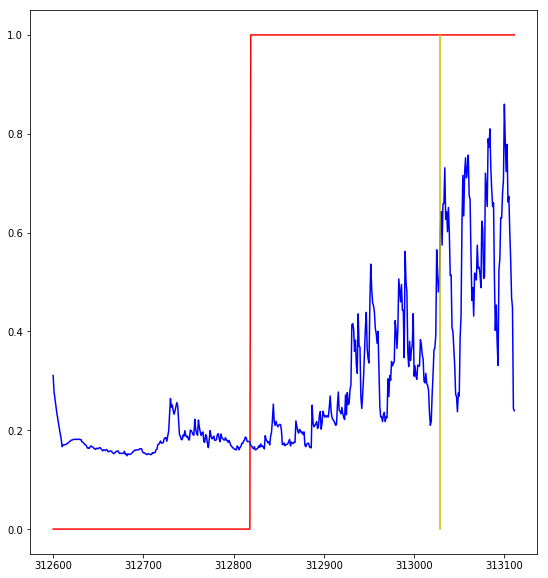

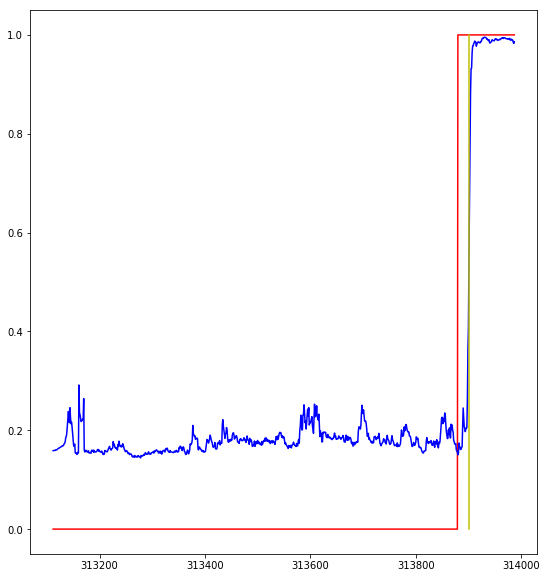

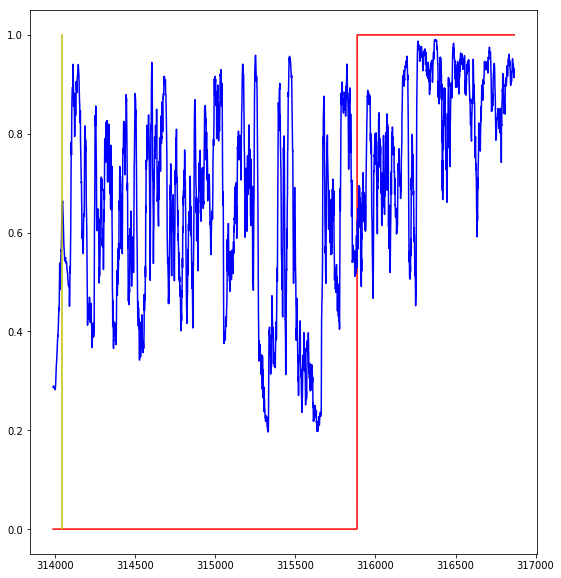

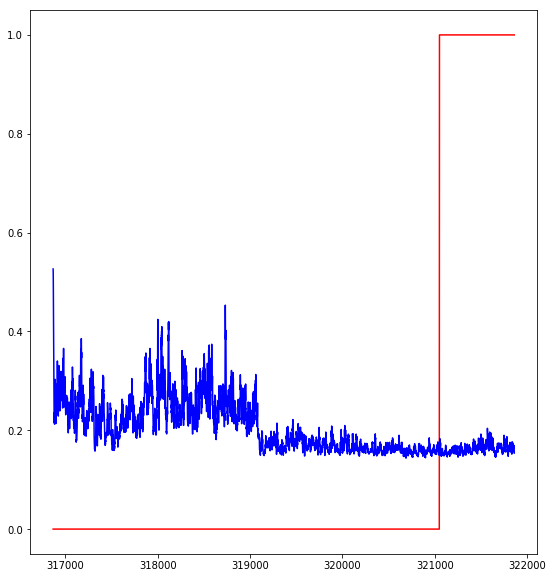

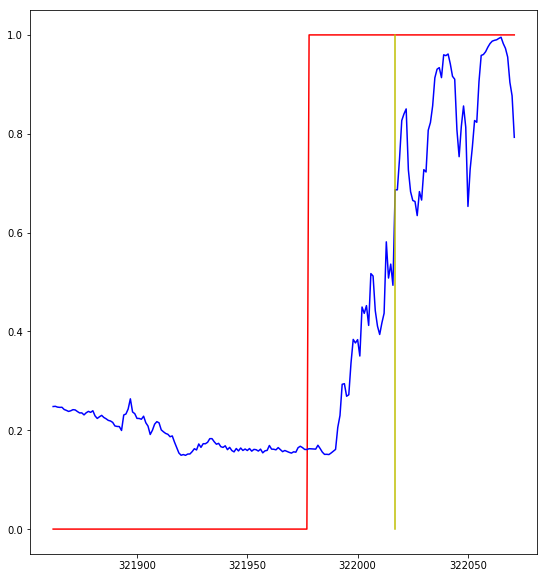

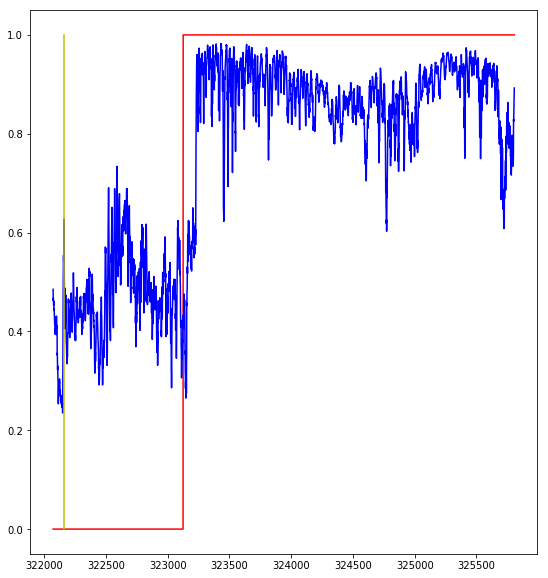

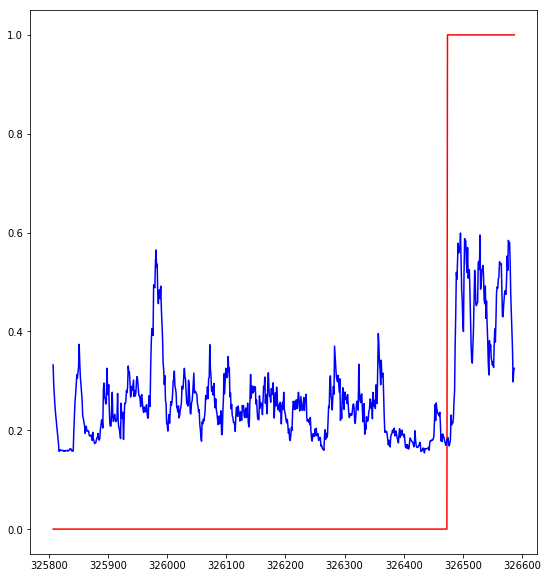

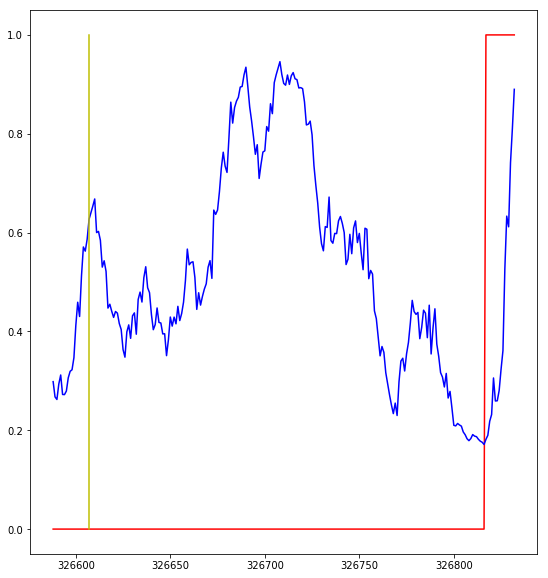

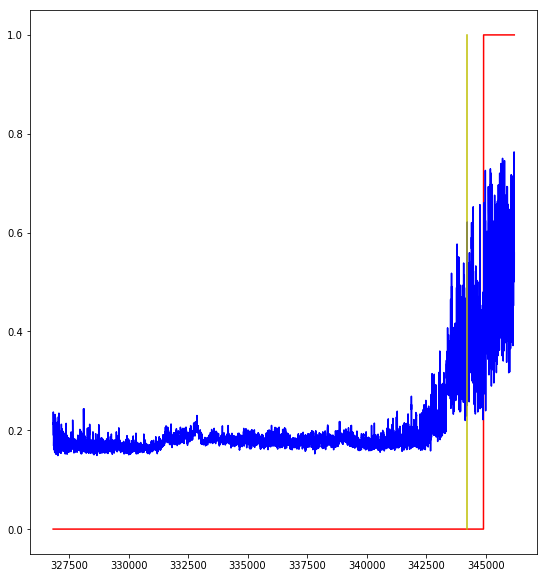

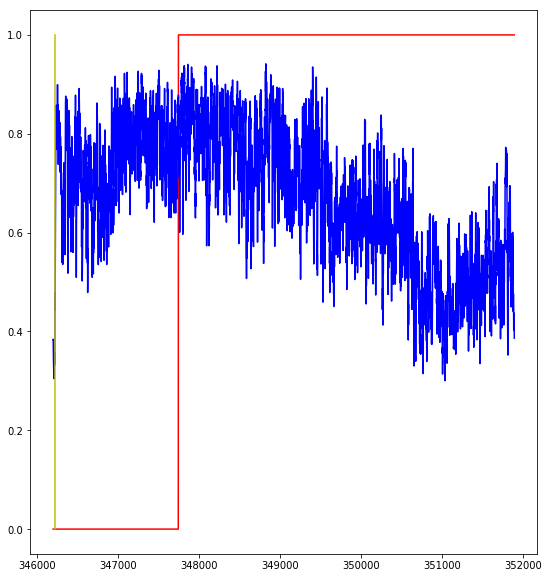

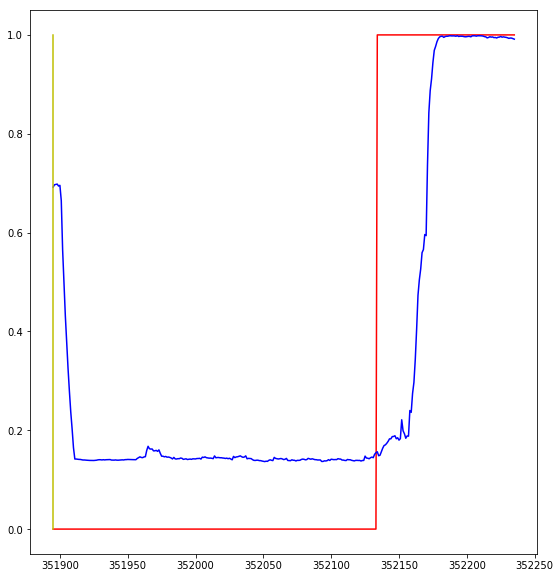

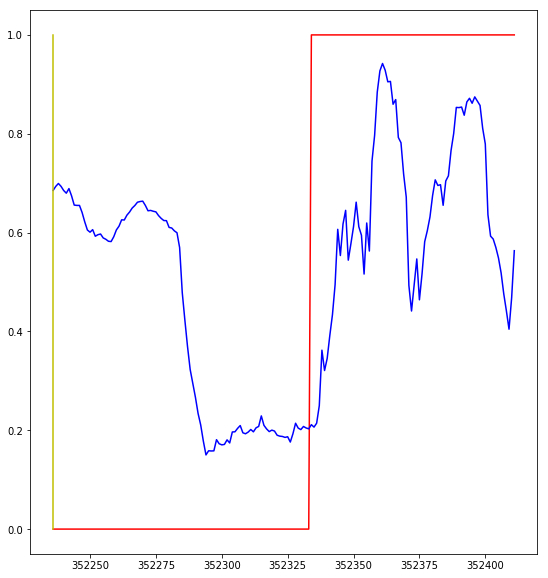

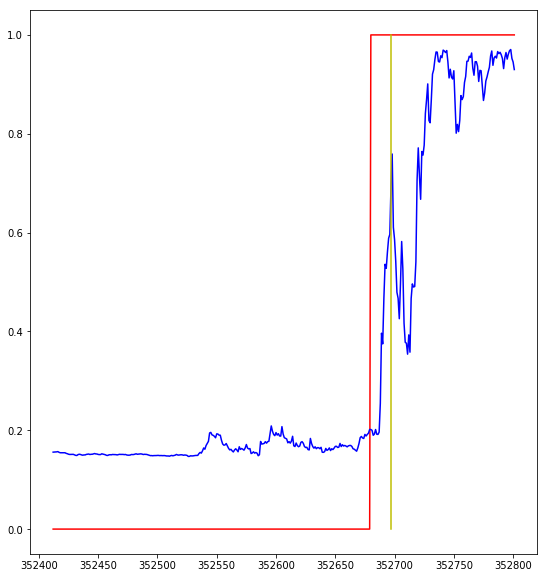

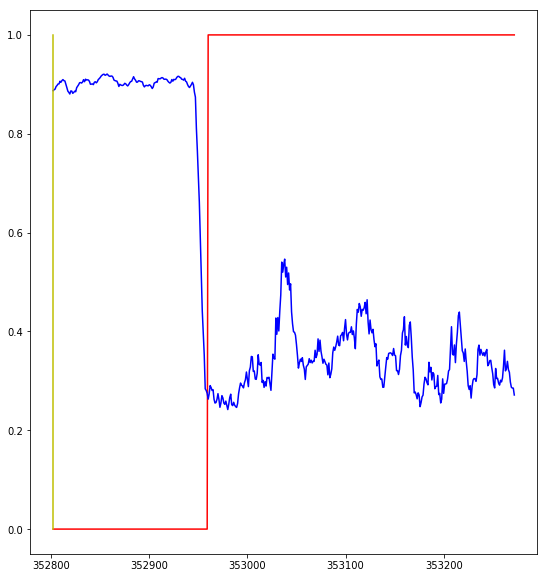

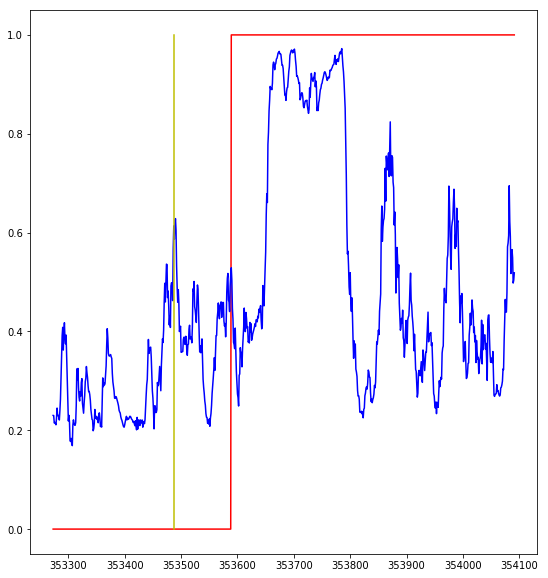

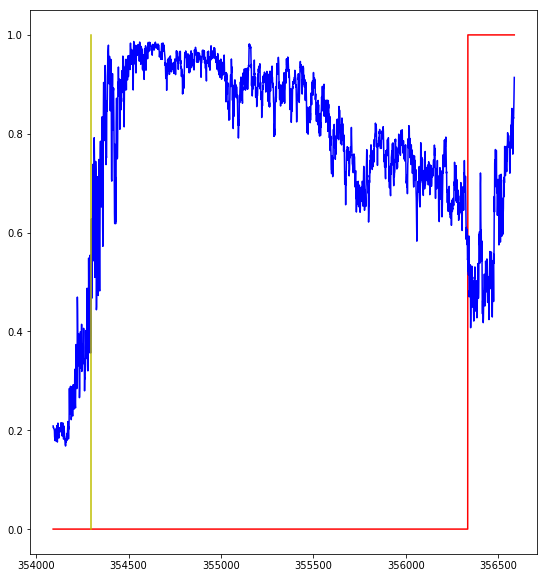

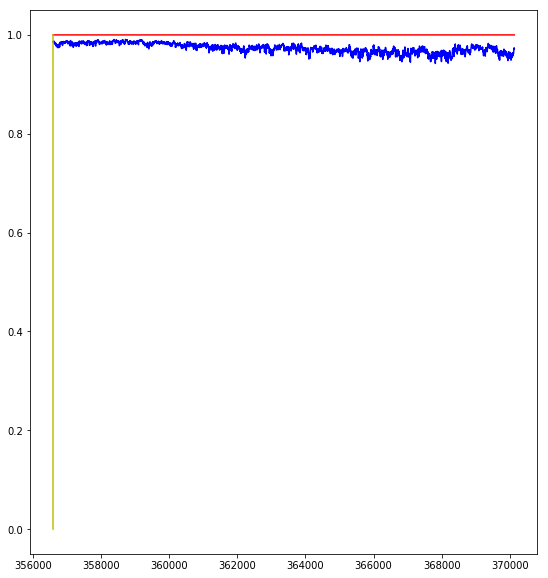

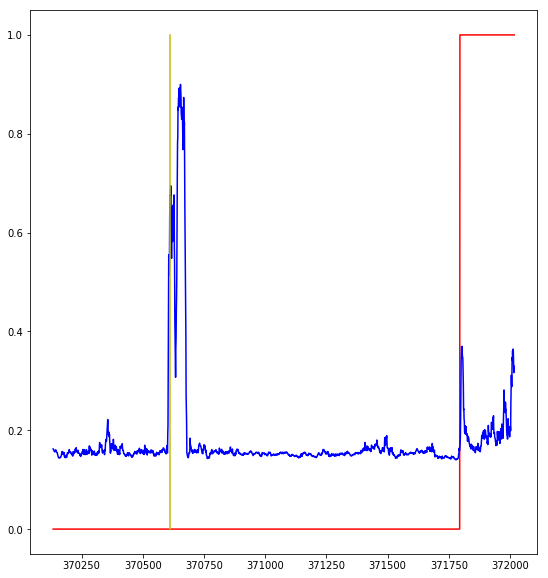

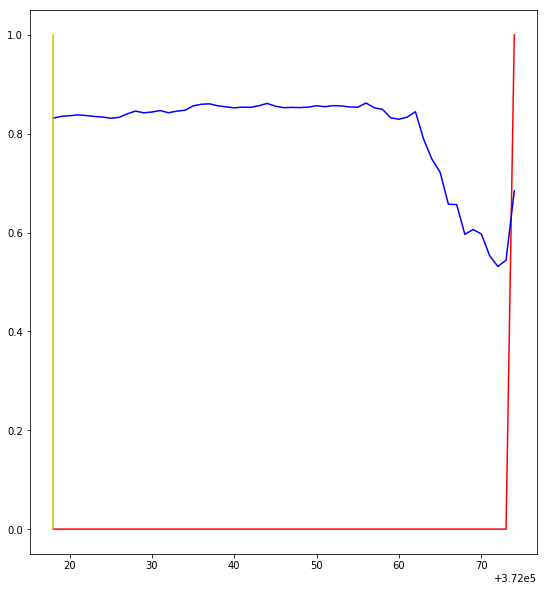

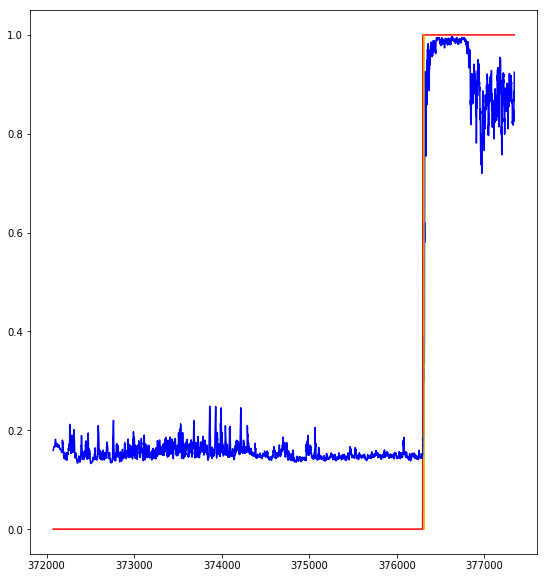

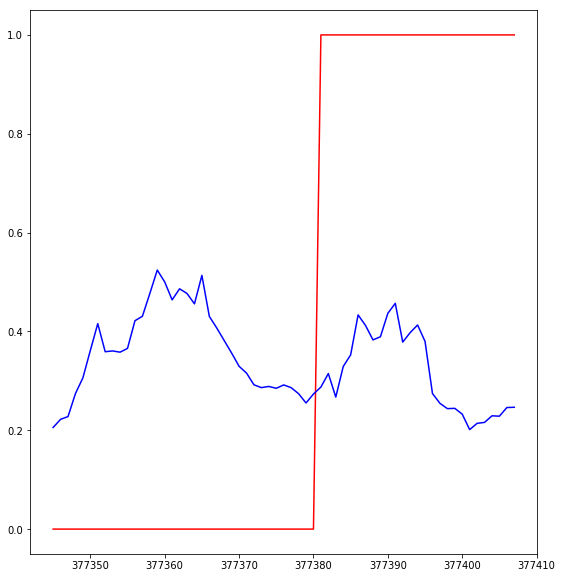

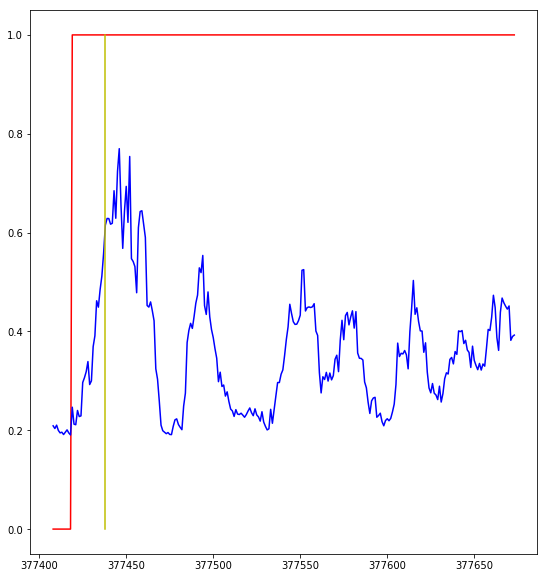

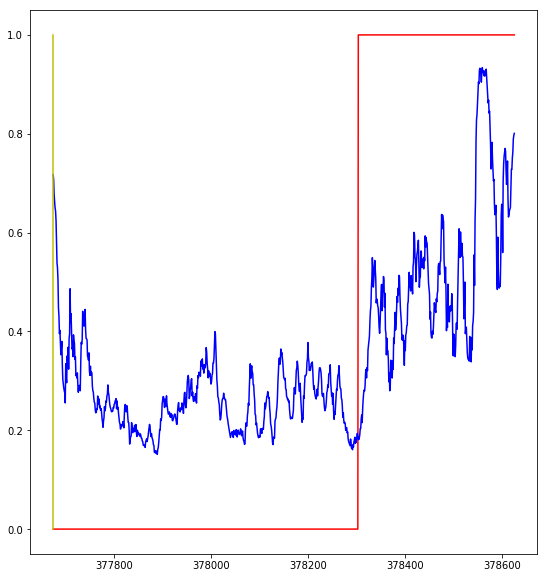

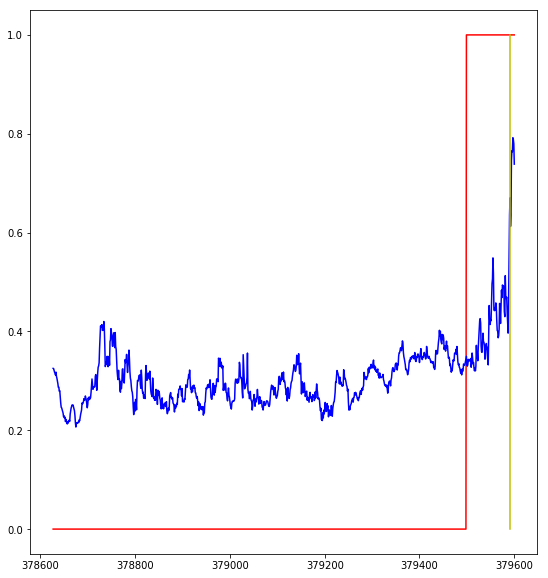

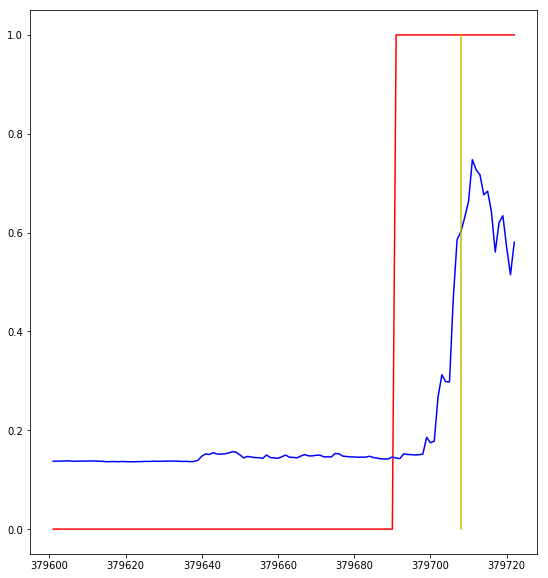

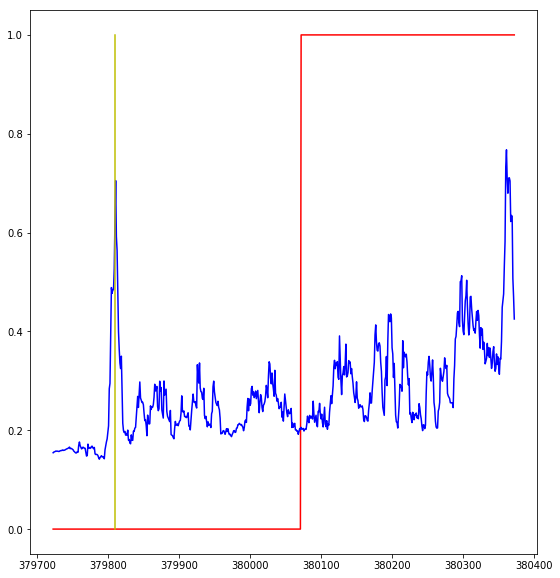

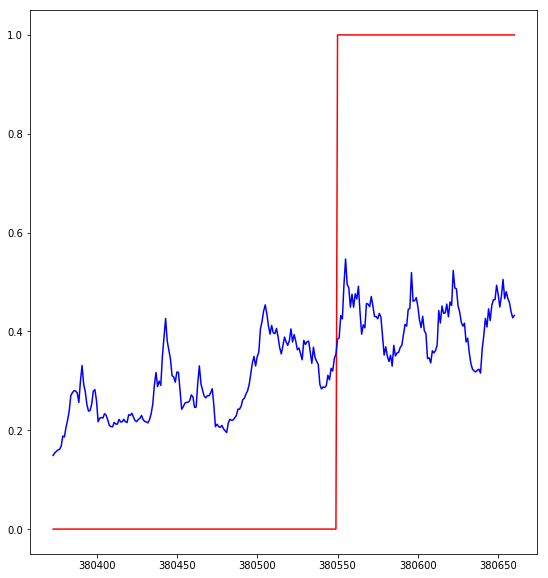

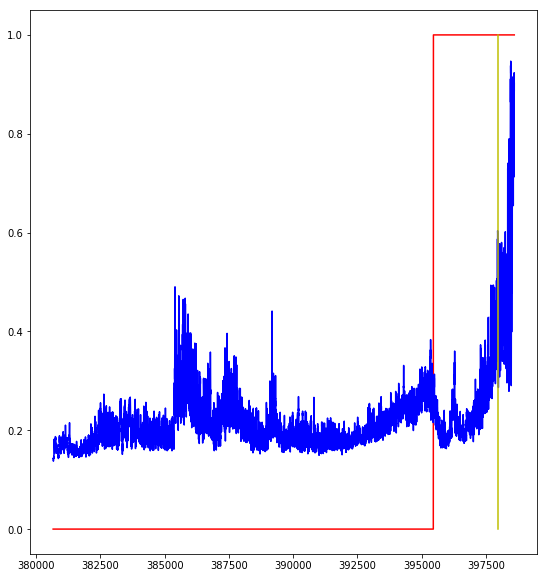

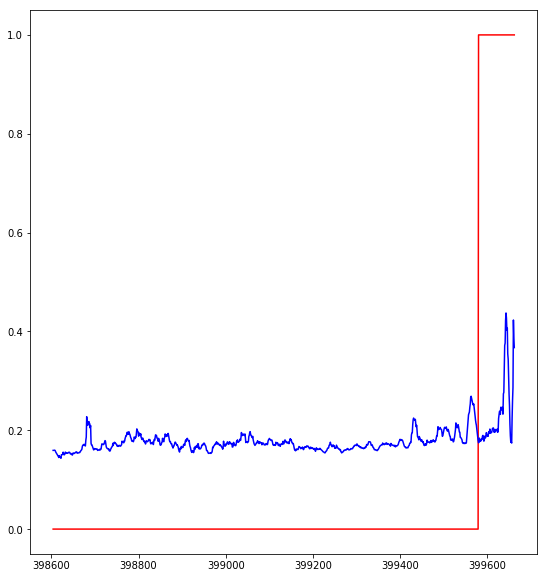

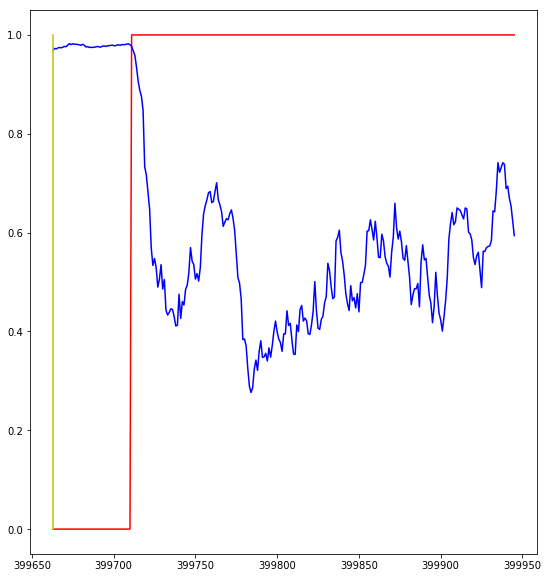

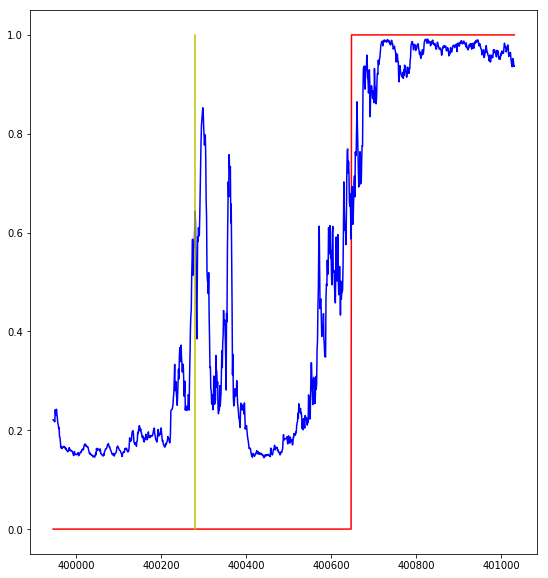

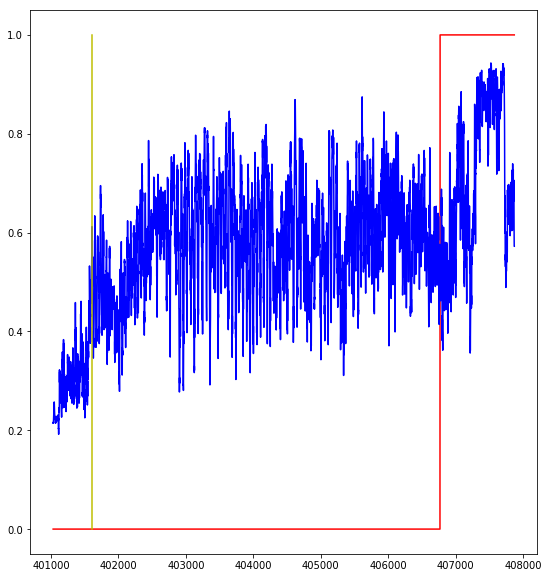

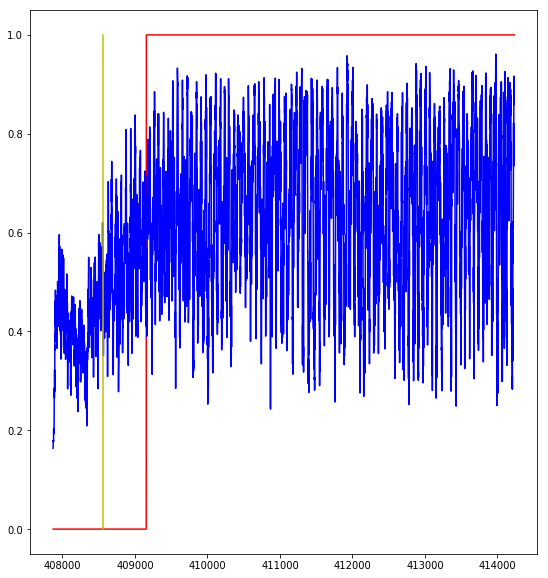

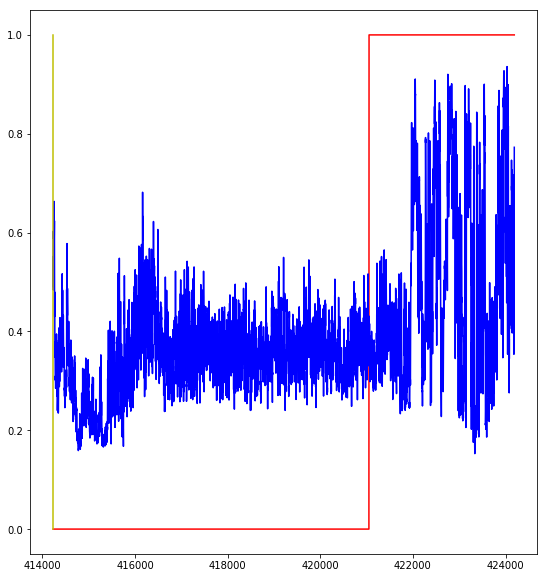

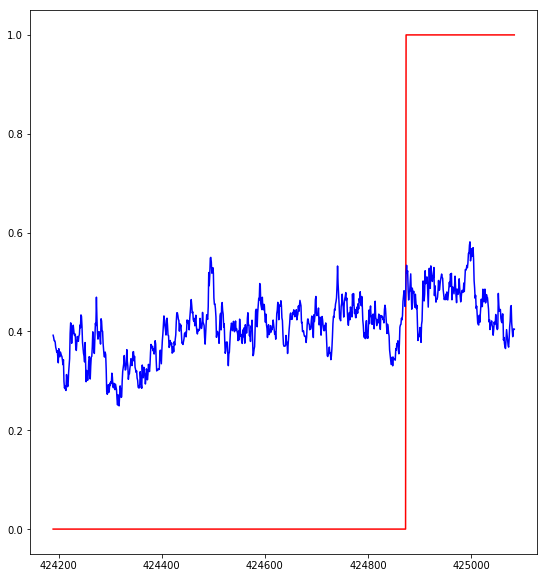

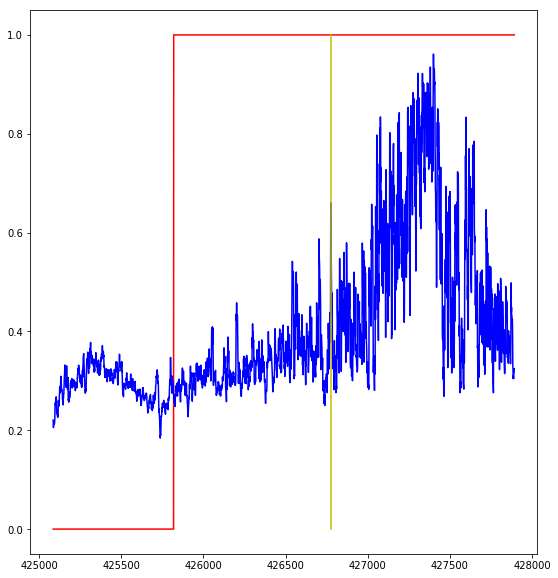

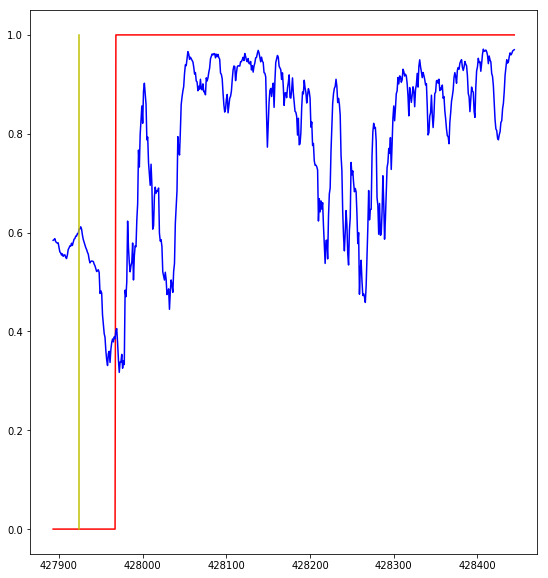

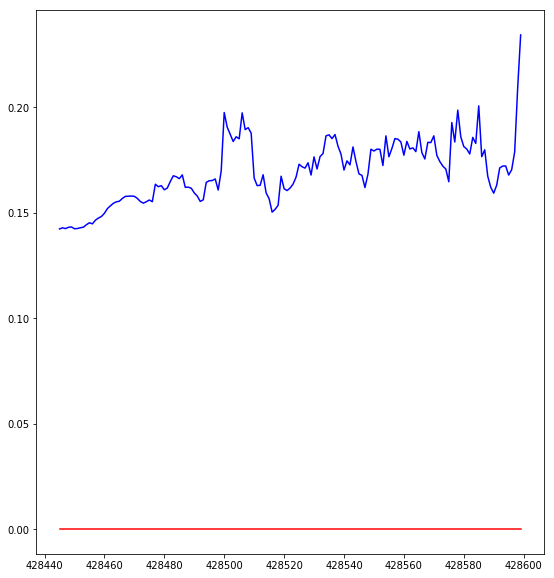

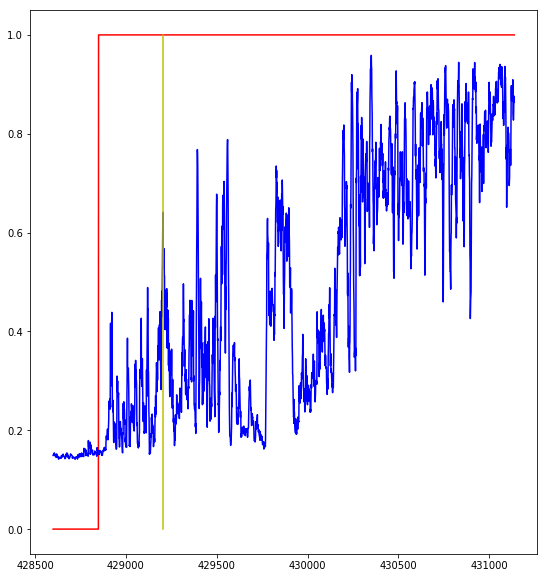

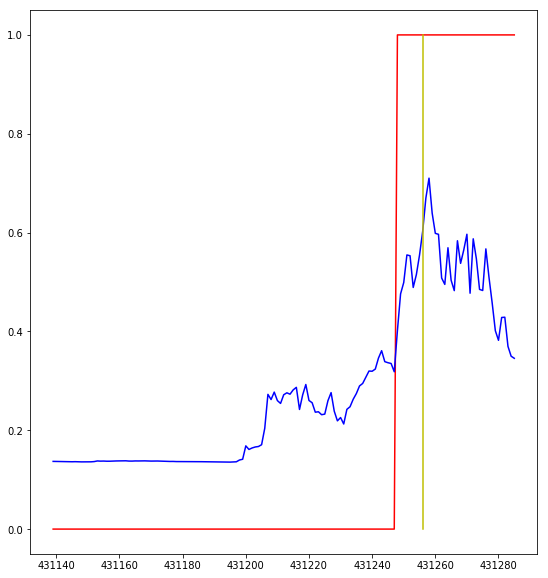

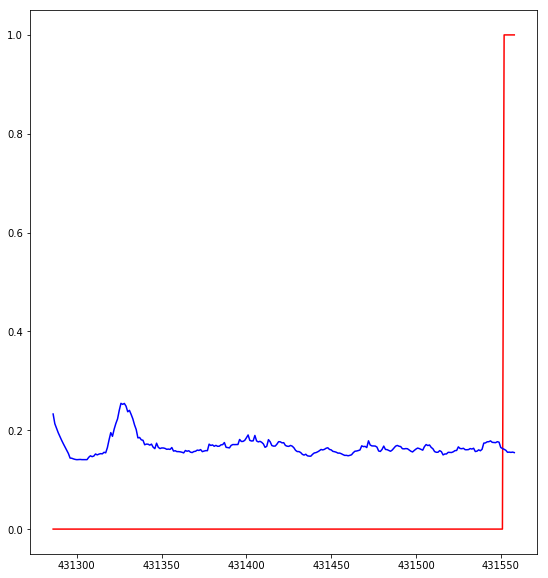

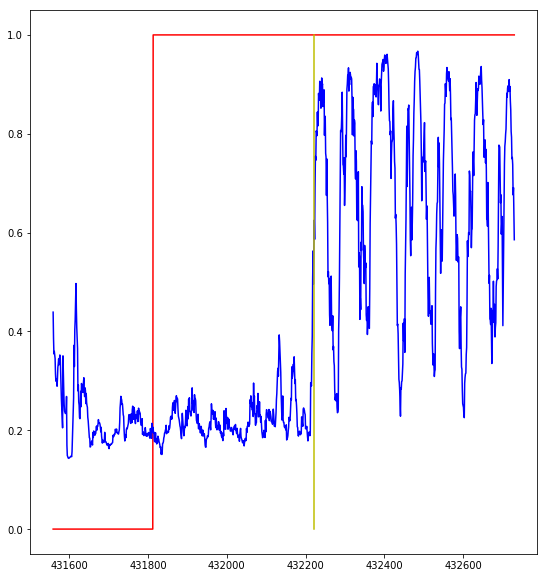

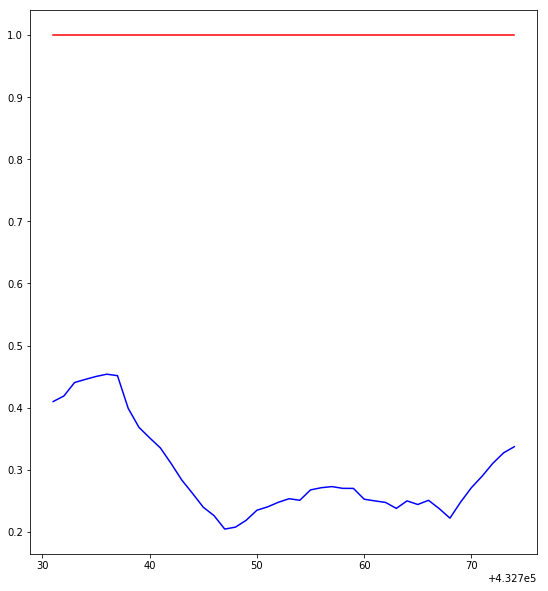

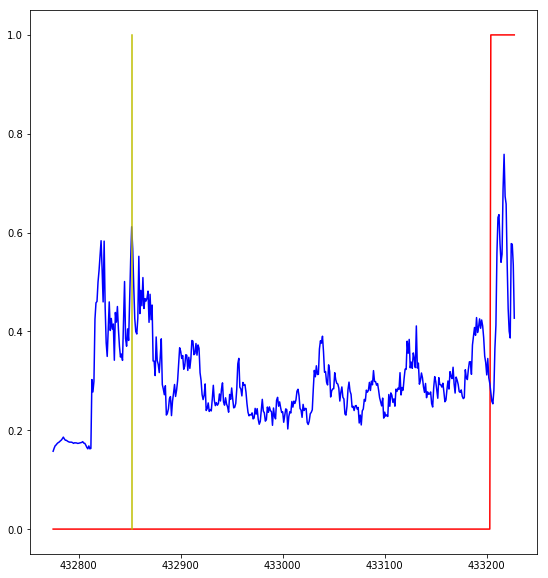

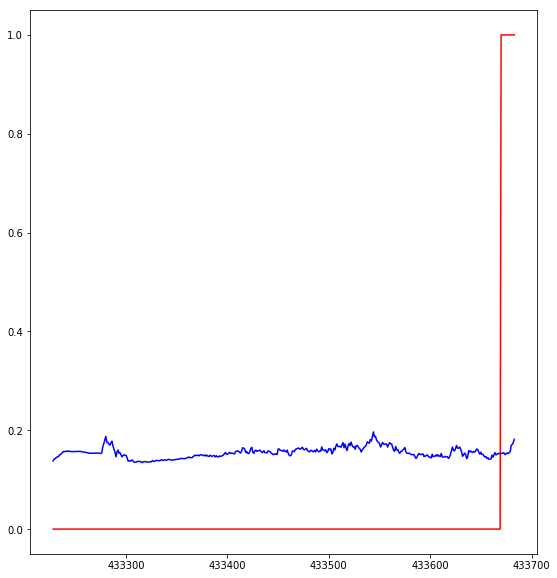

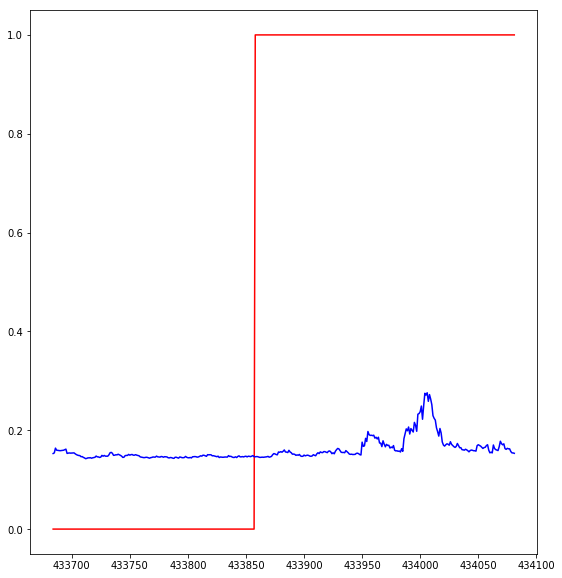

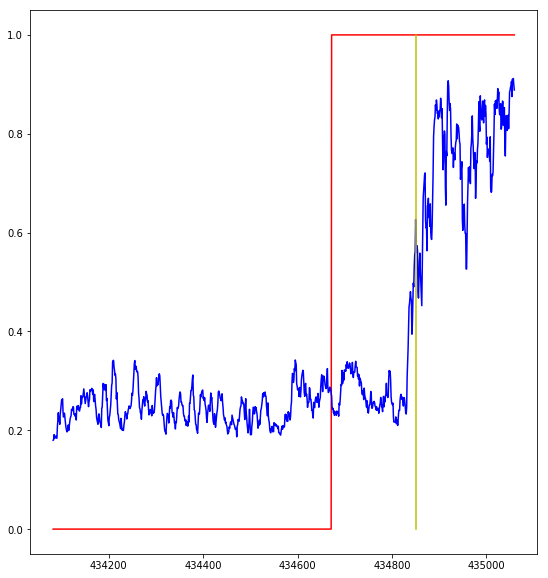

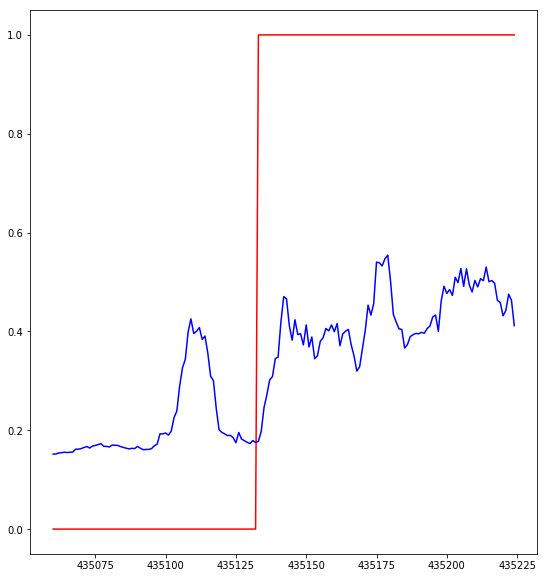

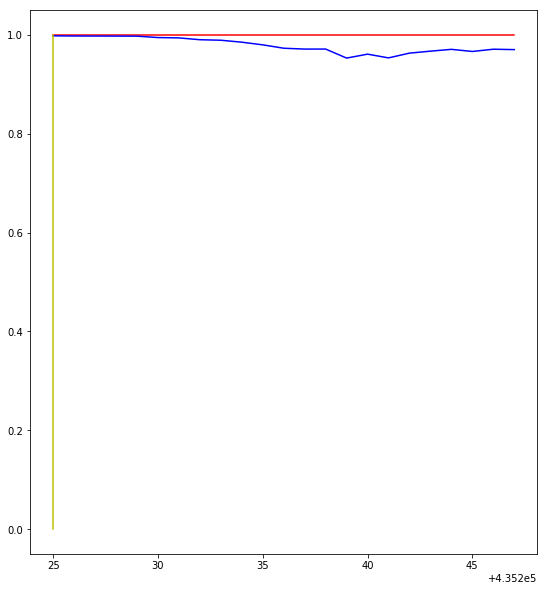

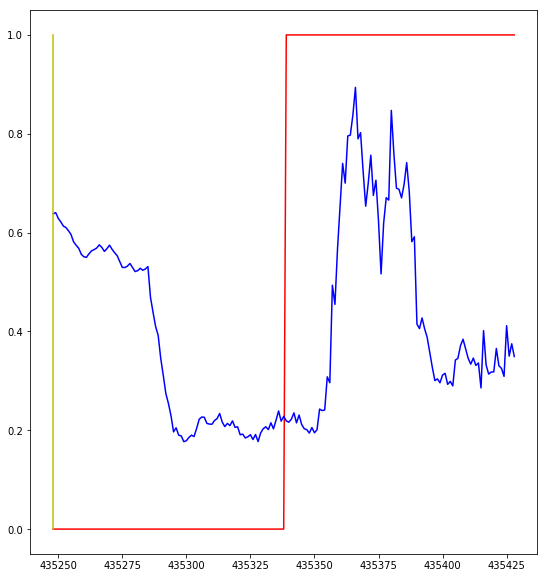

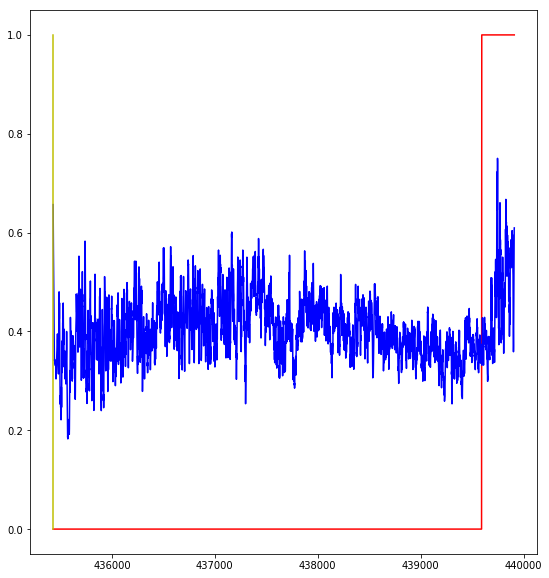

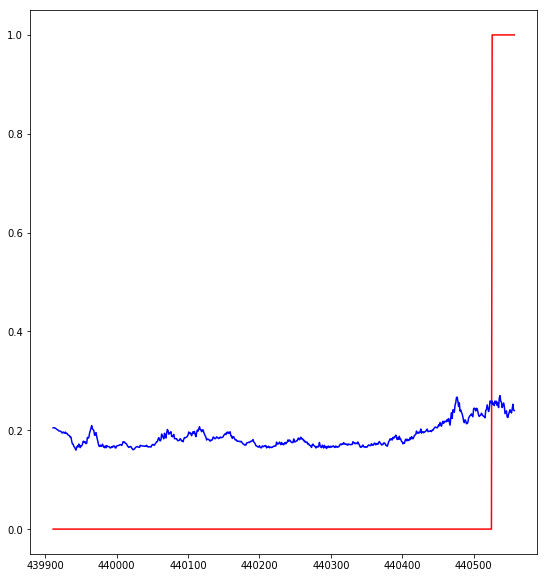

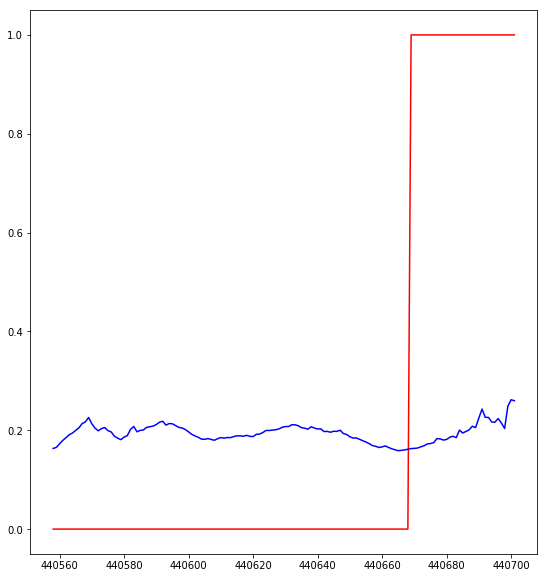

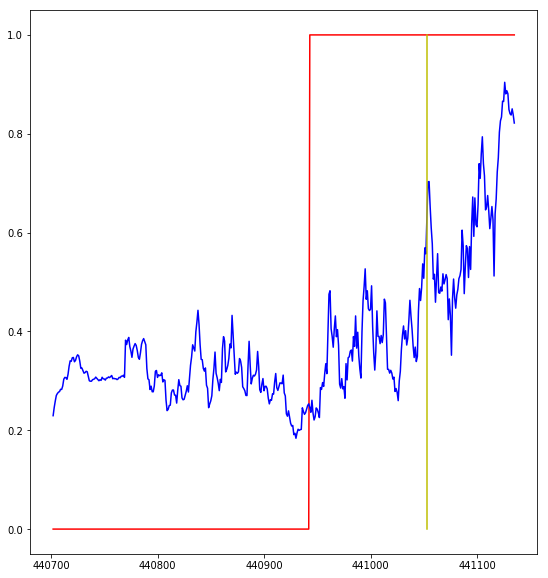

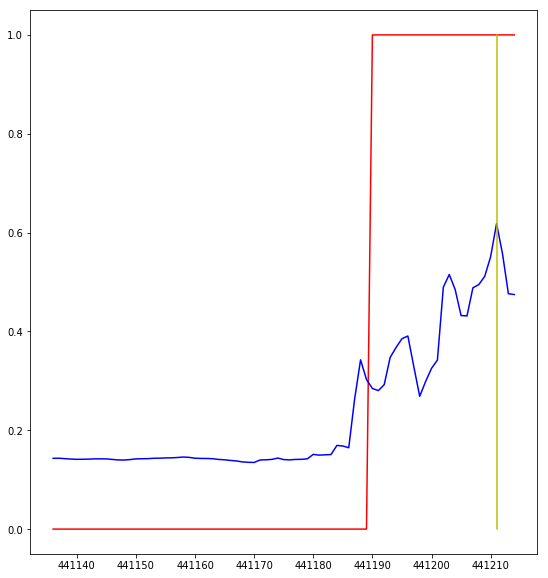

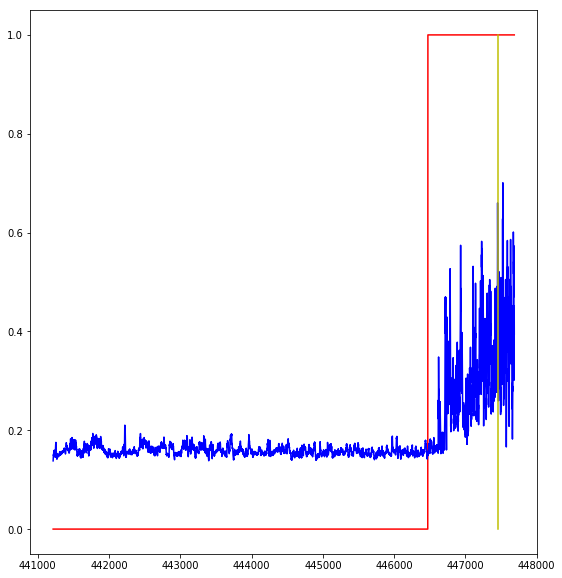

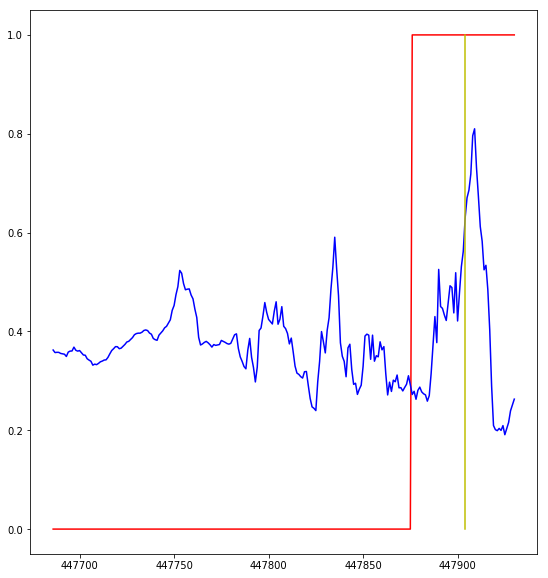

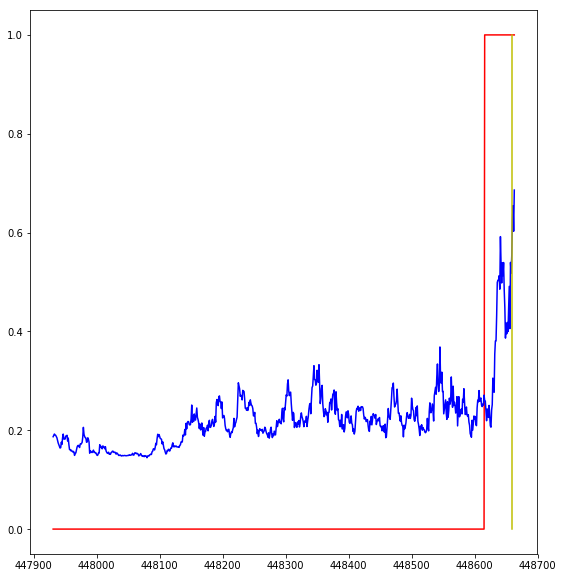

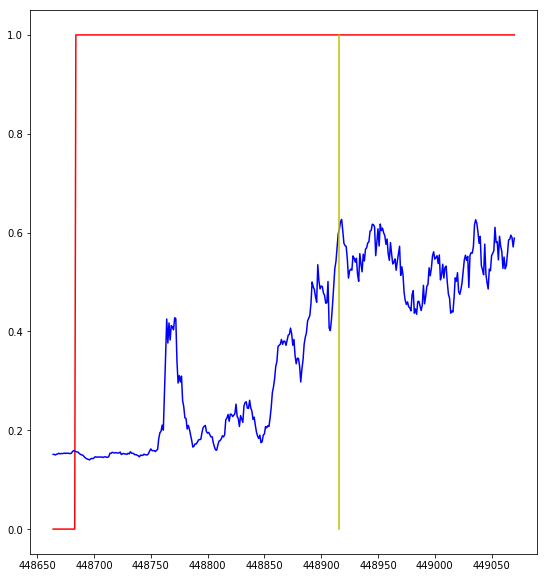

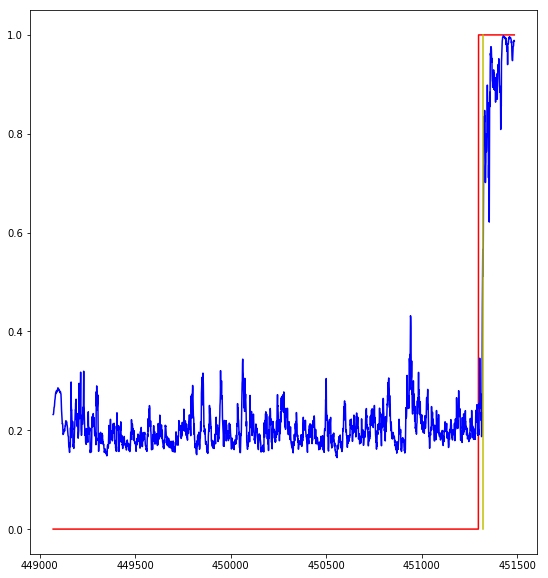

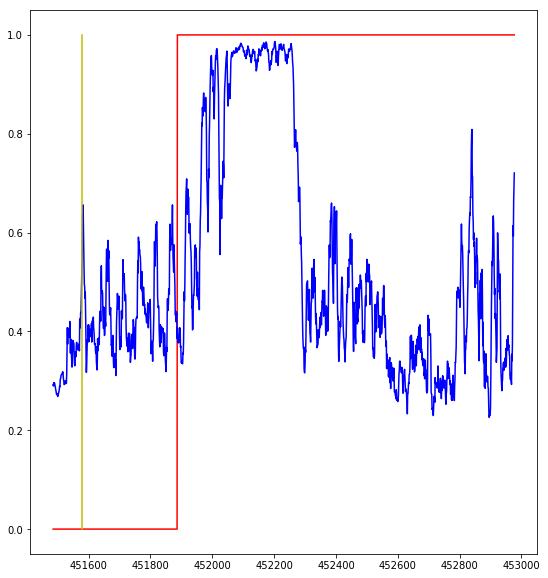

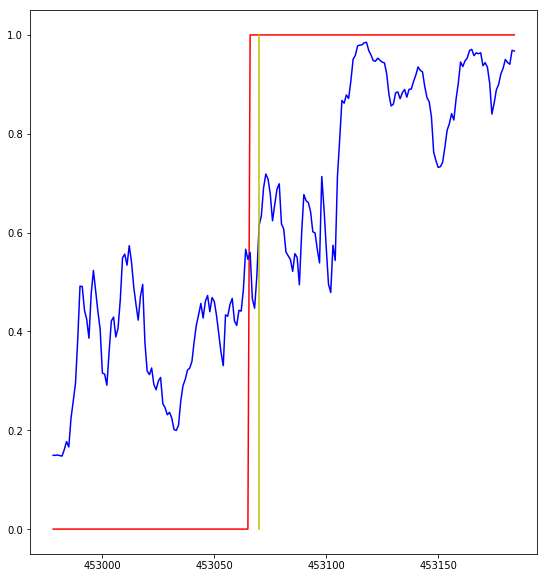

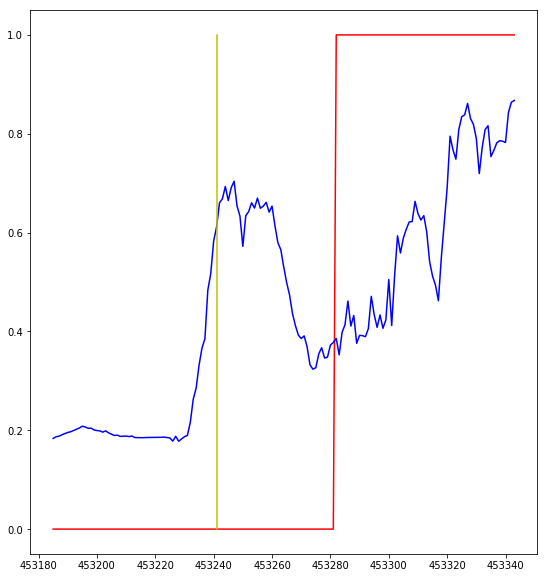

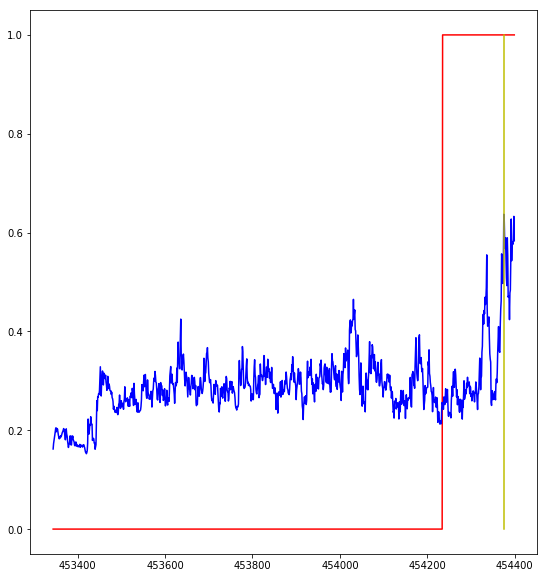

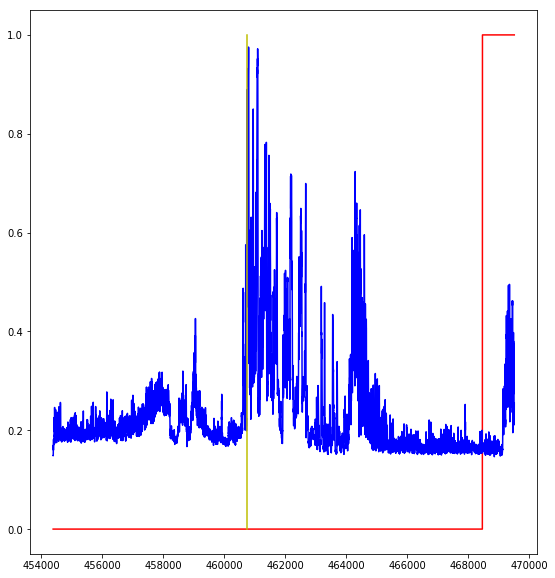

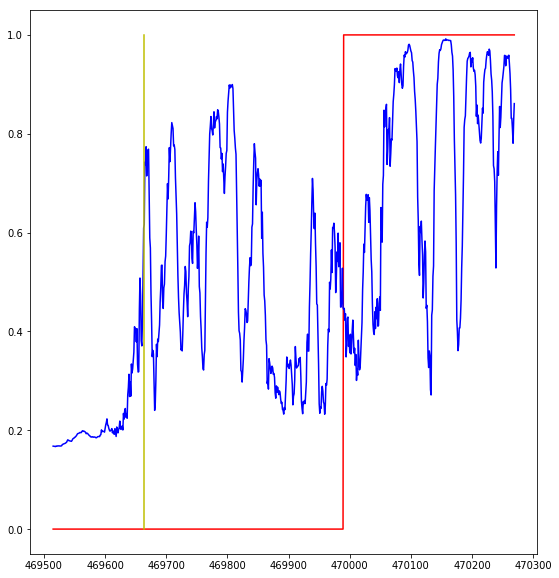

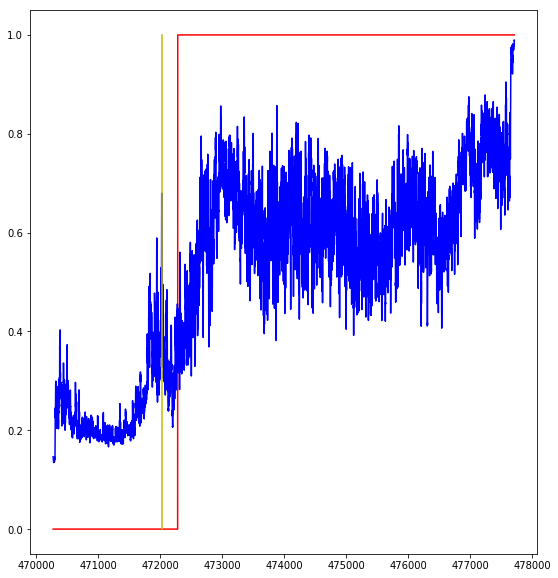

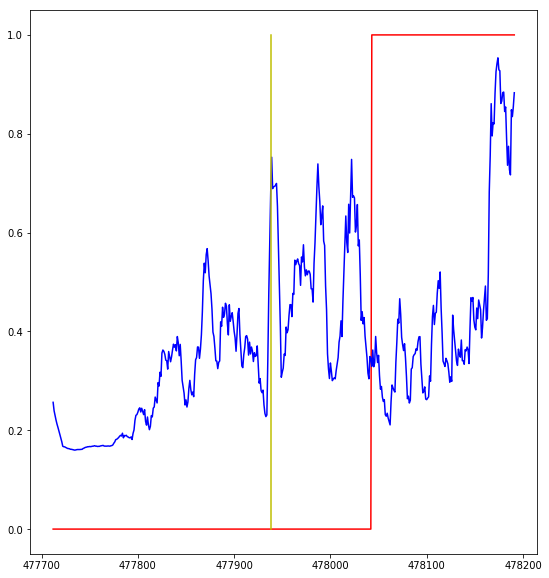

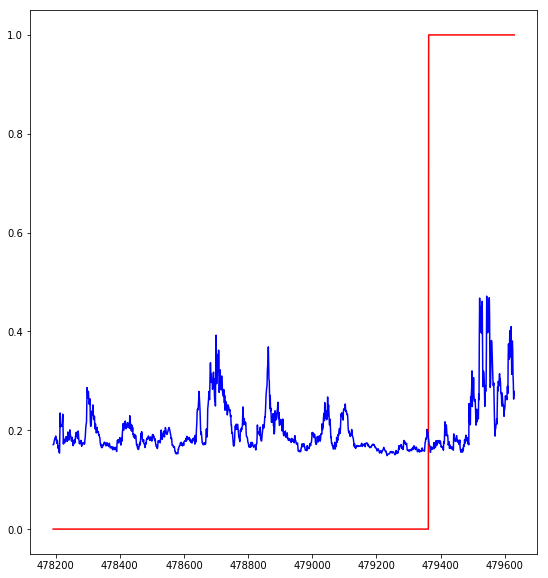

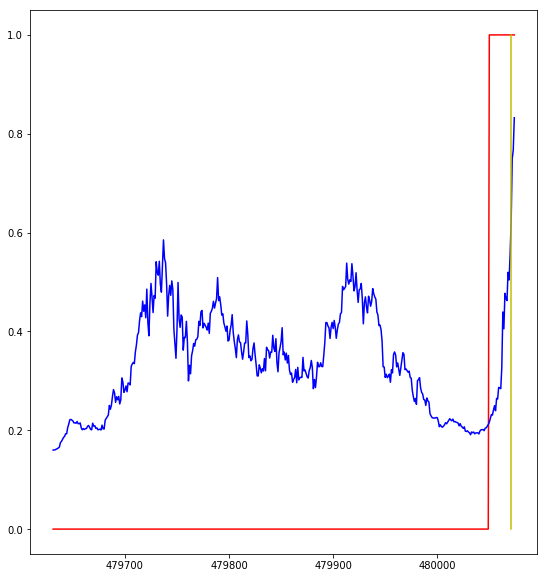

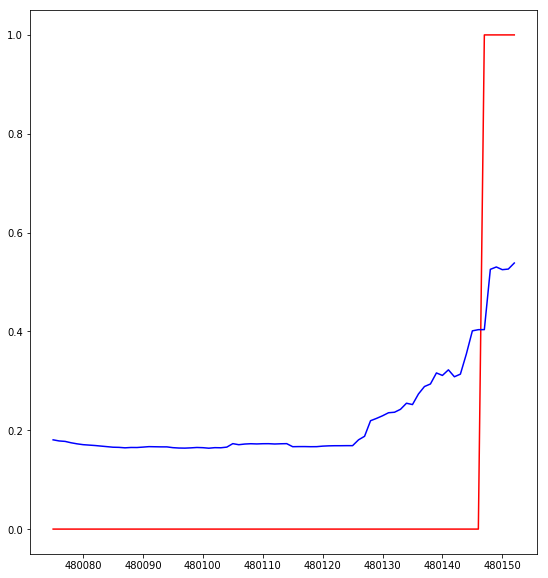

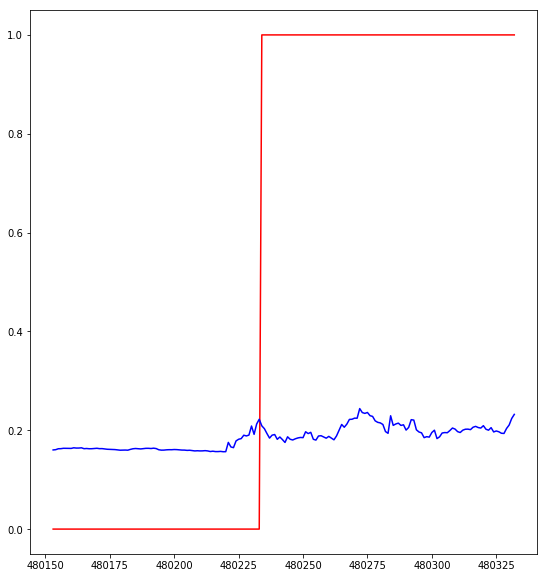

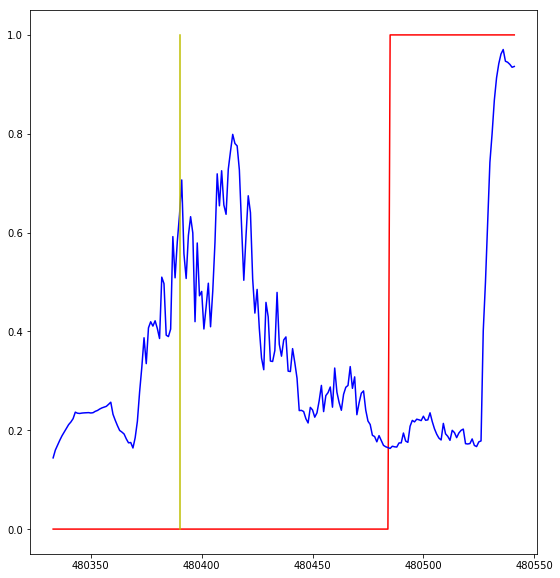

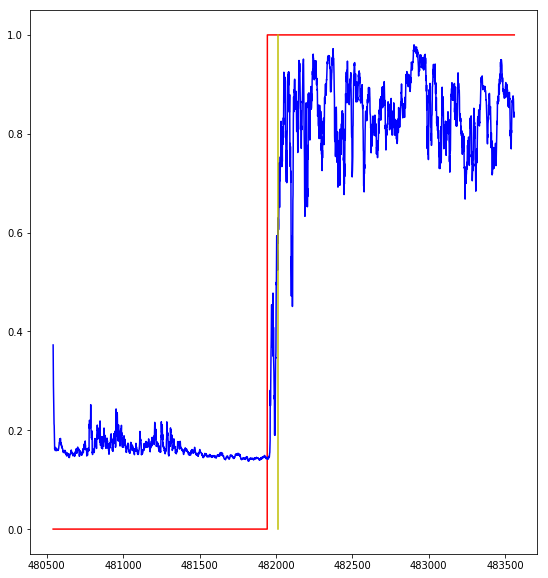

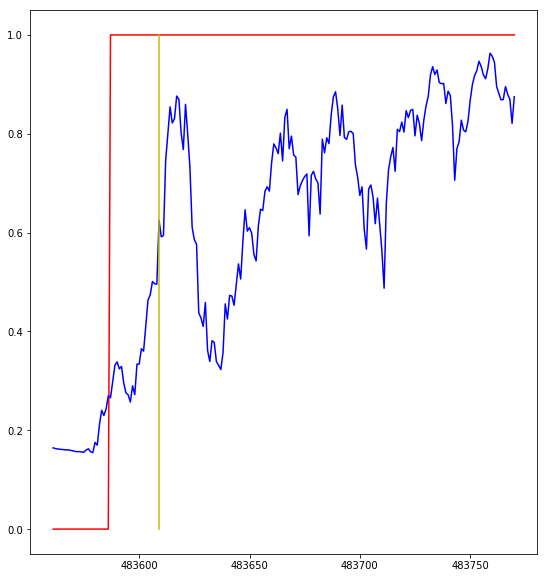

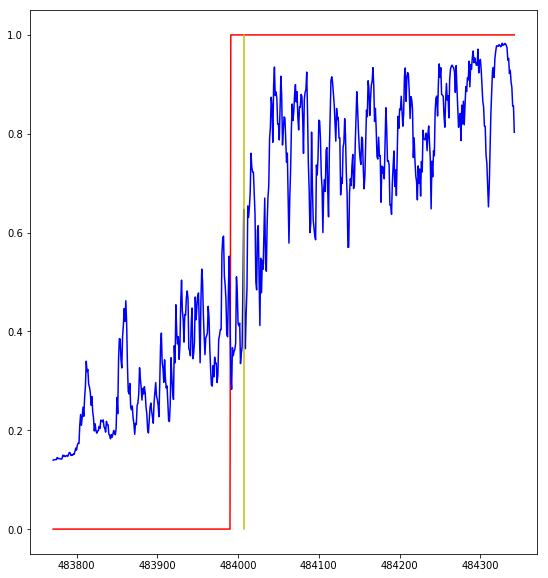

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]
y_pred = model.predict_proba(X)
fn = 0
fp = 0
tp = 0
tn = 0
detection_threshold  = 0.60
repeat_fails = 2
plot = True
for i in range(len(frame_starts)):
    if i == len(frame_starts) -1 :
        frame_end = X.shape[0]
    else :
        frame_end = frame_starts[i+1]
    frame_start = frame_starts[i]
    
    if plot:
        figure =plt.figure()
        plt.subplot(121)
        plt.plot(np.arange(frame_start,frame_end), label[frame_start:frame_end], 'r')
        plt.plot(np.arange(frame_start,frame_end), y_pred[frame_start:frame_end,1], 'b')
    
    detection_frames = np.where(y_pred[frame_start:frame_end,1] > detection_threshold)[0]
    fail_frames = np.where(np.array(label[frame_start:frame_end])==True)[0]
    
    if len(fail_frames) > 0 :
        fail_start_frame = fail_frames[0]
    else :
        fail_start_frame = 1e10
        
    if plot:
        if len(detection_frames) > 0 : 
            plt.plot([detection_frames[0] + frame_start,detection_frames[0]+frame_start],[0,1], linestyle='-', color='y')
        
#         ax=plt.subplot(122)
#         draw_detection(i,failstart[i],0,ax)
#         plt.show()

    if len(detection_frames) < repeat_fails : 
        # no detection
        if  fail_start_frame < 1e10 :
            fn += 1
            print('False Negative')
        else :
            tn += 1
            print('True Negative')
    elif detection_frames[repeat_fails-1] < fail_start_frame:
        fp += 1
        print('False Positive')
    else :
        tp += 1
        print('True Positive')
        
print ( 'fn=', fn, 'fp=',fp, 'tn=', tn, 'tp=',tp)
print ( 'recall=', tp/(tp + fn), 'precision=',tp/(tp + fp))

In [307]:
# build dataset with averages of past [1, 10, 20, 50, 100] frames
def get_avg(vid, fid, n, boxes) :
    if fid == 0 :
        return detections[vid,fid,:boxes,0]
    if fid >= n-1 :
        window = detections[vid,fid-n+1: fid+1,:boxes,0]
    else :
        window = detections[vid,:fid+1, :boxes, 0]
    return (np.sum(window, axis=0)/window.shape[0]).reshape(-1)

dataset = []
label = []
frame = 0
frame_starts = []
kmean_samples = 50
kmean_clusters = 5
boxes_to_check = 5
for vid in range(len(real_starts_df)) :
    print("working on video ",  real_starts_df.index[vid])
    step = max( 1, int(frame_size[vid]/100))
    print('step = ', step)
    frame_starts.append(frame)
    for fid in range(0,frame_size[vid],step) :
        feature = detections[vid,fid, :boxes_to_check, 0].reshape(-1)
        for n in [10, 20, 50, 100] :
            feature = np.concatenate((feature, get_avg(vid,fid,n,boxes_to_check)))
        dataset.append(feature)           
        label.append(fid >= failstart[vid])
        frame +=1



working on video  190011
step =  1
working on video  190048
step =  25
working on video  190053
step =  31
working on video  190183
step =  49
working on video  190306
step =  1
working on video  190313
step =  1
working on video  190315
step =  1
working on video  190349
step =  24
working on video  190399
step =  12
working on video  190400
step =  59
working on video  190405
step =  35
working on video  190406
step =  1
working on video  190418
step =  27
working on video  190422
step =  35
working on video  190446
step =  9
working on video  190473
step =  4
working on video  190600
step =  1
working on video  190614
step =  1
working on video  190691
step =  76
working on video  190741
step =  10
working on video  190776
step =  14
working on video  190838
step =  8
working on video  190878
step =  9
working on video  190884
step =  4
working on video  190925
step =  5
working on video  190943
step =  1
working on video  190973
step =  5
working on video  190982
step =  15
working

In [58]:
#LSTM model 
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.utils import to_categorical
import numpy as np

model = Sequential()

# input is n boxes, a total of 5 x n features
boxes_to_check = 5
model.add(LSTM(32, return_sequences=True, input_shape=(None, 5 * boxes_to_check)))
model.add(LSTM(8, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam')

def train_generator():
    # return one video at each call
    num_videos = int(len(real_starts_df) * 0.8)
    vid = 0
    step = 10
    while True:
        sequence_length = frame_size[vid]
        if sequence_length == 0 :
            vid+= 1
            vid = vid % num_videos
            continue
                    
        x_train = detections[vid,0:sequence_length:step,:boxes_to_check,:].reshape(1, -1,boxes_to_check*5)
        y_train = np.arange(0,sequence_length,step)
        y_train = (y_train>= failstart[vid]).reshape(1,-1,1)
        #print(x_train.shape,y_train.shape)
        vid += 1
        vid = vid % num_videos
        yield x_train, y_train
def validate_generator():
    
    # return one video at each call
    num_videos_start = int(len(real_starts_df) * 0.8)
    num_videos = len(real_starts_df) - num_videos_start
    vid = 0
    step = 10
    while True:
        this_vid = vid + num_videos_start
        sequence_length = frame_size[this_vid]
        if sequence_length == 0 :
            vid+= 1
            vid = vid % num_videos
            continue
                    
        x_train = detections[this_vid,0:sequence_length:step,:boxes_to_check,:].reshape(1, -1,boxes_to_check*5)
        y_train = np.arange(0,sequence_length, step)
        y_train = (y_train>= failstart[this_vid]).reshape(1,-1,1)
        vid += 1
        vid = vid % num_videos
        yield x_train, y_train 
        
def validate_generator2():
    # return one video at each call
    sequence_length = 50
    batch_size = 15
    num_videos = len(real_starts_df)
    validation_videos_start = int(len(real_starts_df)*0.8)
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size) :
            while True :
                vid = np.random.randint(validation_videos_start, num_videos)
                if failstart[vid] > sequence_length and failstart[vid] < frame_size[vid] :
                    break
            # pick one from each category for balanced training
            fid = np.random.randint(sequence_length,failstart[vid])
            x_train = detections[vid,fid-sequence_length+1:fid+1,:boxes_to_check,:].reshape(sequence_length,boxes_to_check*5)
            y_train = np.arange(fid-sequence_length+1, fid+1)
            y_train = (y_train>= failstart[vid]).reshape(sequence_length,1)
            x_batch.append(x_train)
            y_batch.append(y_train)
            
            fid = np.random.randint(failstart[vid], frame_size[vid])
            x_train = detections[vid,fid-sequence_length+1:fid+1,:boxes_to_check,:].reshape(sequence_length,boxes_to_check*5)
            y_train = np.arange(fid-sequence_length+1, fid+1)
            y_train = (y_train>= failstart[vid]).reshape(sequence_length,1)
            x_batch.append(x_train)
            y_batch.append(y_train)
        
        x_batch = np.stack(x_batch,axis=0)    
        y_batch = np.stack(y_batch,axis=0)
        
        yield x_batch, y_batch
        
model.fit_generator(generator = train_generator(), steps_per_epoch=int(len(real_starts_df)*0.8),
                    validation_data = validate_generator(), 
                    validation_steps =len(real_starts_df) - int(len(real_starts_df)*0.8), 
                    epochs=1, verbose=1)


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          7424      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 8)           1312      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           9         
Total params: 8,745
Trainable params: 8,745
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
227/227 [==============================] - 103s 453ms/step - loss: 0.6933 - val_loss: 0.6826


In [59]:
y_train = []
y_train_pred = []
count = 0
for x,y in train_generator() :
    y_pred = model.predict(x)
    y_train.append(y.ravel())
    y_train_pred.append(y_pred.ravel())
    count += 1
    if count == 226 :
        break
y_train = np.concatenate(y_train)
y_train_pred = np.concatenate(y_train_pred)

y_test = []
y_test_pred = []
count = 0
for x,y in validate_generator() :
    y_pred = model.predict(x)
    y_test.append(y.ravel())
    y_test_pred.append(y_pred.ravel())
    count += 1
    if count == 284-227 :
        break
y_test = np.concatenate(y_test)
y_test_pred = np.concatenate(y_test_pred)